# **Forecasting of Energy Time Series Data using Smoothing, ARIMA and LSTM Models**

## **Time Series Preamble**

In [4]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os
os.chdir('labs/Forecasting/data/')
from colorsetup import colors, palette
# ignore warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline
!pip install pmdarima
import pmdarima as pm
plotsize = (13, 5)
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Non-Stationary Seasonal Series - US Natural Gas Consumption

This dataset was retrieved from the U.S. Energy Information Administration (EIA). It consists of monthly Natural Gas Production, Imports, Exports and Consumption Data from January 1973 to August 2020. A total of 572 months of data. 

In [73]:
us_ngpd = pd.read_excel('Table_4.1_Natural_Gas_Overview.xlsx') #from EIA
us_ngpd.drop(range(9), inplace = True)
us_ngpd.rename(columns = us_ngpd.iloc[0], inplace = True)
us_ngpd.drop(9, inplace = True)
us_ngpd['Month'] = pd.to_datetime(us_ngpd['Month'])
us_ngpd.insert(0, 'year', us_ngpd['Month'].dt.year)
us_ngpd.insert(1, 'month', us_ngpd['Month'].dt.month)
us_ngpd.set_index('Month', inplace = True)

In [75]:
us_ngpd.head()

year  month Natural Gas Gross Withdrawals (Billion Cubic Feet)  \
Month                                                                        
1973-01-01  1973      1                                      Not Available   
1973-02-01  1973      2                                      Not Available   
1973-03-01  1973      3                                      Not Available   
1973-04-01  1973      4                                      Not Available   
1973-05-01  1973      5                                      Not Available   

           Natural Gas Marketed Production (Wet) (Billion Cubic Feet)  \
Month                                                                   
1973-01-01                                               1948           
1973-02-01                                               1962           
1973-03-01                                               1907           
1973-04-01                                               1814           
1973-05-01                                               1898           

           NGPL Production (Billion Cubic Feet)  \
Month                                             
1973-01-01                                   79   
1973-02-01                                   79   
1973-03-01                                   77   
1973-04-01                                   73   
1973-05-01                                   77   

           Natural Gas Production (Dry) (Billion Cubic Feet)  \
Month                                                          
1973-01-01                                              1869   
1973-02-01                                              1883   
1973-03-01                                              1830   
1973-04-01                                              1741   
1973-05-01                                              1821   

           Supplemental Gaseous Fuels (Billion Cubic Feet)  \
Month                                                        
1973-01-01                                   Not Available   
1973-02-01                                   Not Available   
1973-03-01                                   Not Available   
1973-04-01                                   Not Available   
1973-05-01                                   Not Available   

           Natural Gas Imports (Billion Cubic Feet)  \
Month                                                 
1973-01-01                                     92.7   
1973-02-01                                     83.9   
1973-03-01                                     91.6   
1973-04-01                                     88.4   
1973-05-01                                     85.8   

           Natural Gas Exports (Billion Cubic Feet)  \
Month                                                 
1973-01-01                                      5.8   
1973-02-01                                      6.1   
1973-03-01                                      4.0   
1973-04-01                                      8.0   
1973-05-01                                      8.7   

           Natural Gas Net Imports (Billion Cubic Feet)  \
Month                                                     
1973-01-01                                         86.9   
1973-02-01                                         77.8   
1973-03-01                                         87.6   
1973-04-01                                         80.4   
1973-05-01                                         77.1   

           Natural Gas Net Storage Withdrawals (Billion Cubic Feet)  \
Month                                                                 
1973-01-01                                      Not Available         
1973-02-01                                      Not Available         
1973-03-01                                      Not Available         
1973-04-01                                      Not Available         
1973-05-01                                      Not Available         

           Natural Gas Bala

In [76]:
us_ngpd.columns

Index(['year', 'month', 'Natural Gas Gross Withdrawals (Billion Cubic Feet)',
       'Natural Gas Marketed Production (Wet) (Billion Cubic Feet)',
       'NGPL Production (Billion Cubic Feet)',
       'Natural Gas Production (Dry) (Billion Cubic Feet)',
       'Supplemental Gaseous Fuels (Billion Cubic Feet)',
       'Natural Gas Imports (Billion Cubic Feet)',
       'Natural Gas Exports (Billion Cubic Feet)',
       'Natural Gas Net Imports (Billion Cubic Feet)',
       'Natural Gas Net Storage Withdrawals (Billion Cubic Feet)',
       'Natural Gas Balancing Item (Billion Cubic Feet)',
       'Natural Gas Consumption (Billion Cubic Feet)'],
      dtype='object')

<AxesSubplot:xlabel='Month'>

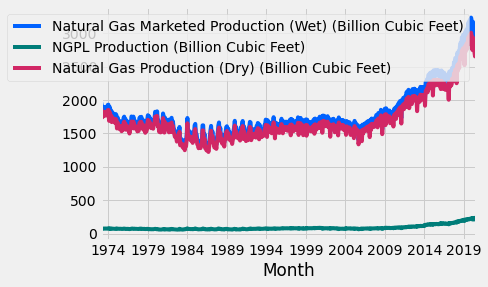

In [77]:
us_ngpd[us_ngpd.columns[[3,4,5,11]]].plot()

<AxesSubplot:xlabel='Month'>

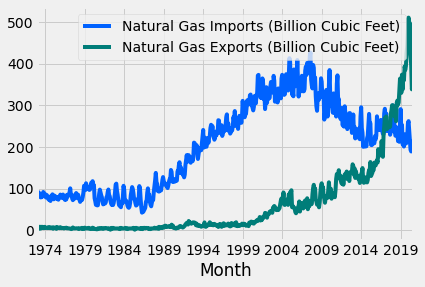

In [78]:
us_ngpd[us_ngpd.columns[[7,8]]].plot()

<AxesSubplot:xlabel='Month'>

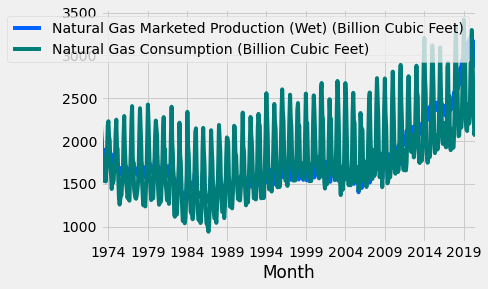

In [79]:
us_ngpd[us_ngpd.columns[[3,12]]].plot()

In [83]:
'''Function for plotting time series'''

def run_sequence_plot(x, dataset, legend, title, xlabel="time", ylabel="series"):
    plt.figure(figsize = (15, 10))
    plt.autoscale()
    plt.plot(x, dataset, 'k-', color = 'b', label = legend)
    plt.title(title, fontweight = 'bold')
    plt.xlabel(xlabel, fontweight = 'bold')
    plt.ylabel(ylabel, fontweight = 'bold')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3);

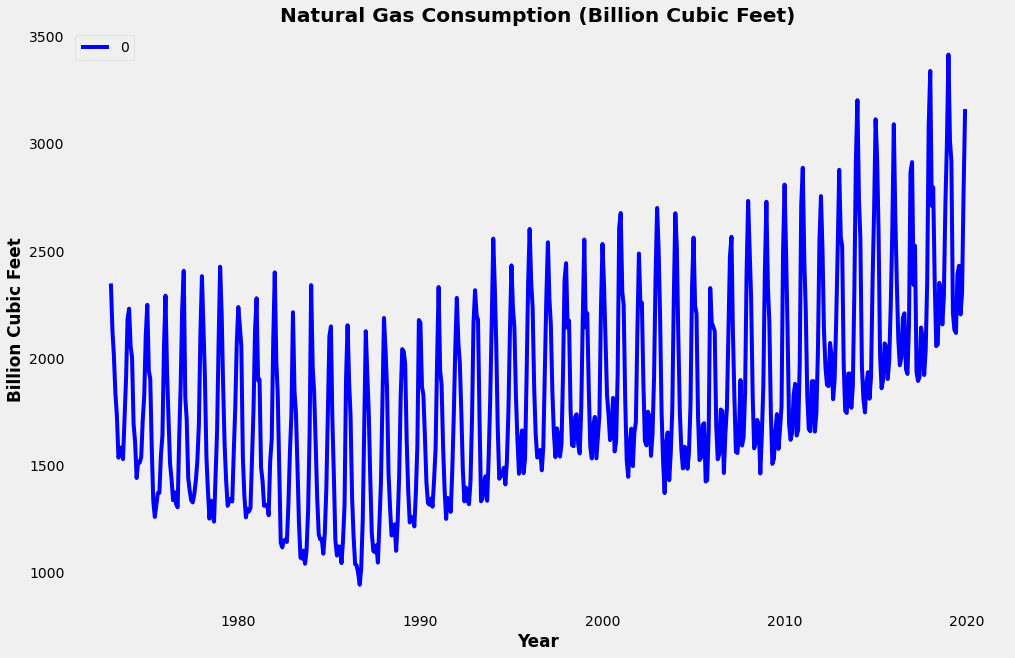

In [84]:
usngpdpro = us_ngpd[['year', us_ngpd.columns[12]]].dropna()
usngpdpro  = usngpdpro [usngpdpro ['year'] >=1970]
usngpdpro  = usngpdpro [usngpdpro ['year'] <2020]
usngpdpro = usngpdpro [[usngpdpro .columns[-1]]]
usngpdprotest = np.array(usngpdpro, dtype = 'float64')
usngpdprotest = pd.DataFrame(usngpdprotest)
usngpdprotest.index = usngpdpro.index
usngpdpro = usngpdprotest
usngpdprolegend = usngpdpro.columns[-1]
run_sequence_plot(usngpdpro.index, np.array(usngpdpro) , usngpdprolegend, title = us_ngpd.columns[12], xlabel = 'Year', ylabel ='Billion Cubic Feet')

## Stationarity

Most time series prediction techniques require that the series is stationary. This means that the series exhibits constant statistical properties (mean, variance, autocorrelation etc.) over time. Thus the future time steps will have a predictable behavior, as a projection forward in time of the previous time steps.

**Test for Stationarity - Dickey-Fuller Test (DFT)**

The Dickey Fuller Test is used to determine if a series is stationary. The null hypothesis is that a unit root is present and the series is non-stationary. The alternative hypothesis is that a unit root is not present, and the series is non-stationary. If the P-value is < alpha or the |Z-score| > critical value,  we can reject the null hypothesis with a confidence level of (1 - alpha) * 100% confidence. Here we'll use a 95% confidence interval i.e. alpha = 0.05 for rejecting the null hypothesis.

In [85]:
# define Dickey-Fuller Test (DFT) function
''' Dicky-Fuller Test
Function to determine if series is stationary. Null hypothesis is that a unit root is present and series is non-stationary. 
'''
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    values = []
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        values.append(value)
    print(dfoutput)
    if dftest[0] > values[2]:
        print("non stationary, we cannot reject the null that it is non-stationary with > 90% confidence")
    elif dftest[0] > values[1] and dftest[0] < values [2]:
        print("nearly stationary, but we cannot reject the null, that it is non-stationary with 95% confidence") 
    elif dftest[0] > values[0] and dftest[0] < values[1]:
        print('likely stationary, we can reject the null, that it is non-stationary with 95% confidence')
    elif dftest[1] < 0.05 or dftest[0] < values[0]:
        print("very likely stationary, we can reject the null, that it is non-stationary with 99% confidence")
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.autoscale()
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           1.3
p-value                  1.0
Lags Used               14.0
Observations Used      549.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
non stationary, we cannot reject the null that it is non-stationary with > 90% confidence


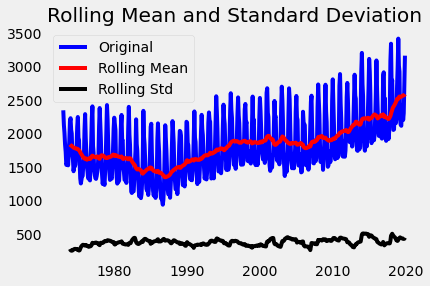

In [86]:
dftest(usngpdpro)

The DF test reveals that the series is non-stationary, due to the time-varying trend. The mean is time varying even though the standard deviation remains fairly constant.

In [15]:
import statsmodels.api as sm
def plots(data, lags=None):
    plt.figure(figsize = (15,10))
    layout = (5, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

## Making the series stationary

**Detrending**

Removing the underlying trend can make a series stationary, if the residual which is left is stationary. A time series model can then be applied to the residual and then transformed back to the original series by adding or multiplying the residual with the trend. If the magnitude of the seasonality is independent of trend, an additive model can be used, otherwise, a multiplicative seasonal decomposition would be preferred. If there is a seasonal component, the residual and seasonal component can be combined as a stationary residual for modelling.

<AxesSubplot:xlabel='Month'>

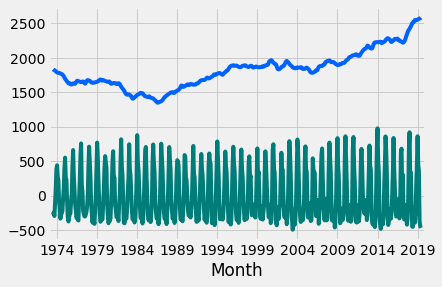

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=usngpdpro, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
usngpdpro_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
estimated_trend.plot()
(usngpdpro_).plot() #Residual + Stationary

Test Statistic          -9.3
p-value                  0.0
Lags Used               19.0
Observations Used      532.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


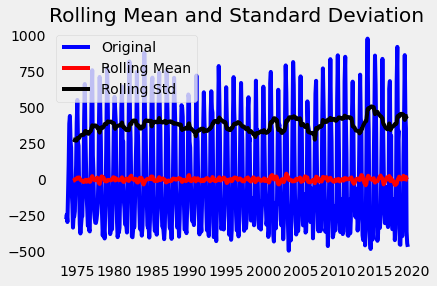

In [88]:
dftest(usngpdpro_)

**Differencing**

Another way of making a series stationary is subtracting the time series at a different-lag from the time-series. For example, a series with a constant trend is non-stationary but the differenced series, with units of change/time would be stationary. However, for other series, e.g. hederoskedastic or those with non-stationary residuals, it may require processes such as taking the log of the series or transforming the series into ARMA, ARIMA or SARIMA models of the series, the latter two of which involve differencing. 

Test Statistic          -8.5
p-value                  0.0
Lags Used               13.0
Observations Used      549.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


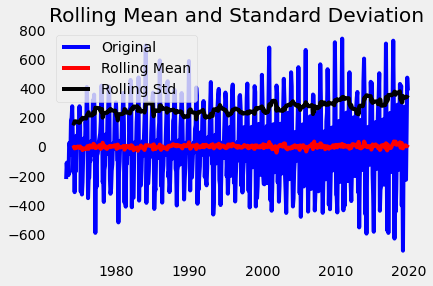

In [89]:
dftest(usngpdpro.diff().dropna())

## Holt's Exponential Smoothing 

Holt's triple exponential smoothing is a moving average technique which provies forecasts as weighting averages of past observation and can pick up on trend and seasonality. 

MSE: 35140.78606163715 R-Squared: 0.8038983878991925


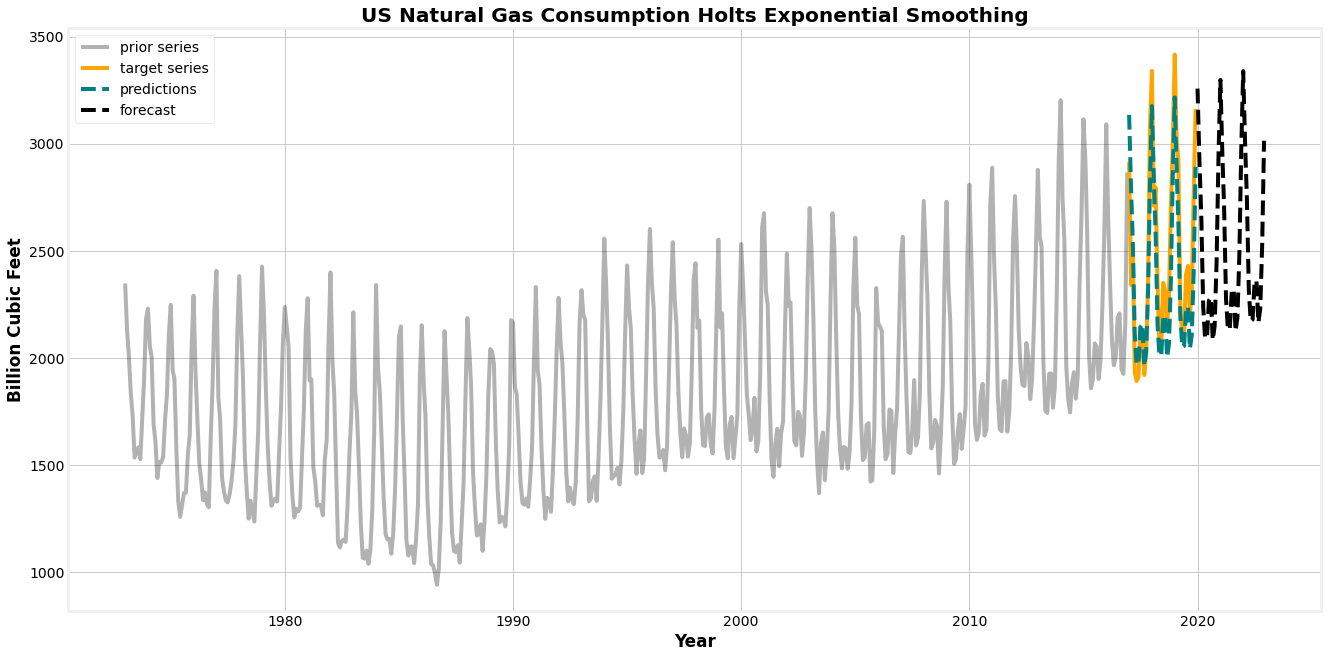

In [90]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(usngpdpro[:-36],
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(usngpdpro[-36:]) + 36)
triple_mse = mse(usngpdpro[-36:], triple_preds[:-36])
triple_r2 = r2(usngpdpro[-36:], triple_preds[:-36])
print('MSE:', triple_mse, 'R-Squared:', triple_r2)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(usngpdpro[:-36], color = 'black', alpha = 0.3, label = 'prior series')
ax.plot(usngpdpro[-36:], color = 'orange', label = 'target series')
ax.plot(triple_preds[:-36], color = 'teal', linestyle = 'dashed', label = 'predictions')
ax.plot(triple_preds[-36:], color = 'black', linestyle = 'dashed', label = 'forecast')
ax.legend(loc = 'best', facecolor = 'white')
ax.set_title('US Natural Gas Consumption Holts Exponential Smoothing', fontweight = 'bold')
ax.set_ylabel('Billion Cubic Feet', fontweight = 'bold')
ax.set_xlabel('Year', fontweight = 'bold')
fig.set_facecolor('white')
ax.set_facecolor('white')



**Autocorrelation and Partial Autocorrelation Function**

Non-stationary time series e.g. exponential growth/decline (e.g. Covid-19) may be correlated with certain time-lag versions of itself. I.e. for certain sections of the time-series, it will increase or decrease with a dependency on a previous time-step. To produce a stationary time series a stationary model incorporating these time-lag dependencies needs to be produced and then a prediction can be made on the stationary series. ACF and PACF are used to identify which time-lags a series is autocorrelated to. The auto-correlation measures the correlation of a series with itself at different time lag, and partial auto-correlation measures the correlation of time-lag versions of the series with other time-lags of the series. Certain time-lags on the ACF and PACF plots can then be used as parameters for modeling a stationary version of the time-series using ARMA, ARIMA or SARIMA models. 


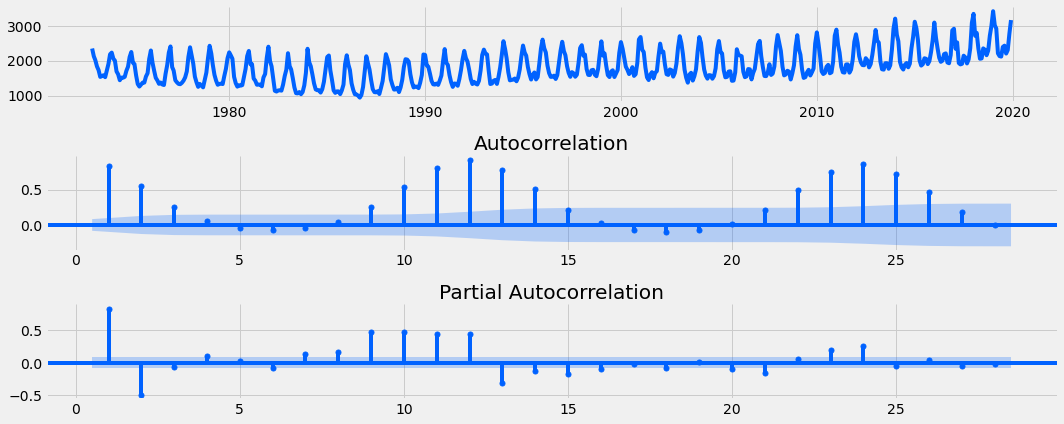

In [91]:
plots(usngpdpro)

We can see from the ACF plot that this time series is periodically correlated by its time-lags with maximum auto-correlation with every 12th month. So every 12-months, the time series looks almost exactly like the series from the one 12-months ago. Thus it has a seasonal period of 12. To make the series stationary, a first step would be to perform 12-month seasonal difference which would reduce its correlation to other time lags. Then we can observe its correlation with other time lags with respect to lag-12 or itself or if any other differencing is required 

###  **ARMA, ARIMA and SARIMA Models**

-fill section-

Producing one of these models removes leaves a stationary residual. The model can then predict using the stationary series and an inverse transform is applied within the algorithm to produce a prediction on the original series. 

**Auto-ARIMA**

In [ ]:
usngpdpro_model = pm.auto_arima(usngpdpro, start_p=0, start_q=0,
                           max_p=2, max_q=2, start_d=0, max_d=1, m=12,
                           start_P=0, start_Q=0, max_P = 1, max_Q = 1, seasonal=True,
                            D=1, max_D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(usngpdpro_model.aic())

**Chosen Model**

The Auto-Arima function indicates that the best model is a SARIMA (1,1,2), (1,1,1,12) model. We choose a SARIMA model with (p,d,q) = (1,1,2) and (P,D,Q, M) = (1,1,1,12). -Show sequential screenshots to reach these parameters-

In [ ]:
usngpdproarima = sm.tsa.statespace.SARIMAX(usngpdpro,     ##hhgas
                                order=(1,1,1), 
                                seasonal_order=(1,1,1,12), ##None
                                trend='c').fit()
usngpdproarima.summary()

In [ ]:
plots(usngpdproarima.resid[usngpdproarima.loglikelihood_burn:])

In [ ]:
dftest(usngpdproarima.resid)

In [20]:
def cross_validate(series,horizon,start,step_size,order, seasonal_order,trend):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(list(model.forecast(steps = horizon))[-1]) #forecasting horizon steps into the future
        actual.append(series.iloc[i+horizon].values[0]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [21]:
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

### Forecast Tuning 

For the SARIMA model, I select the forecast horizon, forecast step size (how often the forecast is calculated) and start year which produces the most accurate forecast. 

In [23]:
'''Function for SARIMA '''
def evaluate_arima(series, horizon, start_year, step_size, order, seasonal_order, trend):
    best_mape = np.inf
    best_horizon = None
    best_year = None
    best_step_size = None
    best_trend = None
    for i in horizon:
        for j in start_year:
            for k in step_size:
                for l in trend:
                    cv= cross_validate(series, i, j, k, order, seasonal_order, trend)
                    if mape(cv) < best_mape:
                        best_mape = mape(cv)
                        best_horizon = i
                        best_year = j
                        best_step_size = k
                        best_trend = l
                
    return (best_horizon, best_year, best_step_size, best_mape)

In [ ]:
series = usngpdpro
horizon = [3, 6] #the period of time for which forcast will be calculated
forecast_length = [1,2]
start_year = [len(series)-(12*forecast_length[0]), len(series)-(12*forecast_length[1])]
step_size = [6, 12] #how often (months) forecast will be recalculated
order = (1,1,1)
seasonal_order = (1,1,1,12)
trend = [None,'c']

In [ ]:
evaluate_arima(series, horizon, start_year, step_size, order, seasonal_order, trend)

In [ ]:
series = usngpdpro
horizon = 12 #the period of time for which forcast will be calculated
forecast_length = 3
start_year = len(series)-(12*forecast_length)
step_size = 6 #how often (months) forecast will be recalculated
order = (1,1,1)
seasonal_order = (1,1,1,12)
trend = 'c'

In [ ]:
us_ngpd_cv = cross_validate(series, 3, 540, 3, (1,1,1), (1,1,1,12), 'c')
us_ngpd_cv.plot()

In [ ]:
mape(us_ngpd_cv)

In [ ]:
usngpdproforecast = usngpdproarima.get_forecast(steps = 100, dynamic = True)
usngpdproforecast = usngpdproforecast.summary_frame()
usngpdproforecast.rename(columns = {'mean':'forecast'}, inplace = True)
predict_usngpdpro = pd.DataFrame(usngpdproarima.predict(dynamic = False))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
fig2, ax2 = plt.subplots(figsize=(15, 10))
ax.plot(usngpdpro[-50:], color = 'blue', label = 'original series')
ax.plot(predict_usngpdpro[-50:], color = 'red', label = 'in sample prediction full series')
ax2.plot(us_ngpd_cv.fcst, color = 'red', linestyle = 'dashed', label = 'in-sample forecast on forecast interval')
ax2.plot(us_ngpd_cv.actual, color = 'blue', linestyle = 'dashed', label = 'in-sample forecast interval ({} month sampling interval)'.format(step_size))
# Construct the forecasts
usngpdproforecast['forecast'].plot(ax=ax, color='black', linestyle = 'dashed') #'dashed') #style = 'k--')
ax.fill_between(usngpdproforecast.index, usngpdproforecast['mean_ci_lower'], usngpdproforecast['mean_ci_upper'], color='green', alpha=0.3, label = 'confidence interval 95%');
ax.legend()
ax.set_title('US Natural Gas Consumption', fontsize =20)
usngpdproforecast['forecast'].plot(ax=ax2, color='black', linestyle = 'dashed') #'dashed') #style = 'k--')
ax2.fill_between(usngpdproforecast.index, usngpdproforecast['mean_ci_lower'], usngpdproforecast['mean_ci_upper'], color='green', alpha=0.3, label = 'confidence interval 95%');
ax2.legend()
ax2.set_title('US Natural Gas Consumption', fontsize =20)

In [24]:
def grid_search_ARIMA(series,horizon,start,step_size,orders,seasonal_orders,trends):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv)<best_mape:
                    best_mape = mape(cv)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, best_mape)

In [ ]:
series = np.array(usngpdpro, dtype = 'float64')
horizon = best_horizon
start = best_year
step_size = best_step_size
orders = [(1,0,0), (1,0,1), (0,0,1), (0,1,1)]
seasonal_orders = [(0,1,1,12), (0,1,0, 12)]
trends = [None, 'c']
#grid_search_ARIMA(series,horizon,start,step_size,orders = orders,seasonal_orders = seasonal_orders,trends=trends)

###  **USING RECURRENT NEURAL NETWORKS**

Aside from ARMA, ARIMA and SARIMA models, Recurrent Neural Networks can be used to predict time series. 

In this model we'll use the last n years of the series, as a prediction set, and use a portion of the series to train an RNN to predict the next time step for every time step in the target portion of the series. In the training set, each training sample will be a portion of the series of a certain number of time steps, used to predict the next time step. This prediction is then added to the end of the next sample and used to predict the next time step in a rolling fashion until the end of training set. The sampling interval can also vary which will determine how many samples are selected. The training samples form a tensor of the format, *(number of samples, number of timesteps, number of features)*, used to predict a number of timesteps which form a tensor of the format *(number of timesteps, number of features)* over the remaining length of the target portion of the training set. In the test portion, after the model has been trained, an initial series of a given number of timesteps, a tensor of the format *(number of timesteps, number of features)* is used to predict the next series of time steps in the remaining section of the test set. 

Although an RNN don't necessarily require a series to be stationary, this can improve their ability to make accurate predictions. I made the series stationary by removing the trend, so that the last n years is more predictable. Additionally, for the RNN to function, normalization was performed to scale the the values between 0 and 1. The RNN model predicted the timesteps in the target section and the whole series including the predictions was inverse normalized and added to the trend to produce predictions on the original time series. 

In [25]:
'''Transforming series to 3D input (samples, timesteps, features)'''

def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)
 # reducing our forecast series to last n days


In [26]:
'''Selecting Modelling Data'''

class GETDATA:
    def __init__(self, df, series_name, series_years, input_months, 
                    test_months, sample_gap):

        self.df = df
        self.series_name = series_name
        self.series_years = series_years
        self.input_months = input_months
        self.test_months = test_months
        self.sample_gap = sample_gap
        
    def get_n_last_years(self):
        """
        Extract last n_days of a monthly time series
        """
    
        return self.df[self.series_name][-int(round((12*self.series_years))):] #24*

    def plot_n_last_years(self):
        """
        Plot last n_days of an hourly time series 
        """
        plt.figure(figsize = (10,5))   
        plt.plot(get_n_last_years(self), 'k-')
        plt.title('{0} Air Quality Time Series - {1} Years'
              .format(self.series_name, self.series_years))
        plt.xlabel('Recorded Hour')
        plt.ylabel('Reading')
        plt.grid(alpha=0.3)
    
    def get_keras_format_series(self):
        """
        Convert a series to a numpy array of shape 
        [n_samples, time_steps, features]
        """
    
        self.series = np.array(self.series)
        return series.reshape(self.series.shape[0], self.series.shape[1], 1)
     # reducing our forecast series to last n days

    def get_train_test_data(self):
        """
        Utility processing function that splits an hourly time series into 
        train and test with keras-friendly format, according to user-specified
        choice of shape.    
    
        arguments
        ---------
        df (dataframe): dataframe with time series columns
        series_name (string): column name in df
        series_days (int): total days to extract
        input_hours (int): length of sequence input to network 
        test_hours (int): length of held-out terminal sequence
        sample_gap (int): step size between start of train sequences; default 5
    
        returns
        ---------
        tuple: train_X, test_X_init, train_y, test_y     
        """
        #forecast_series = df[series_name].values
        forecast_series = sc.fit_transform(pd.DataFrame(self.get_n_last_years().values))
        train = forecast_series[:-self.test_months] # training data is remaining days until amount of test_hours
        test = forecast_series[-self.test_months:] # test data is the remaining test_hours

        train_X, train_y = [], []

        # range 0 through # of train samples - input_hours by sample_gap. 
        # This is to create many samples with corresponding
        for i in range(0, train.shape[0]-self.input_months, self.sample_gap): 
            train_X.append(train[i:i+self.input_months]) # each training sample is of length input hours
            train_y.append(train[i+self.input_months]) # each y is just the next step after training sample
            
        train_X = get_keras_format_series(train_X) # format our new training set to keras format
        train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
        # The set that we had held out for testing (must be same length as original train input)
        test_X_init = test[:self.input_months] 
        test_y = test[self.input_months:] # test_y is remaining values from test set
    
        return train_X, test_X_init, train_y, test_y

In [27]:
class FIT:
    def __init__(self, train_X, train_y, dropout, recurrent_dropout, cell_units,  cell_units_l2, epochs): #n_steps = len(test_y)
        self.train_X = train_X
        self.train_y = train_y
        self.cell_units = cell_units
        self.cell_units_l2 = cell_units_l2
        self.epochs = epochs
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
    
    def LSTM(self):
        """
        Fit LSTM to data train_X, train_y 
    
        arguments
        ---------
        train_X (array): input sequence samples for training 
        train_y (list): next step in sequence targets
        cell_units (int): number of hidden units for LSTM cells  
        epochs (int): number of training epochs   
        """
    
        # initialize model
        model = Sequential() 
    
        # construct a LSTM layer with specified number of hidden units
        # per cell and desired sequence input format 
        model.add(LSTM(self.cell_units, dropout=self.dropout, recurrent_dropout=self.recurrent_dropout, input_shape=(self.train_X.shape[1],1),return_sequences= True))
        model.add(LSTM(self.cell_units_l2))
        #, input_shape=(train_X.shape[1],1)))
        # add an output layer to make final predictions 
        model.add(Dense(1))
    
        # define the loss function / optimization strategy, and fit
        # the model with the desired number of passes over the data (epochs) 
        model.compile(loss='mean_squared_error', optimizer='adam')
        if train_X.shape[0]%4 == 0:
            valx, valy = self.train_X[-(2*int(self.train_X.shape[0]/4)):-int(self.train_X.shape[0]/4)], self.train_X[0][-int(self.train_X.shape[0]/4):]
            history = model.fit(self.train_X, self.train_y, epochs=self.epochs, validation_split = (0.25), shuffle = False, batch_size=int(train_X.shape[0]/4), verbose=1) #
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model train vs validation loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper right')
            plt.show()
            #loss = history.history['loss']
            #val_loss = history.history['val_loss']
            return model
            #return loss, val_loss
        else:
            print('input month is not a multiple of 4. Cannot divide into integer batches')


In [28]:
'''Trend is fairly constant, stationary residual'''

class PREDICT:
    def __init__(self, X_init, test_X_init,  n_steps, test_y,  model,  prior, test_months, title, plot=bool):
        self.X_init = X_init
        self.test_y = test_y
        self.n_steps = n_steps
        self.model = model
        self.prior = prior
        self.test_months = test_months
        self.title = title
        self.test_X_init = test_X_init 
        self.plot = plot
    def predict(self):
        """
        Given an input series matching the model's expected format,
        generates model's predictions for next n_steps in the series      
        """
        self.X_init = self.X_init.copy().reshape(1,-1,1)
        preds = []
    
        # iteratively take current input sequence, generate next step pred,
        # and shift input sequence forward by a step (to end with latest pred).
        # collect preds as we go.
        for _ in range(self.n_steps):
            pred = self.model.predict(self.X_init)
            preds.append(pred)
            self.X_init[:,:-1,:] = self.X_init[:,1:,:] # replace first 11 values with 2nd through 12th
            self.X_init[:,-1,:] = pred # replace 12th value with prediction
    
        preds = np.array(preds).reshape(-1,1)
    
        return preds
 
    
    def predict_and_plot(self):
        """
        Given an input series matching the model's expected format,
        generates model's predictions for next n_steps in the series,
        and plots these predictions against the ground truth for those steps 
    
        arguments
        ---------
        X_init (array): initial sequence, must match model's input shape
        y (array): true sequence values to predict, follow X_init
        model (keras.models.Sequential): trained neural network
        title (string): plot title   
        """
    
        y_preds = self.predict() # predict through length of y
        # Below ranges are to set x-axes
        start_range = range(0, self.prior.shape[0]) #starting at one through to length of test_X_init to plot X_init
        init_range = range(self.prior.shape[0], self.prior.shape[0]+len(self.test_X_init))
        predict_range = range(self.prior.shape[0]+len(self.test_X_init), self.prior.shape[0]+len(self.test_X_init)+len(self.test_y))  #predict range is going to be from end of X_init to length of test_hours
       # predict_range_pred = 
        #using our ranges we plot X_init
        forecast_range = range(self.prior.shape[0]+len(self.test_X_init)+len(self.test_y), self.prior.shape[0]+len(self.test_X_init)+len(self.test_y)+self.n_steps-len(self.test_y))
        '''Inverse Normalize and Inverse Difference the Data'''
        if self.plot == True:
            plt.figure(figsize = (15, 6))
            prior = np.array(self.prior)
            plt.plot(start_range, prior, color = 'black', alpha = 0.3) #self.prior
            init_series = sc.inverse_transform(self.test_X_init)
            plt.plot(init_range, init_series, color = 'green') #sc.inverse_transform(self.test_X_init)
            #and test and actual preds
            target =  sc.inverse_transform(self.test_y)
            if self.n_steps > len(self.test_y):
                plt.plot(predict_range, target, color='orange')
                predictions = sc.inverse_transform(y_preds[:-(self.n_steps-len(self.test_y))])
                plt.plot(predict_range ,predictions, color='teal', linestyle='--') 
                forecast = sc.inverse_transform(y_preds[-(self.n_steps-len(self.test_y)):])
                plt.plot(forecast_range , forecast, color='black', linestyle='--')
                plt.title(self.title)
                plt.legend(['Full Series', 'Initial Series','Target Series','Predictions'])
                return prior, init_series, target, predictions, forecast
            else:
                plt.plot(predict_range, target, color='orange') 
                predictions = sc.inverse_transform(y_preds)
                plt.plot(predict_range ,predictions, color='teal', linestyle='--') 
                plt.title(self.title)
                plt.legend(['Full Series', 'Initial Series','Target Series','Predictions'])
                print(target)
                return prior, init_series, target, predictions
    
        else:
            prior = np.array(self.prior)
            init_series = sc.inverse_transform(self.test_X_init)
            target =  sc.inverse_transform(self.test_y)
            if self.n_steps > len(self.test_y):
                predictions = sc.inverse_transform(y_preds[:-(self.n_steps-len(self.test_y))])
                forecast = sc.inverse_transform(y_preds[-(self.n_steps-len(self.test_y)):])
                return prior, init_series, target, predictions, forecast
            else:
                predictions = sc.inverse_transform(y_preds)
                return prior, init_series, target, predictions
        

In [29]:
'''Use for predicting a time-varying trend by differencing the trend, or for seris where the residual is non-stationary and differencing is required'''

class PREDICT_DIFF:
    def __init__(self, X_init, test_X_init,  n_steps, test_y,  model,  prior, prior_origin,  test_months,  title, plot=bool):
        self.X_init = X_init
        self.test_y = test_y
        self.n_steps = n_steps
        self.model = model
        self.prior = prior
        self.prior_origin = prior_origin

        self.test_months = test_months
     
        self.title = title
        self.test_X_init = test_X_init 

        self.plot = plot
    def predict(self):
        """
        Given an input series matching the model's expected format,
        generates model's predictions for next n_steps in the series      
        """
        self.X_init = self.X_init.copy().reshape(1,-1,1)
        preds = []
    
        # iteratively take current input sequence, generate next step pred,
        # and shift input sequence forward by a step (to end with latest pred).
        # collect preds as we go.
        for _ in range(self.n_steps):
            pred = self.model.predict(self.X_init)
            preds.append(pred)
            self.X_init[:,:-1,:] = self.X_init[:,1:,:] # replace first 11 values with 2nd through 12th
            self.X_init[:,-1,:] = pred # replace 12th value with prediction
    
        preds = np.array(preds).reshape(-1,1)
    
        return preds
    
    def predict_and_plot(self):
        """
        Given an input series matching the model's expected format,
        generates model's predictions for next n_steps in the series,
        and plots these predictions against the ground truth for those steps 
    
        arguments
        ---------
        X_init (array): initial sequence, must match model's input shape
        y (array): true sequence values to predict, follow X_init
        model (keras.models.Sequential): trained neural network
        title (string): plot title   
        """
    
        y_preds = self.predict() # predict through length of y
        # Below ranges are to set x-axes
        start_range = range(0, self.prior_origin.shape[0]) #starting at one through to length of test_X_init to plot X_init
        init_range = range(self.prior_origin.shape[0], self.prior_origin.shape[0]+len(self.test_X_init))
        predict_range = range(self.prior.shape[0]+len(self.test_X_init), self.prior.shape[0]+len(self.test_X_init)+len(self.test_y))  #predict range is going to be from end of X_init to length of test_hours
       # predict_range_pred = 
        #using our ranges we plot X_init
        forecast_range = range(self.prior.shape[0]+len(self.test_X_init)+len(self.test_y), self.prior.shape[0]+len(self.test_X_init)+len(self.test_y)+self.n_steps-len(self.test_y))
        '''Inverse Normalize and Inverse Difference the Data'''
        if self.plot == True:
            plt.figure(figsize = (15, 6))
            prior = np.r_[self.prior_origin[0].reshape(self.prior_origin[0].shape[0],1), np.array(self.prior)].cumsum()
            plt.plot(start_range, prior, color = 'black', alpha = 0.3) #self.prior
            init_series = np.r_[self.prior_origin[-1].reshape(self.prior_origin[-1].shape[0],1), sc.inverse_transform(self.test_X_init)].cumsum()[1:] 
            plt.plot(init_range, init_series, color = 'green') #sc.inverse_transform(self.test_X_init)
            #and test and actual preds
            target =  np.r_[init_series[-1].reshape(1,1), sc.inverse_transform(self.test_y)].cumsum()[1:]
            if self.n_steps > len(self.test_y):
                plt.plot(predict_range, target, color='orange')
                predictions = np.r_[target[0].reshape(1,1),sc.inverse_transform(y_preds[:-(self.n_steps-len(self.test_y))])[1:]].cumsum()
                plt.plot(predict_range ,predictions, color='teal', linestyle='--') 
                forecast = np.r_[predictions[-1].reshape(1,1),sc.inverse_transform(y_preds[-(self.n_steps-len(self.test_y)):])].cumsum()[1:]
                plt.plot(forecast_range , forecast, color='black', linestyle='--')
                plt.title(self.title, fontweight = 'bold')
                plt.legend(['Full Series', 'Initial Series','Target Series','Predictions'])

                return prior, init_series, target, predictions, forecast
            else:
                plt.plot(predict_range, target, color='orange')
                predictions = np.r_[target[0].reshape(1,1),sc.inverse_transform(y_preds)[1:]].cumsum()
                plt.plot(predict_range ,predictions, color='teal', linestyle='--')
                plt.title(self.title, fontweight = 'bold')
                plt.legend(['Full Series', 'Initial Series','Target Series','Predictions'])
                print(target)
                return prior, init_series, target, predictions
    
        else:
            init_series = np.r_[self.prior_origin[-1].reshape(self.prior_origin[-1].shape[0],1), sc.inverse_transform(self.test_X_init)].cumsum()[1:] 
            target =  np.r_[init_series[-1].reshape(1,1), sc.inverse_transform(self.test_y)].cumsum()[1:]
            if self.n_steps > len(self.test_y):
                predictions = np.r_[target[0].reshape(1,1),sc.inverse_transform(y_preds[:-(self.n_steps-len(self.test_y))])[1:]].cumsum()
                forecast = np.r_[predictions[-1].reshape(1,1),sc.inverse_transform(y_preds[-(self.n_steps-len(self.test_y)):])].cumsum()[1:]
                return prior, init_series, target, predictions, forecast
            else:
                predictions = np.r_[target[0].reshape(1,1),sc.inverse_transform(y_preds)[1:]].cumsum()
                return prior, init_series, target, predictions 

In [30]:
'''Model Evaluation'''

from sklearn.metrics import mean_squared_error, r2_score
class Scores: 
    def __init__(self, true, predicted):
        self.true = true
        self.predicted = predicted
    def scores(self):
        mse = mean_squared_error(self.true, self.predicted)
        r2 = r2_score(self.true, self.predicted)
        return mse, r2
        
    def df(self):
        scores = pd.DataFrame(columns = (['Actual', 'Predicted']))
        for i in range(len(self.true)):
            scores.loc[i, 'Actual'] = self.true[self.true.columns[-1]][i]
            scores.loc[i, 'Predicted'] = self.predicted[self.predicted.columns[-1]][i]
            scores.loc[i, 'Error'] =self.predicted[self.predicted.columns[-1]][i]-self.true[self.true.columns[-1]][i]
            scores['Percent Error'] =(abs(scores['Error']/scores['Actual']))*100
        return scores

First seasonally decompose the time series into trend, seasonal and residual. The residual and trend components are missing the first 6 months and last six months of data so these dates are removed for modelling

<AxesSubplot:xlabel='Month'>

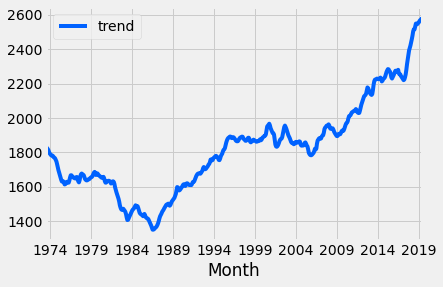

In [31]:
usngpdpro_ = pd.DataFrame(usngpdpro_)#[6:-6])
usngpdpro_trend = pd.DataFrame(estimated_trend[6:-6])
usngpdpro_seasonal = pd.DataFrame(estimated_seasonal[6:-6])
usngpdpro_residual = pd.DataFrame(estimated_residual[6:-6])
usngpdpro_trend.plot()

In [419]:
sc = MinMaxScaler(feature_range = (0,1))
df = usngpdpro_
input_months=12 #sample size
test_months = 48 #test portion of forecast series in months
n_steps = 72
sample_gap = 1
series_name = usngpdpro_[usngpdpro_.columns[0]].name
series_years = 10  #forecast series length
prior = df[:-test_months]
title = 'US Natural Gas Consumption'

**Hyperparameter Tuning**

In order to select the model which had the best accuracy, a grid search of a range of parameters was performed. Sample sizes in the test set, which are multiples of 6 months, in the range of 12 to 60 months were varied. The size of test set was also varied from 18 months to 78 months. The last n years of the series, which defines the forecast interval was kept constant, which constrained the size of the test set. Dropout was either 0, or 0.2 for (the input layer) and the recurrent dropout. The number of epochs was kept constant during the hyperparameter tuning process. The number of cell-units for the LSTM hidden layers was calculated using the following formula 

In [93]:
no_of_samples = []
SAMPLE = []
TEST = []
GAP = []
years = 12
sample_size = [12, 18, 24, 30, 36, 42, 48, 54, 60]
test_size =[18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78]
gap =[1,2, 3, 4, 5, 6]
for i, j in enumerate(sample_size):
    for k, l in enumerate(test_size):
        for m, n in enumerate(gap):
            no_of_samples.append((12*years-l-j)/n)
            SAMPLE.append(j)
            TEST.append(l)
            GAP.append(n)
no_of_samples = pd.DataFrame(no_of_samples)
no_of_samples.insert(0,'SAMPLE SIZE', SAMPLE)
no_of_samples.insert(1,'TEST_SIZE',TEST)
no_of_samples.insert(2,'GAP',GAP)

no_of_samples.rename(columns = {0:'Number of Samples'}, inplace = True)
no_of_samples = no_of_samples.sort_values(by = 'Number of Samples', ascending = False)
no_of_samples = no_of_samples[no_of_samples['Number of Samples']>=20]
no_of_samples = no_of_samples[(no_of_samples['TEST_SIZE']-no_of_samples['SAMPLE SIZE'])<= no_of_samples['SAMPLE SIZE']]
no_of_samples = no_of_samples[no_of_samples['Number of Samples']%12 == 0]
no_of_samples = no_of_samples[(no_of_samples['TEST_SIZE']-no_of_samples['SAMPLE SIZE'])>0]
SAMPLER_NEW = []
sampler = np.array(no_of_samples[2:])
for i in np.arange(len(sampler)):
    paramaters  = (sampler[i][0], sampler[i][1], sampler[i][2])
    SAMPLER_NEW.append(paramaters)
    
SAMPLER_NEW

[(24.0, 36.0, 1.0),
 (24.0, 48.0, 1.0),
 (30.0, 42.0, 1.0),
 (30.0, 54.0, 1.0),
 (36.0, 48.0, 1.0),
 (18.0, 30.0, 2.0),
 (36.0, 60.0, 1.0),
 (42.0, 54.0, 1.0),
 (48.0, 60.0, 1.0),
 (30.0, 42.0, 2.0),
 (42.0, 66.0, 1.0),
 (24.0, 48.0, 2.0),
 (36.0, 72.0, 1.0),
 (12.0, 24.0, 3.0),
 (54.0, 66.0, 1.0),
 (42.0, 78.0, 1.0),
 (48.0, 72.0, 1.0),
 (42.0, 54.0, 2.0),
 (24.0, 48.0, 3.0),
 (36.0, 60.0, 2.0),
 (30.0, 42.0, 3.0),
 (18.0, 30.0, 4.0)]

In [310]:
evaluate = []
DROPOUT = []
RECURRENT_DROPOUT = []
dropout = [0, 0.2]
recurrent_dropout = [0, 0.2]
INPUTS = []
TESTS = []
GAP_ = []
CELL_UNITS = []
series_years = 12

In [117]:
def lstm_tuning(data, title):
    best_error = np.inf
    best_sample = None
    best_dropout  = None
    best_recurrent_dropout = None
    best_cell_units = None
    for a,b in enumerate(sampler[0:3]):
        for i,j in enumerate(dropout):
            for k,l in enumerate(recurrent_dropout):
                df = data
                prior = df[:-int(SAMPLER_NEW[a][1])]
                dataset = GETDATA(df, series_name, series_years, int(SAMPLER_NEW[a][0]), 
                int(SAMPLER_NEW[a][1]), int(SAMPLER_NEW[a][2]))
                train_X, test_X_init, train_y, test_y = \
                dataset.get_train_test_data()
                n_steps = len(test_y)
                NO = n_steps
                NI = test_X_init.shape[0]
                R = (NI/NO)**(1/3)
                H1 = int(np.round(NO*(R**2)))
                H2 = int(np.round(NO*R))
                model = FIT(train_X, train_y, j, l,H1, H2, 5)
                model = model.LSTM()
                predict = PREDICT(test_X_init, test_X_init, n_steps, test_y, model, np.array(prior), int(SAMPLER_NEW[a][1]), title, False)
                predict = predict.predict_and_plot()
                if n_steps > len(test_y):   
                    predict_ = pd.DataFrame(predict[3])
                    predict_.index = data.index[-len(predict_):]
                    forecast = pd.DataFrame(predict[4])
                    forecast.index = data.index.shift(len(data), 'M')[0:len(forecast)]
                else:
                    predict_= pd.DataFrame(predict[3]) 
                    predict_.index = data.index[-len(predict_):]
                true = data[-int((sampler[a][1]-sampler[a][0])):]
                score = Scores(true, predict_)
                scores = score.scores()
                score_df = score.df()
                evaluate.append(scores)
                DROPOUT.append(j)
                RECURRENT_DROPOUT.append(l)
                INPUTS.append(sampler[a][0])
                TESTS.append(sampler[a][1])
                GAP_.append(sampler[a][2])
                CELL_UNITS.append([H1,H2])
                print(b, j, l, H1, H2, scores)
                if scores[0] < best_error:
                    best_error = scores[0]
                    best_R2 = scores[1]
                    best_sample = b
                    best_dropout  = j
                    best_recurrent_dropout = l
                    best_cell_units = (H1, H2)
    return best_sample, best_dropout, best_recurrent_dropout, best_cell_units, (best_error, best_R2)

In [ ]:
lstm_tuning(usngpdpro_, 'test')

In [ ]:
evaluation = pd.DataFrame(evaluate)
evaluation.insert(0,'DROPOUT', DROPOUT)
evaluation.insert(1,'RECURRENT_DROPOUT', RECURRENT_DROPOUT)
evaluation.insert(2,'INPUTS', INPUTS)
evaluation.insert(3,'TEST', TESTS)
evaluation.insert(4,'GAP', GAP_)
evaluation.insert(5, 'Cell Units', CELL_UNITS)
evaluation.rename(columns = {0:'MSE', 1:'R-Squared'}, inplace = True)
evaluation = evaluation.sort_values(by = 'MSE', ascending = True)
evaluation.to_csv('evaluation_01_09b.csv')

In [ ]:
evaluation = pd.read_csv('evaluation_01_09b.csv')
evaluation

Select the number of epochs for training the model corresponding to the crossover point between training accuracy and validation accuracy. 

no of samples 60.0
Train on 45 samples, validate on 15 samples
Epoch 1/40
45/45 [==============================] - 39s 856ms/step - loss: 0.1835 - val_loss: 0.1303
Epoch 2/40
45/45 [==============================] - 1s 18ms/step - loss: 0.1403 - val_loss: 0.1062
Epoch 3/40
45/45 [==============================] - 1s 20ms/step - loss: 0.1054 - val_loss: 0.0958
Epoch 4/40
45/45 [==============================] - 1s 20ms/step - loss: 0.0842 - val_loss: 0.1064
Epoch 5/40
45/45 [==============================] - 1s 19ms/step - loss: 0.0842 - val_loss: 0.1257
Epoch 6/40
45/45 [==============================] - 1s 16ms/step - loss: 0.0924 - val_loss: 0.1236
Epoch 7/40
45/45 [==============================] - 1s 21ms/step - loss: 0.0897 - val_loss: 0.1105
Epoch 8/40
45/45 [==============================] - 1s 21ms/step - loss: 0.0844 - val_loss: 0.1007
Epoch 9/40
45/45 [==============================] - 1s 20ms/step - loss: 0.0826 - val_loss: 0.0960
Epoch 10/40
45/45 [=========================

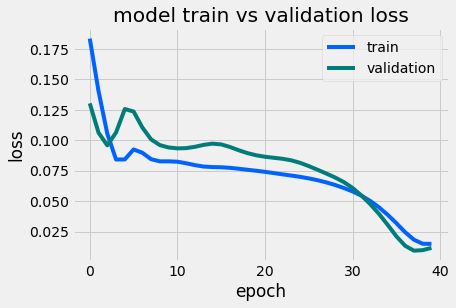

In [420]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y = \
data.get_train_test_data()
No = n_steps
Ni = test_X_init.shape[0]
R_ = (Ni/No)**(1/3)
h1 = int(np.round(No*(R_**2)))
h2 = int(np.round(No*R_))
fit = FIT(train_X, train_y, 0, 0, h1, h2, 40) 
print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
model = fit.LSTM()

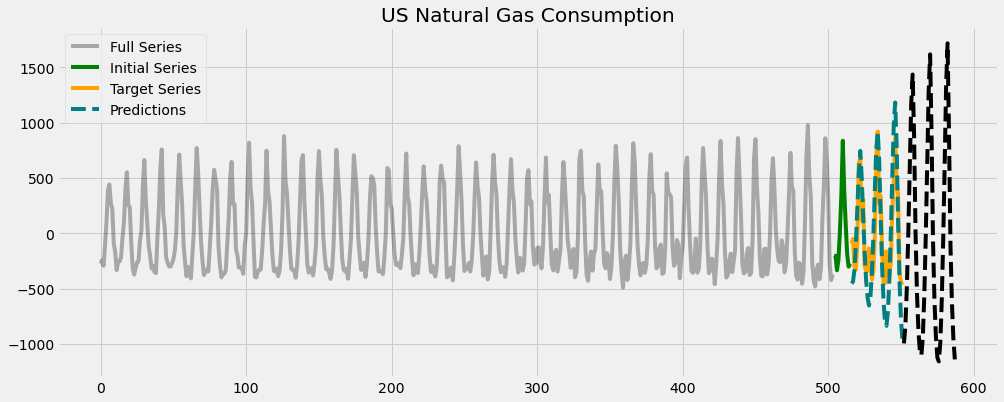

In [421]:
predict = PREDICT(test_X_init, test_X_init,  n_steps, test_y, model, prior, test_months,  'US Natural Gas Consumption', True)
predict = predict.predict_and_plot()

**Forecast the trend beyond the length of the series by predicting over the length of the target series and the forecast zone so that the predicted forecast of the residual can be added to the predicted forecast of the trend. The forecast zone for the trend is modified to capture the most relevant trend.

no of samples 60.0
Train on 63 samples, validate on 21 samples
Epoch 1/40
63/63 [==============================] - 38s 608ms/step - loss: 0.0850 - val_loss: 0.1747
Epoch 2/40
63/63 [==============================] - 1s 15ms/step - loss: 0.0642 - val_loss: 0.1377
Epoch 3/40
63/63 [==============================] - 1s 13ms/step - loss: 0.0456 - val_loss: 0.1024
Epoch 4/40
63/63 [==============================] - 1s 15ms/step - loss: 0.0293 - val_loss: 0.0699
Epoch 5/40
63/63 [==============================] - 1s 15ms/step - loss: 0.0168 - val_loss: 0.0425
Epoch 6/40
63/63 [==============================] - 1s 16ms/step - loss: 0.0097 - val_loss: 0.0231
Epoch 7/40
63/63 [==============================] - 1s 14ms/step - loss: 0.0087 - val_loss: 0.0132
Epoch 8/40
63/63 [==============================] - 1s 13ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 9/40
63/63 [==============================] - 1s 13ms/step - loss: 0.0130 - val_loss: 0.0103
Epoch 10/40
63/63 [=========================

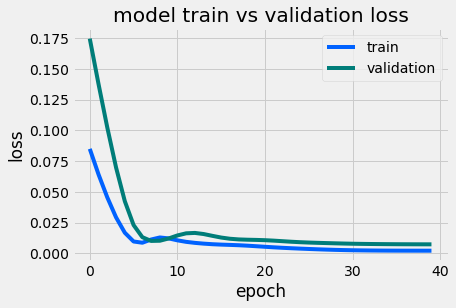

In [422]:
trend_years = 9 #Forecast Zone which seems to best approximate the relevant trend'''
trend_data = GETDATA(usngpdpro_trend, usngpdpro_trend['trend'].name, trend_years, trend_input_months, 
                 trend_test_months, sample_gap)
trendtrain_X, trendtest_X_init, trendtrain_y, trendtest_y = \
trend_data.get_train_test_data()
trend_input_months = 6
trend_test_months = 18
trend_n_steps = (n_steps -(test_months-input_months)) + trend_test_months - trend_input_months
No = trend_n_steps
Ni = trendtest_X_init.shape[0]
R_ = (Ni/No)**(1/3)
h1 = int(np.round(No*(R_**2)))
h2 = int(np.round(No*R_))
trendfit = FIT(trendtrain_X, trendtrain_y, 0, 0, h1, h2, 40)
print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
trendmodel = trendfit.LSTM()

In [423]:
trend_prior = usngpdpro_trend[:-trend_test_months]

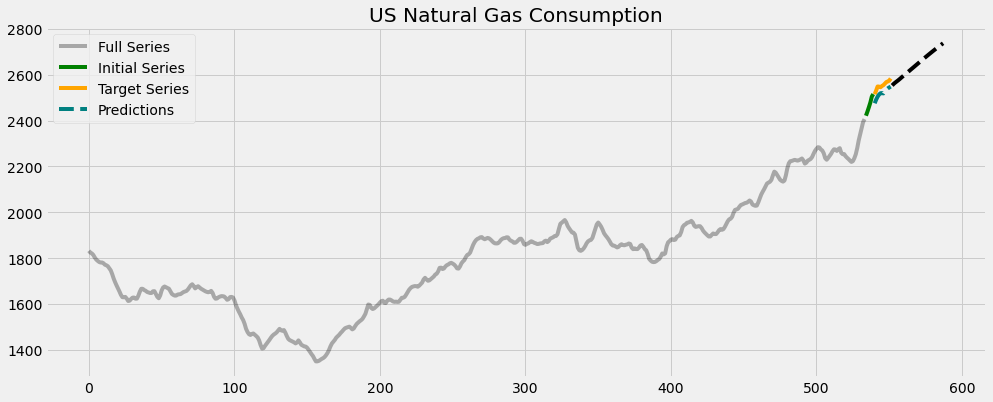

In [424]:
trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  trend_n_steps, trendtest_y, trendmodel, trend_prior, trend_test_months,  'US Natural Gas Consumption', True)
trend_predict = trend_predict.predict_and_plot()

(98494.9569880384, 0.4604774078479912)

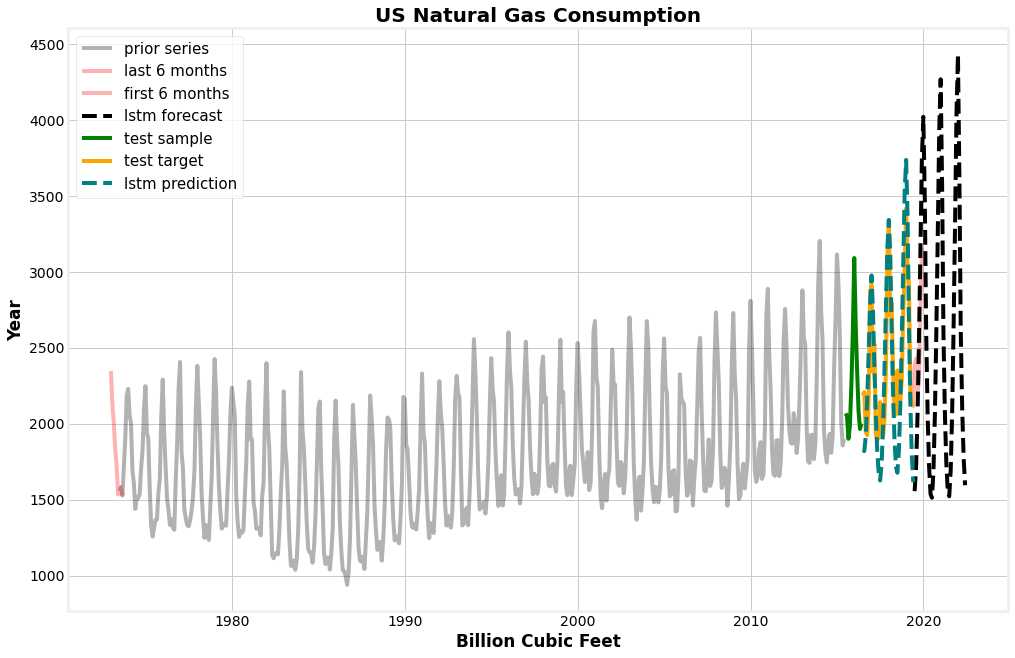

In [441]:
if n_steps > len(test_y):
    full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Forecasted', 'Index']))
    for i in range(len(predict[0])):
        full_series.loc[i, 'Actual'] = predict[0][i][0]
    for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
        full_series.loc[j, 'Actual'] = predict[1][i][0]
    for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
        full_series.loc[j, 'Actual'] = predict[2][i][0]
    for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
        full_series.loc[j, 'Predicted'] = predict[3][i][0] 
    for i, j in zip(range(len(predict[4])), np.arange(len(predict[0]) + len(predict[1]) + len(predict[2]), len(predict[0]) + len(predict[1]) + len(predict[2]) + len(predict[4]))):
        full_series.loc[j, 'Forecasted'] = predict[4][i][0]  
    full_series['Index'][:len(usngpdpro_trend) ] = usngpdpro[6:-6].index
    full_series['Index'][len(usngpdpro_trend) :] = usngpdpro[6:-6].index.shift(len(usngpdpro[6:-6]), 'M')[0:len(predict[4])]
    full_series = full_series.set_index('Index')
    actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_trend) - test_months], dtype = 'float64').reshape(len(usngpdpro_trend) - test_months,1)) + (np.array(usngpdpro_trend[:len(usngpdpro_trend) - test_months]))
    init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_trend) - test_months:len(usngpdpro_trend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1)) + (np.array(usngpdpro_trend[len(usngpdpro_trend) - test_months:len(usngpdpro_trend) - (test_months - input_months)])))
    target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ], dtype = 'float64').reshape(test_months - input_months,1)) + (np.array(usngpdpro_trend[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ])))
    predicted_series = np.array(full_series.Predicted[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ], dtype = 'float64')
    forecast_series = np.array(full_series.Forecasted[len(usngpdpro_trend) :len(usngpdpro_trend) + n_steps - len(test_y)], dtype = 'float64').reshape(n_steps - len(test_y),1)
    predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1)) + (np.array(usngpdpro_trend[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ]))
    forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1)) + (trend_predict[4])
    actual_series['Index'] = usngpdpro[6:-6][:len(usngpdpro_trend) - test_months].index
    predicted_series['Index'] = usngpdpro[6:-6][len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ].index
    predicted_series = predicted_series.set_index('Index')
    target_series['Index'] = usngpdpro[6:-6][len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ].index
    target_series = target_series.set_index('Index')
    actual_series = actual_series.set_index('Index')
    init_series['Index'] = usngpdpro[6:-6][len(usngpdpro_trend) - test_months:len(usngpdpro_trend) - (test_months - input_months)].index
    init_series = init_series.set_index('Index')
    forecast_series['Index'] = full_series[len(usngpdpro_trend) :len(usngpdpro_trend) + n_steps - len(test_y)].index
    forecast_series = forecast_series.set_index('Index')
    predicted_rnn = pd.DataFrame(predicted_series)
    forecast_rnn = pd.DataFrame(forecast_series)
    fig, ax = plt.subplots(figsize=(15, 10))
    #fig2, ax2 = plt.subplots(figsize=(15, 10))
    ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
    ax.plot(usngpdpro[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
    ax.plot(usngpdpro[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
    ax.plot(forecast_series, color = 'black', linestyle = 'dashed', label = 'lstm forecast')
    ax.plot(init_series, color = 'green', label = 'test sample')
    ax.plot(target_series, color = 'orange', label = 'test target')
    ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
    ax.legend(loc = 'best', facecolor = 'white', fontsize = 15)
    ax.set_title('US Natural Gas Consumption', fontsize =20, fontweight = 'bold')
    ax.set_xlabel('Billion Cubic Feet', fontweight = 'bold')
    ax.set_ylabel('Year', fontweight = 'bold')
    fig.set_facecolor('white')
    ax.set_facecolor('white')
else:
    full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Index']))
    for i in range(len(predict[0])):
        full_series.loc[i, 'Actual'] = predict[0][i][0]
    for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
        full_series.loc[j, 'Actual'] = predict[1][i][0]
    for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
        full_series.loc[j, 'Actual'] = predict[2][i][0]
    for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
        full_series.loc[j, 'Predicted'] = predict[3][i][0] 
    full_series['Index'][:len(usngpdpro_trend) ] = usngpdpro[6:-6].index
    full_series = full_series.set_index('Index')
    actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_trend) - test_months], dtype = 'float64').reshape(len(usngpdpro_trend) - test_months,1))+(np.array(usngpdpro_trend[:len(usngpdpro_trend) - test_months]))
    init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_trend) - test_months:len(usngpdpro_trend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_trend[len(usngpdpro_trend) - test_months:len(usngpdpro_trend) - (test_months - input_months)])))
    target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend)], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_trend[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ])))
    predicted_series = np.array(full_series.Predicted[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ], dtype = 'float64')
    predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_trend[len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ]))
    actual_series['Index'] = usngpdpro[6:-6][:len(usngpdpro_trend) - test_months].index
    predicted_series['Index'] = usngpdpro[6:-6][len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ].index
    predicted_series = predicted_series.set_index('Index')
    target_series['Index'] = usngpdpro[6:-6][len(usngpdpro_trend) - (test_months - input_months):len(usngpdpro_trend) ].index
    target_series = target_series.set_index('Index')
    actual_series = actual_series.set_index('Index')
    init_series['Index'] = usngpdpro[6:-6][len(usngpdpro_trend) - test_months:len(usngpdpro_trend) - (test_months - input_months)].index
    init_series = init_series.set_index('Index')
    predicted_rnn = pd.DataFrame(predicted_series)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
    ax.plot(usngpdpro[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
    ax.plot(usngpdpro[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
    ax.plot(init_series, color = 'green', label = 'test sample')
    ax.plot(target_series, color = 'orange', label = 'test target')
    ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
    ax.legend(loc = 'best', fontsize = 15)
    ax.set_title('US Natural Gas Consumption', fontsize =20, fontweight = 'bold')
    ax.set_xlabel('Billion Cubic Feet', fontweight = 'bold')
    ax.set_ylabel('Year', fontweight = 'bold')
    fig.set_facecolor('white')
    ax.set_facecolor('white')
true_rnn = pd.DataFrame(target_series)
usngpdscores_rnn = Scores(true_rnn, predicted_rnn)
usngpdscores_rnn.scores()
#usngpdscores_rnn.df().head()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
fig2, ax2 = plt.subplots(figsize=(15, 10))
ax.plot(usngpdpro[-50:], color = 'blue', label = 'original series')
ax.plot(predict_usngpdpro[-50:], color = 'red', label = 'in sample prediction full series')
#prior_origin = pd.DataFrame(prior_origin)
#prior_origin.index = usngpdpro[:-test_months].index
#ax2.plot(prior_origin)
ax2.plot(usngpdpro[-len(test_y):], color = 'blue', alpha = 0.25, label = 'original series')
ax2.plot(predicted_rnn, color = 'orange', linestyle = 'dashed', label = 'LSTM prediction')
ax2.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
ax2.plot(forecast_rnn, color = 'yellow', linestyle = 'dashed', label = 'LSTM forecast')
ax2.plot(us_ngpd_cv.fcst, color = 'red', linestyle = 'dashed', label = 'in-sample prediction on forecast interval')
ax2.plot(us_ngpd_cv.actual, color = 'green', alpha = 0.4, linestyle = 'dashed', label = 'in-sample forecast interval ({} month sampling interval)'.format(step_size))
# Construct the forecasts
usngpdproforecast['forecast'].plot(ax=ax, color='black', linestyle = 'dashed') #'dashed') #style = 'k--')
ax.fill_between(usngpdproforecast.index, usngpdproforecast['mean_ci_lower'], usngpdproforecast['mean_ci_upper'], color='green', alpha=0.3, label = 'confidence interval 95%');
ax.legend()
ax.set_title('US Natural Gas Consumption', fontsize =20)
usngpdproforecast['forecast'].plot(ax=ax2, color='black', linestyle = 'dashed') #'dashed') #style = 'k--')
ax2.fill_between(usngpdproforecast.index, usngpdproforecast['mean_ci_lower'], usngpdproforecast['mean_ci_upper'], color='green', alpha=0.3, label = 'confidence interval 95%');
ax2.legend(loc = 'best', fontsize = 11)
ax2.set_title('US Natural Gas Consumption', fontsize =20)

## Natural Gas Production

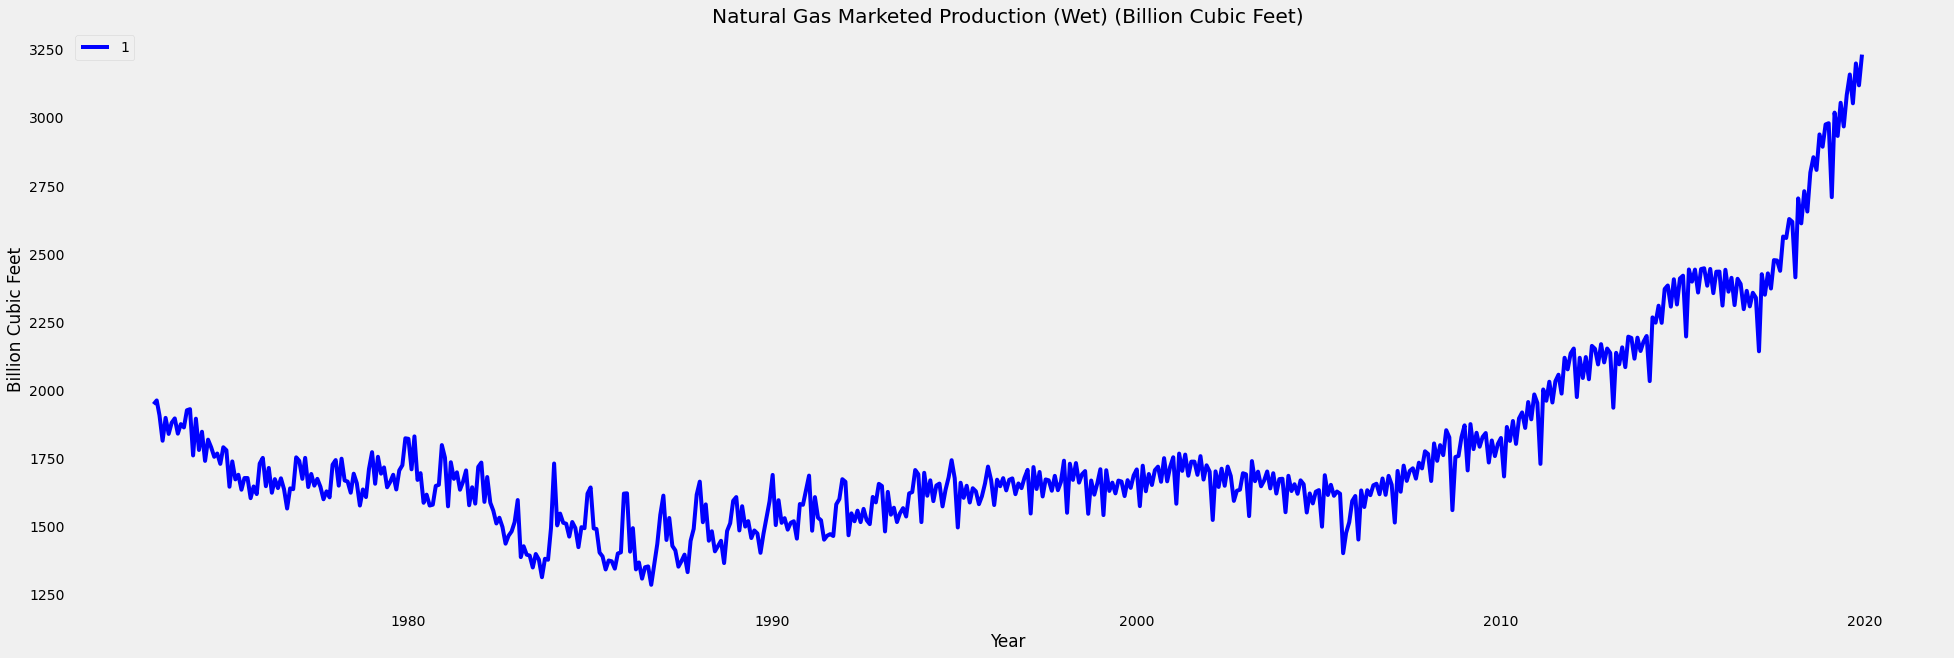

In [203]:
usngpdpro_m = us_ngpd[['year', us_ngpd.columns[3]]].dropna()
usngpdpro_m  = usngpdpro_m[usngpdpro_m['year'] >=1970]
usngpdpro_m = usngpdpro_m[usngpdpro_m['year']<2020]
usngpdpro_mtest = np.array(usngpdpro_m, dtype = 'float64')
usngpdpro_mtest = pd.DataFrame(usngpdpro_mtest)
usngpdpro_mtest.index = usngpdpro_m.index
usngpdpro_m = usngpdpro_mtest
usngpdpro_m = usngpdpro_m[[usngpdpro_m.columns[-1]]]
usngpdpro_mlegend = usngpdpro_m.columns[-1]
run_sequence_plot(usngpdpro_m.index, np.array(usngpdpro_m), usngpdpro_mlegend, title = us_ngpd.columns[3], xlabel = 'Year', ylabel ='Billion Cubic Feet')

Test Statistic           2.4
p-value                  1.0
Lags Used               13.0
Observations Used      550.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
non stationary, we cannot reject the null that it is non-stationary with > 90% confidence


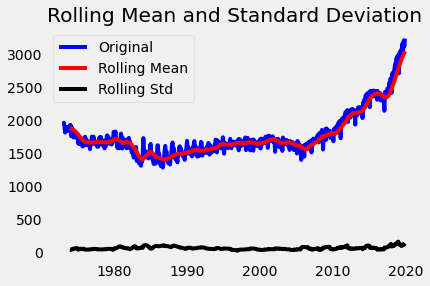

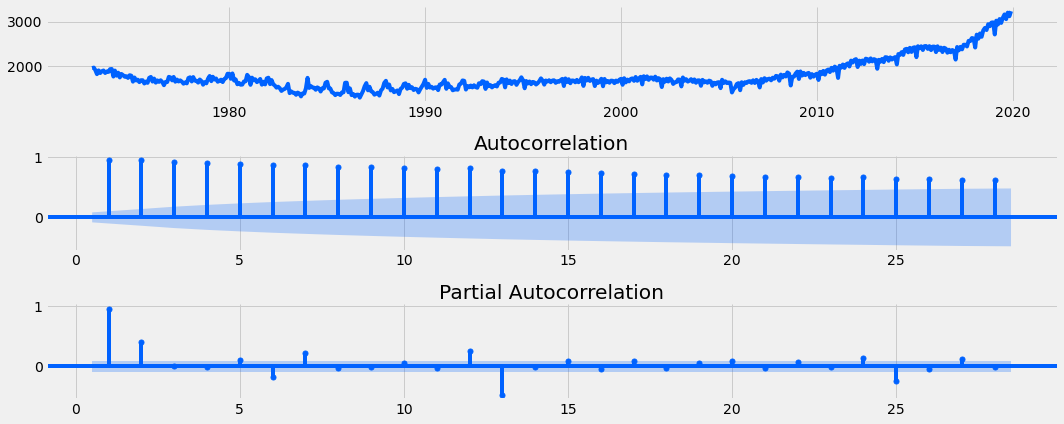

In [204]:
dftest(usngpdpro_m)
plots(usngpdpro_m)

There appears to be some 12 month seasonality present, due to the autocorrelation with 13th and 25th lags. We can see this by looking at the last 10 years. 

<AxesSubplot:xlabel='Month'>

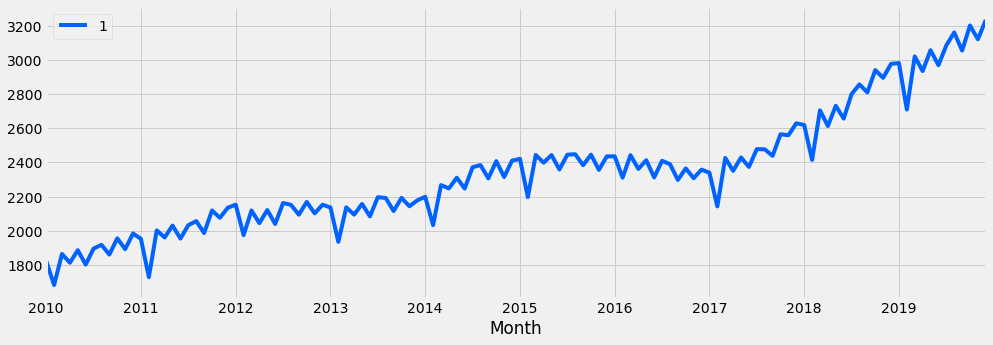

In [205]:
usngpdpro_m[-120:].plot(figsize = (15, 5))

In [246]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=usngpdpro_m, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
usngpdpro_m_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()

<AxesSubplot:xlabel='Month'>

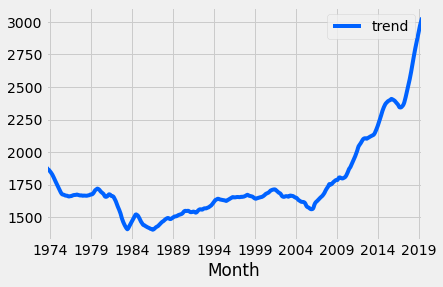

In [247]:
usngpdpro_m_ = pd.DataFrame(usngpdpro_m_)#[6:-6])
usngpdpro_mtrend = pd.DataFrame(estimated_trend[6:-6])
usngpdpro_mseasonal = pd.DataFrame(estimated_seasonal[6:-6])
usngpdpro_mresidual = pd.DataFrame(estimated_residual[6:-6])
usngpdpro_mtrend.plot()

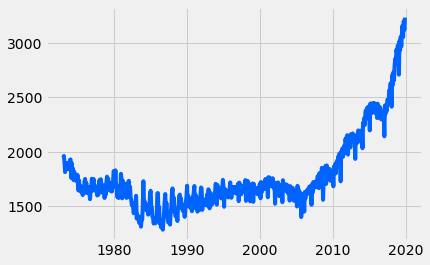

In [244]:
plt.plot(usngpdpro_m)

Test Statistic          -7.8
p-value                  0.0
Lags Used               19.0
Observations Used      532.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


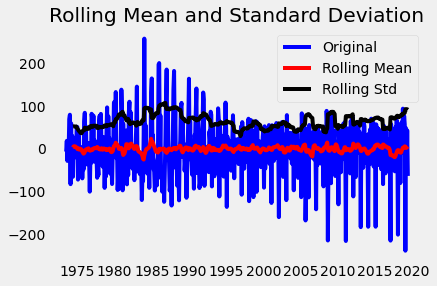

In [208]:
dftest(usngpdpro_m_)

MSE: 35460.47116533877 R-Squared: 0.5908879968224976


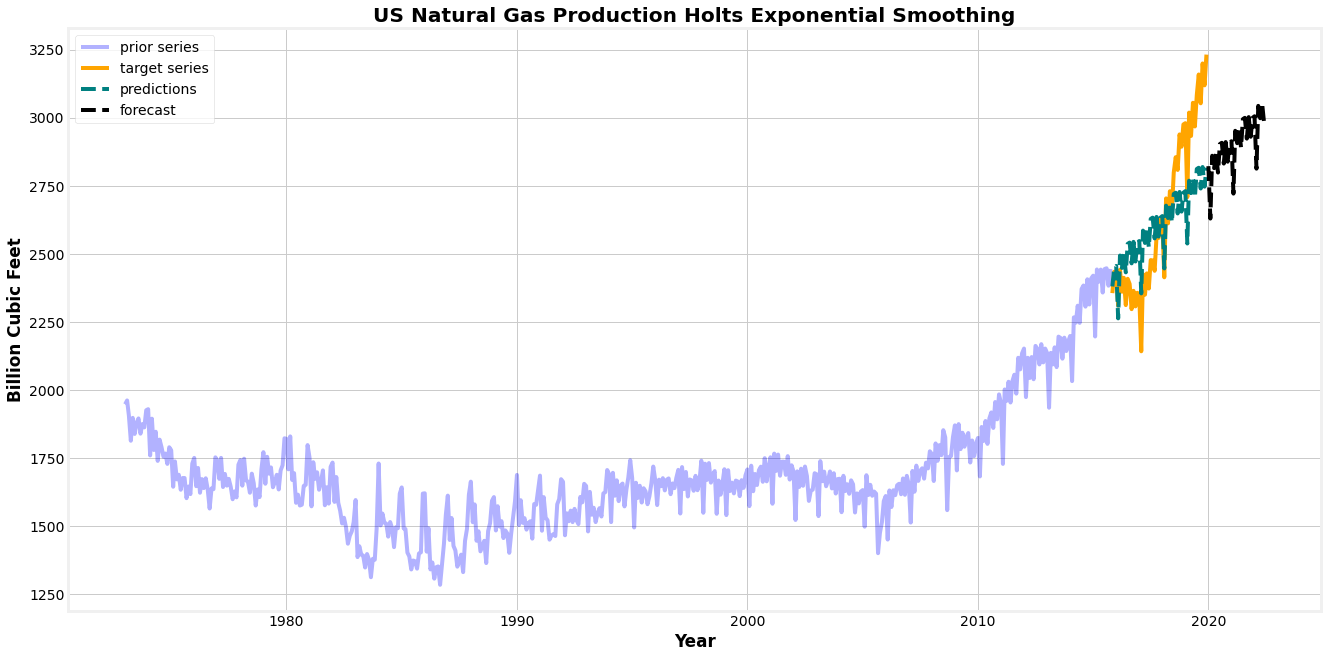

In [305]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(usngpdpro_m[:-50],
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(usngpdpro[-50:]) + 30)
triple_mse = mse(usngpdpro_m[-50:], triple_preds[:-30])
triple_r2 = r2(usngpdpro_m[-50:], triple_preds[:-30])
print('MSE:', triple_mse, 'R-Squared:', triple_r2)
#print('R-Squared', triple_r2)

fig, ax = plt.subplots(figsize=(20, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
#ax.plot(usngpdpro, color = 'black', alpha = 0.3, label = 'prior series')
ax.plot(usngpdpro_m[:-50], color = 'blue', alpha = 0.3, label = 'prior series')
ax.plot(usngpdpro_m[-50:], color = 'orange', label = 'target series')
ax.plot(triple_preds[:-30], color = 'teal', linestyle = 'dashed', label = 'predictions')
ax.plot(triple_preds[-30:], color = 'black', linestyle = 'dashed', label = 'forecast')
ax.legend(loc = 'best', facecolor = 'white')
ax.set_title('US Natural Gas Production Holts Exponential Smoothing', fontweight = 'bold')
ax.set_ylabel('Billion Cubic Feet', fontweight = 'bold')
ax.set_xlabel('Year', fontweight = 'bold')
fig.set_facecolor('white')
ax.set_facecolor('white')

Holt's Exponential Smoothing is poor due to the time-varying trend

In [ ]:
usngpdpro_m_model = pm.auto_arima(usngpdpro_m, start_p=0, start_q=0,
                           max_p=2, max_q=2, start_d=0, max_d=1, m=12,
                           start_P=0, start_Q=0, max_P = 1, max_Q = 1, seasonal=True,
                            D=1, max_D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(usngpdpro_m_model.aic())

In [ ]:
usngpdpro_marima = sm.tsa.statespace.SARIMAX(usngpdpro_m,     ##hhgas
                                order=(0,1,1), 
                                seasonal_order=(0,1,1,12), ##None
                                trend='c').fit()
usngpdpro_marima.summary()

In [ ]:
plots(usngpdproarima.resid[usngpdproarima.loglikelihood_burn:])

In [ ]:
dftest(usngpdproarima.resid)

Create a forecasting function

In [32]:
def forecasting(df, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, epoch1, epoch2): # remove df_trend,
    #sc = MinMaxScaler(feature_range = (0,1))
    usngpdpro_m = df
    usngpdpro_mtrend = df_trend
    df = df_
    No = n_steps
    Ni = test_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    fit = FIT(train_X, train_y, 0, 0, h1, h2, epoch1)
    print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
    model = fit.LSTM()
    predict = PREDICT(test_X_init, test_X_init,  n_steps, test_y, model, prior, test_months,  title, True)
    predict = predict.predict_and_plot()
    #sc = MinMaxScaler(feature_range = (0,1))

    
    trend_data = GETDATA(df_trend, df_trend['trend'].name, trend_years, trend_input_months, 
                 trend_test_months, sample_gap)
    trendtrain_X, trendtest_X_init, trendtrain_y, trendtest_y = \
    trend_data.get_train_test_data()
    No = trend_n_steps
    Ni = trendtest_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    trendfit = FIT(trendtrain_X, trendtrain_y, 0, 0, h1, h2, epoch2)
    print('no of samples',(12*trend_years -trend_test_months-trend_input_months)/sample_gap)
    trendmodel = trendfit.LSTM()
    trend_prior = usngpdpro_mtrend[:-trend_test_months]
    trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  trend_n_steps, trendtest_y, trendmodel, trend_prior, trend_test_months,  title, True)
    trend_predict = trend_predict.predict_and_plot()
    
  #  trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  n_steps, trendtest_y, trendmodel, trend_prior, test_months,  title, True)  #remove all this if doesnt work
  #  trend_predict = trend_predict.predict_and_plot()
    
    
    if n_steps > len(test_y):
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Forecasted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        for i, j in zip(range(len(predict[4])), np.arange(len(predict[0]) + len(predict[1]) + len(predict[2]), len(predict[0]) + len(predict[1]) + len(predict[2]) + len(predict[4]))):
            full_series.loc[j, 'Forecasted'] = predict[4][i][0]  
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series['Index'][len(usngpdpro_mtrend) :] = usngpdpro_m[6:-6].index.shift(len(usngpdpro_m[6:-6]), 'M')[0:len(predict[4])]
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        forecast_series = np.array(full_series.Forecasted[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)], dtype = 'float64').reshape(n_steps - len(test_y),1)
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
        forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))+(trend_predict[4]) #old version
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        forecast_series['Index'] = full_series[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)].index
        forecast_series = forecast_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        forecast_rnn = pd.DataFrame(forecast_series)
        fig, ax = plt.subplots(figsize=(20, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        #ax.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
        ax.plot(forecast_series, color = 'black', linestyle = 'dashed', label = 'lstm forecast')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    else:
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend)], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    true_rnn = pd.DataFrame(target_series)
    usngpdscores_rnn = Scores(true_rnn, predicted_rnn)
    usngpdscores_rnn.scores()
    usngpdscores_rnn.df().head()
    print(usngpdscores_rnn.scores())

In [33]:
def forecasting_exp(df, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, epoch1, epoch2): # remove df_trend,
    #sc = MinMaxScaler(feature_range = (0,1))
    usngpdpro_m = df
    usngpdpro_mtrend = df_trend
    df = df_
    No = n_steps
    Ni = test_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    fit = FIT(train_X, train_y, 0, 0, h1, h2, epoch1)
    print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
    model = fit.LSTM()
    predict = PREDICT(test_X_init, test_X_init,  n_steps, test_y, model, prior, test_months,  title, True)
    predict = predict.predict_and_plot()
    #sc = MinMaxScaler(feature_range = (0,1))

    
    trend_data = GETDATA(df_trend, df_trend['trend'].name, trend_years, trend_input_months, 
                 trend_test_months, sample_gap)
    trendtrain_X, trendtest_X_init, trendtrain_y, trendtest_y = \
    trend_data.get_train_test_data()
    No = trend_n_steps
    Ni = trendtest_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    trendfit = FIT(trendtrain_X, trendtrain_y, 0, 0, h1, h2, epoch2)
    print('no of samples',(12*trend_years -trend_test_months-trend_input_months)/sample_gap)
    trendmodel = trendfit.LSTM()
    trend_prior = usngpdpro_mtrend[:-trend_test_months]
    trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  trend_n_steps, trendtest_y, trendmodel, trend_prior, trend_test_months,  title, True)
    trend_predict = trend_predict.predict_and_plot()
    
  #  trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  n_steps, trendtest_y, trendmodel, trend_prior, test_months,  title, True)  #remove all this if doesnt work
  #  trend_predict = trend_predict.predict_and_plot()
    
    
    if n_steps > len(test_y):
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Forecasted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        for i, j in zip(range(len(predict[4])), np.arange(len(predict[0]) + len(predict[1]) + len(predict[2]), len(predict[0]) + len(predict[1]) + len(predict[2]) + len(predict[4]))):
            full_series.loc[j, 'Forecasted'] = predict[4][i][0]  
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series['Index'][len(usngpdpro_mtrend) :] = usngpdpro_m[6:-6].index.shift(len(usngpdpro_m[6:-6]), 'M')[0:len(predict[4])]
        full_series = full_series.set_index('Index')
        actual_series = np.exp(pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months])))
        init_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)]))))
        target_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        forecast_series = np.array(full_series.Forecasted[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)], dtype = 'float64').reshape(n_steps - len(test_y),1)
        predicted_series = np.exp(pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        forecast_series = np.exp(pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))+(trend_predict[4])) #old version
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        forecast_series['Index'] = full_series[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)].index
        forecast_series = forecast_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        forecast_rnn = pd.DataFrame(forecast_series)
        fig, ax = plt.subplots(figsize=(20, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(np.exp(usngpdpro_m[-9:]), color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(np.exp(usngpdpro_m[0:9]), color = 'red', alpha = 0.3, label = 'first 6 months')
        #ax.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
        ax.plot(forecast_series, color = 'black', linestyle = 'dashed', label = 'lstm forecast')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    else:
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series = full_series.set_index('Index')
        actual_series = np.exp(pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months])))
        init_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)]))))
        target_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend)], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        predicted_series = np.exp(pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(np.exp(usngpdpro_m[-9:]), color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(np.exp(usngpdpro_m[0:9]), color = 'red', alpha = 0.3, label = 'first 6 months')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    true_rnn = pd.DataFrame(target_series)
    usngpdscores_rnn = Scores(true_rnn, predicted_rnn)
    usngpdscores_rnn.scores()
    usngpdscores_rnn.df().head()
    print(usngpdscores_rnn.scores())

In [34]:
def forecasting_full(df, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps,  n_steps, epoch1, epoch2): # remove df_trend,
    #sc = MinMaxScaler(feature_range = (0,1))
    usngpdpro_m = df
    usngpdpro_mtrend = df_trend
    df = df_
    No = n_steps
    Ni = test_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    fit = FIT(train_X, train_y, 0, 0, h1, h2, epoch1)
    print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
    model = fit.LSTM()
    predict = PREDICT(test_X_init, test_X_init,  n_steps, test_y, model, prior, test_months,  title, True)
    predict = predict.predict_and_plot()
    #sc = MinMaxScaler(feature_range = (0,1))

    
    trend_data = GETDATA(df_trend, df_trend['trend'].name, trend_years, trend_input_months, 
                 trend_test_months, sample_gap)
    trendtrain_X, trendtest_X_init, trendtrain_y, trendtest_y = \
    trend_data.get_train_test_data()
    No = trend_n_steps
    Ni = trendtest_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    trendfit = FIT(trendtrain_X, trendtrain_y, 0, 0, h1, h2, epoch2)
    print('no of samples',(12*trend_years -trend_test_months-trend_input_months)/sample_gap)
    trendmodel = trendfit.LSTM()
    trend_prior = usngpdpro_mtrend[:-trend_test_months]
    trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  trend_n_steps, trendtest_y, trendmodel, trend_prior, trend_test_months,  title, True)
    trend_predict = trend_predict.predict_and_plot()
      
    
    if n_steps > len(test_y):
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Forecasted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        for i, j in zip(range(len(predict[4])), np.arange(len(predict[0]) + len(predict[1]) + len(predict[2]), len(predict[0]) + len(predict[1]) + len(predict[2]) + len(predict[4]))):
            full_series.loc[j, 'Forecasted'] = predict[4][i][0]  
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m.index
        full_series['Index'][len(usngpdpro_mtrend) :] = usngpdpro_m.index.shift(len(usngpdpro_m), 'M')[0:len(predict[4])]
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        forecast_series = np.array(full_series.Forecasted[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)], dtype = 'float64').reshape(n_steps - len(test_y),1)
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
        forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))+(trend_predict[4]) #old version
        actual_series['Index'] = usngpdpro_m[:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        forecast_series['Index'] = full_series[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)].index
        forecast_series = forecast_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        forecast_rnn = pd.DataFrame(forecast_series)
        fig, ax = plt.subplots(figsize=(20, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        #ax.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
        ax.plot(forecast_series, color = 'black', linestyle = 'dashed', label = 'lstm forecast')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    else:
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m.index
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend)], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))*(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
        actual_series['Index'] = usngpdpro_m[:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    true_rnn = pd.DataFrame(target_series)
    usngpdscores_rnn = Scores(true_rnn, predicted_rnn)
    usngpdscores_rnn.scores()
    #usngpdscores_rnn.df().head()
    return usngpdscores_rnn.scores()

In [35]:
def forecasting_trend(df, df_trend, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, epoch1, epoch2): # remove df_trend,
    #sc = MinMaxScaler(feature_range = (0,1))
    usngpdpro_m = df
    usngpdpro_mtrend = df_trend
    df = df_
    No = n_steps
    Ni = test_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    fit = FIT(train_X, train_y, 0, 0, h1, h2, epoch1)
    print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
    model = fit.LSTM()
    predict = PREDICT(test_X_init, test_X_init,  n_steps, test_y, model, prior, test_months,  title, True)
    predict = predict.predict_and_plot()
    #sc = MinMaxScaler(feature_range = (0,1))
    
    
   
    trend_origin = np.array(usngpdpro_mtrend)     #remove all this if doesnt work
    df_trend = usngpdpro_mtrend.diff().dropna()
    trend_prior = df_trend[:-trend_test_months]
    trend_prior_origin = np.array(trend_origin[:-trend_test_months])
    title = title
    
    
    trend_data = GETDATA(df_trend, df_trend['trend'].name, trend_years, trend_input_months, 
                 trend_test_months, sample_gap)
    trendtrain_X, trendtest_X_init, trendtrain_y, trendtest_y = \
    trend_data.get_train_test_data()
    No = trend_n_steps
    Ni = trendtest_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    trendfit = FIT(trendtrain_X, trendtrain_y, 0, 0, h1, h2, epoch2)
    print('no of samples',(12*trend_years -trend_test_months-trend_input_months)/sample_gap)
    trendmodel = trendfit.LSTM()
    #trend_prior = usngpdpro_mtrend[:-test_months]
    #trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  n_steps, trendtest_y, trendmodel, trend_prior, test_months,  title, True)
    #trend_predict = trend_predict.predict_and_plot()
    
    trend_predict = PREDICT_DIFF(trendtest_X_init, trendtest_X_init,  trend_n_steps, trendtest_y, trendmodel, trend_prior, trend_prior_origin, trend_test_months,  title, True)  #remove all this if doesnt work
    trend_predict = trend_predict.predict_and_plot()
    
    
    if n_steps > len(test_y):
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Forecasted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        for i, j in zip(range(len(predict[4])), np.arange(len(predict[0]) + len(predict[1]) + len(predict[2]), len(predict[0]) + len(predict[1]) + len(predict[2]) + len(predict[4]))):
            full_series.loc[j, 'Forecasted'] = predict[4][i][0]  
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series['Index'][len(usngpdpro_mtrend) :] = usngpdpro_m[6:-6].index.shift(len(usngpdpro_m[6:-6]), 'M')[0:len(predict[4])]
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        forecast_series = np.array(full_series.Forecasted[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)], dtype = 'float64').reshape(n_steps - len(test_y),1)
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
        #forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))*(trend_predict[4]) #old version
        forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))+(trend_predict[4].reshape(n_steps - len(test_y),1)) 
        #forecast_series = pd.DataFrame(forecast_series.reshape(1, n_steps - len(test_y)))*(trend_predict[4])
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        forecast_series['Index'] = full_series[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)].index
        forecast_series = forecast_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        forecast_rnn = pd.DataFrame(forecast_series)
        fig, ax = plt.subplots(figsize=(20, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        #ax.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
        ax.plot(forecast_series, color = 'black', linestyle = 'dashed', label = 'lstm forecast')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    else:
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend)], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    true_rnn = pd.DataFrame(target_series)
    usngpdscores_rnn = Scores(true_rnn, predicted_rnn)
    usngpdscores_rnn.scores()
    #usngpdscores_rnn.df().head()
    print(usngpdscores_rnn.scores())

In [36]:
def forecasting_trend_exp(df, df_trend, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, epoch1, epoch2): # remove df_trend,
    #sc = MinMaxScaler(feature_range = (0,1))
    usngpdpro_m = df
    usngpdpro_mtrend = df_trend
    df = df_
    No = n_steps
    Ni = test_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    fit = FIT(train_X, train_y, 0, 0, h1, h2, epoch1)
    print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
    model = fit.LSTM()
    predict = PREDICT(test_X_init, test_X_init,  n_steps, test_y, model, prior, test_months,  title, True)
    predict = predict.predict_and_plot()
    #sc = MinMaxScaler(feature_range = (0,1))
    
    
   
    trend_origin = np.array(usngpdpro_mtrend)     #remove all this if doesnt work
    df_trend = usngpdpro_mtrend.diff().dropna()
    trend_prior = df_trend[:-trend_test_months]
    trend_prior_origin = np.array(trend_origin[:-trend_test_months])
    title = title
    
    
    trend_data = GETDATA(df_trend, df_trend['trend'].name, trend_years, trend_input_months, 
                 trend_test_months, sample_gap)
    trendtrain_X, trendtest_X_init, trendtrain_y, trendtest_y = \
    trend_data.get_train_test_data()
    No = trend_n_steps
    Ni = trendtest_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    trendfit = FIT(trendtrain_X, trendtrain_y, 0, 0, h1, h2, epoch2)
    print('no of samples',(12*trend_years -trend_test_months-trend_input_months)/sample_gap)
    trendmodel = trendfit.LSTM()
    #trend_prior = usngpdpro_mtrend[:-test_months]
    #trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  n_steps, trendtest_y, trendmodel, trend_prior, test_months,  title, True)
    #trend_predict = trend_predict.predict_and_plot()
    
    trend_predict = PREDICT_DIFF(trendtest_X_init, trendtest_X_init,  trend_n_steps, trendtest_y, trendmodel, trend_prior, trend_prior_origin, trend_test_months,  title, True)  #remove all this if doesnt work
    trend_predict = trend_predict.predict_and_plot()
    
    
    if n_steps > len(test_y):
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Forecasted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        for i, j in zip(range(len(predict[4])), np.arange(len(predict[0]) + len(predict[1]) + len(predict[2]), len(predict[0]) + len(predict[1]) + len(predict[2]) + len(predict[4]))):
            full_series.loc[j, 'Forecasted'] = predict[4][i][0]  
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series['Index'][len(usngpdpro_mtrend) :] = usngpdpro_m[6:-6].index.shift(len(usngpdpro_m[6:-6]), 'M')[0:len(predict[4])]
        full_series = full_series.set_index('Index')
        actual_series = np.exp(pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months])))
        init_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)]))))
        target_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        forecast_series = np.array(full_series.Forecasted[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)], dtype = 'float64').reshape(n_steps - len(test_y),1)
        predicted_series = np.exp(pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        #forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))*(trend_predict[4]) #old version
        forecast_series = np.exp(pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))+(trend_predict[4].reshape(n_steps - len(test_y),1))) 
        #forecast_series = pd.DataFrame(forecast_series.reshape(1, n_steps - len(test_y)))*(trend_predict[4])
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        forecast_series['Index'] = full_series[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)].index
        forecast_series = forecast_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        forecast_rnn = pd.DataFrame(forecast_series)
        fig, ax = plt.subplots(figsize=(20, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(np.exp(usngpdpro_m[-9:]), color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(np.exp(usngpdpro_m[0:9]), color = 'red', alpha = 0.3, label = 'first 6 months')
        #ax.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
        ax.plot(forecast_series, color = 'black', linestyle = 'dashed', label = 'lstm forecast')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best')
        ax.legend(loc = 'best', fontsize = 15, facecolor = 'white')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    else:
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series = full_series.set_index('Index')
        actual_series = np.exp(pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months])))
        init_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)]))))
        target_series = np.exp(pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend)], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        predicted_series = np.exp(pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        actual_series['Index'] = usngpdpro_m[6:-6][:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[6:-6][len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(np.exp(usngpdpro_m[-9:]), color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(np.exp(usngpdpro_m[0:9]), color = 'red', alpha = 0.3, label = 'first 6 months')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    true_rnn = pd.DataFrame(target_series)
    usngpdscores_rnn = Scores(true_rnn, predicted_rnn)
    usngpdscores_rnn.scores()
    #usngpdscores_rnn.df().head()
    print(usngpdscores_rnn.scores())

In [37]:
def forecasting_trend_full(df, df_trend, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, epoch1, epoch2): # remove df_trend,
    #sc = MinMaxScaler(feature_range = (0,1))
    usngpdpro_m = df
    usngpdpro_mtrend = df_trend
    df = df_
    No = n_steps
    Ni = test_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    fit = FIT(train_X, train_y, 0, 0, h1, h2, epoch1)
    print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
    model = fit.LSTM()
    predict = PREDICT(test_X_init, test_X_init,  n_steps, test_y, model, prior, test_months,  title, True)
    predict = predict.predict_and_plot()
    #sc = MinMaxScaler(feature_range = (0,1))
    
    
   
    trend_origin = np.array(usngpdpro_mtrend)     #remove all this if doesnt work
    df_trend = usngpdpro_mtrend.diff().dropna()
    trend_prior = df_trend[:-trend_test_months]
    trend_prior_origin = np.array(trend_origin[:-trend_test_months])
    title = 'Henry Hub Natural Gas Spot Prices'
    
    
    trend_data = GETDATA(df_trend, df_trend['trend'].name, trend_years, trend_input_months, 
                 trend_test_months, sample_gap)
    trendtrain_X, trendtest_X_init, trendtrain_y, trendtest_y = \
    trend_data.get_train_test_data()
    No = trend_n_steps
    Ni = trendtest_X_init.shape[0]
    R_ = (Ni/No)**(1/3)
    h1 = int(np.round(No*(R_**2)))
    h2 = int(np.round(No*R_))
    trendfit = FIT(trendtrain_X, trendtrain_y, 0, 0, h1, h2, epoch2)
    print('no of samples',(12*trend_years -trend_test_months-trend_input_months)/sample_gap)
    trendmodel = trendfit.LSTM()
    #trend_prior = usngpdpro_mtrend[:-test_months]
    #trend_predict = PREDICT(trendtest_X_init, trendtest_X_init,  n_steps, trendtest_y, trendmodel, trend_prior, test_months,  title, True)
    #trend_predict = trend_predict.predict_and_plot()
    
    trend_predict = PREDICT_DIFF(trendtest_X_init, trendtest_X_init,  trend_n_steps, trendtest_y, trendmodel, trend_prior, trend_prior_origin, trend_test_months,  title, True)  #remove all this if doesnt work
    trend_predict = trend_predict.predict_and_plot()
    
    
    if n_steps > len(test_y):
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Forecasted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        for i, j in zip(range(len(predict[4])), np.arange(len(predict[0]) + len(predict[1]) + len(predict[2]), len(predict[0]) + len(predict[1]) + len(predict[2]) + len(predict[4]))):
            full_series.loc[j, 'Forecasted'] = predict[4][i][0]  
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m.index
        full_series['Index'][len(usngpdpro_mtrend) :] = usngpdpro_m.index.shift(len(usngpdpro_m), 'M')[0:len(predict[4])]
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        forecast_series = np.array(full_series.Forecasted[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)], dtype = 'float64').reshape(n_steps - len(test_y),1)
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
       # forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))*(trend_predict[4]) #old version
        forecast_series = pd.DataFrame(forecast_series.reshape(n_steps - len(test_y),1))+(trend_predict[4].reshape(n_steps - len(test_y),1)) 
        #forecast_series = pd.DataFrame(forecast_series.reshape(1, n_steps - len(test_y)))*(trend_predict[4])
        actual_series['Index'] = usngpdpro_m[:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        forecast_series['Index'] = full_series[len(usngpdpro_mtrend) :len(usngpdpro_mtrend) + n_steps - len(test_y)].index
        forecast_series = forecast_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        forecast_rnn = pd.DataFrame(forecast_series)
        fig, ax = plt.subplots(figsize=(20, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        #ax.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
        ax.plot(forecast_series, color = 'black', linestyle = 'dashed', label = 'lstm forecast')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    else:
        full_series = pd.DataFrame(columns = (['Actual', 'Predicted', 'Index']))
        for i in range(len(predict[0])):
            full_series.loc[i, 'Actual'] = predict[0][i][0]
        for i, j in zip(range(len(predict[1])), np.arange(len(predict[0]), len(predict[0]) + len(predict[1]))):
            full_series.loc[j, 'Actual'] = predict[1][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Actual'] = predict[2][i][0]
        for i, j in zip(range(len(predict[2])), np.arange(len(predict[0]) + len(predict[1]), len(predict[0]) + len(predict[1]) + len(predict[2]))):
            full_series.loc[j, 'Predicted'] = predict[3][i][0] 
        full_series['Index'][:len(usngpdpro_mtrend) ] = usngpdpro_m[6:-6].index
        full_series = full_series.set_index('Index')
        actual_series = pd.DataFrame(np.array(full_series.Actual[:len(usngpdpro_mtrend) - test_months], dtype = 'float64').reshape(len(usngpdpro_mtrend) - test_months,1))+(np.array(usngpdpro_mtrend[:len(usngpdpro_mtrend) - test_months]))
        init_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)], dtype = 'float64').reshape(input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)])))
        target_series = pd.DataFrame((np.array(full_series.Actual[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend)], dtype = 'float64').reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ])))
        predicted_series = np.array(full_series.Predicted[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ], dtype = 'float64')
        predicted_series = pd.DataFrame(predicted_series.reshape(test_months - input_months,1))+(np.array(usngpdpro_mtrend[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ]))
        actual_series['Index'] = usngpdpro_m[:len(usngpdpro_mtrend) - test_months].index
        predicted_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        predicted_series = predicted_series.set_index('Index')
        target_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - (test_months - input_months):len(usngpdpro_mtrend) ].index
        target_series = target_series.set_index('Index')
        actual_series = actual_series.set_index('Index')
        init_series['Index'] = usngpdpro_m[len(usngpdpro_mtrend) - test_months:len(usngpdpro_mtrend) - (test_months - input_months)].index
        init_series = init_series.set_index('Index')
        predicted_rnn = pd.DataFrame(predicted_series)
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(actual_series, color = 'black', alpha = 0.3, label = 'prior series')
        ax.plot(usngpdpro_m[-9:], color = 'red', alpha = 0.3, label = 'last 6 months')
        ax.plot(usngpdpro_m[0:9], color = 'red', alpha = 0.3, label = 'first 6 months')
        ax.plot(init_series, color = 'blue', label = 'test sample')
        ax.plot(target_series, color = 'orange', label = 'test target')
        ax.plot(predicted_series, color = 'teal', linestyle = 'dashed', label = 'lstm prediction')
        ax.legend(loc = 'best')
        ax.set_title(title, fontsize =20, fontweight = 'bold')
        ax.set_ylabel(ylabel, fontweight = 'bold')
        ax.set_xlabel('Year', fontweight = 'bold')
        fig.set_facecolor('white')
        ax.set_facecolor('white')
    true_rnn = pd.DataFrame(target_series)
    usngpdscores_rnn = Scores(true_rnn, predicted_rnn)
    usngpdscores_rnn.scores()
    usngpdscores_rnn.df().head()

In [284]:
production = usngpdpro_m
sc = MinMaxScaler(feature_range = (0,1))
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=production, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual= ss_decomposition.resid
df_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()
df_ = pd.DataFrame(df_)#[6:-6])
df_trend = pd.DataFrame(estimated_trend[6:-6])
df_seasonal = pd.DataFrame(estimated_seasonal[6:-6])
df_residual = pd.DataFrame(estimated_residual[6:-6])
df = df_
input_months= 9 #sample size
test_months = 15#test portion of forecast series in months
n_steps = 72
sample_gap = 1
series_name = df[df.columns[0]].name
series_years = 12 #forecast series length
trend_years = 3
trend_input_months = 6
trend_test_months = 12
trend_n_steps = (n_steps -(test_months-input_months)) + trend_test_months - trend_input_months
prior = df[:-test_months]
    #prior_origin = np.array(df_origin[:-test_months])
title = 'US Natural Gas Production'

In [285]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y = \
data.get_train_test_data()

In [ ]:
forecasting(production, title, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 10, 50)

In [ ]:
forecasting_trend(production, df_trend, 'US Natural Gas Production', input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 10, 50)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
fig2, ax2 = plt.subplots(figsize=(15, 10))
ax.plot(usngpdpro[-50:], color = 'blue', label = 'original series')
ax.plot(predict_usngpdpro[-50:], color = 'red', label = 'in sample prediction full series')
#prior_origin = pd.DataFrame(prior_origin)
#prior_origin.index = usngpdpro[:-test_months].index
#ax2.plot(prior_origin)
ax2.plot(usngpdpro[-len(test_y):], color = 'blue', alpha = 0.25, label = 'original series')
ax2.plot(predicted_rnn, color = 'orange', linestyle = 'dashed', label = 'LSTM prediction')
ax2.plot(triple_preds, color = 'purple', linestyle = 'dashed', label = 'Triple Expo prediction')
ax2.plot(forecast_rnn, color = 'yellow', linestyle = 'dashed', label = 'LSTM forecast')
ax2.plot(us_ngpd_cv.fcst, color = 'red', linestyle = 'dashed', label = 'in-sample prediction on forecast interval')
ax2.plot(us_ngpd_cv.actual, color = 'green', alpha = 0.4, linestyle = 'dashed', label = 'in-sample forecast interval ({} month sampling interval)'.format(step_size))
# Construct the forecasts
usngpdproforecast['forecast'].plot(ax=ax, color='black', linestyle = 'dashed') #'dashed') #style = 'k--')
ax.fill_between(usngpdproforecast.index, usngpdproforecast['mean_ci_lower'], usngpdproforecast['mean_ci_upper'], color='green', alpha=0.3, label = 'confidence interval 95%');
ax.legend()
ax.set_title('US Natural Gas Consumption', fontsize =20)
usngpdproforecast['forecast'].plot(ax=ax2, color='black', linestyle = 'dashed') #'dashed') #style = 'k--')
ax2.fill_between(usngpdproforecast.index, usngpdproforecast['mean_ci_lower'], usngpdproforecast['mean_ci_upper'], color='green', alpha=0.3, label = 'confidence interval 95%');
ax2.legend(loc = 'best', fontsize = 11)
ax2.set_title('US Natural Gas Consumption', fontsize =20)

## Natural Gas Imports

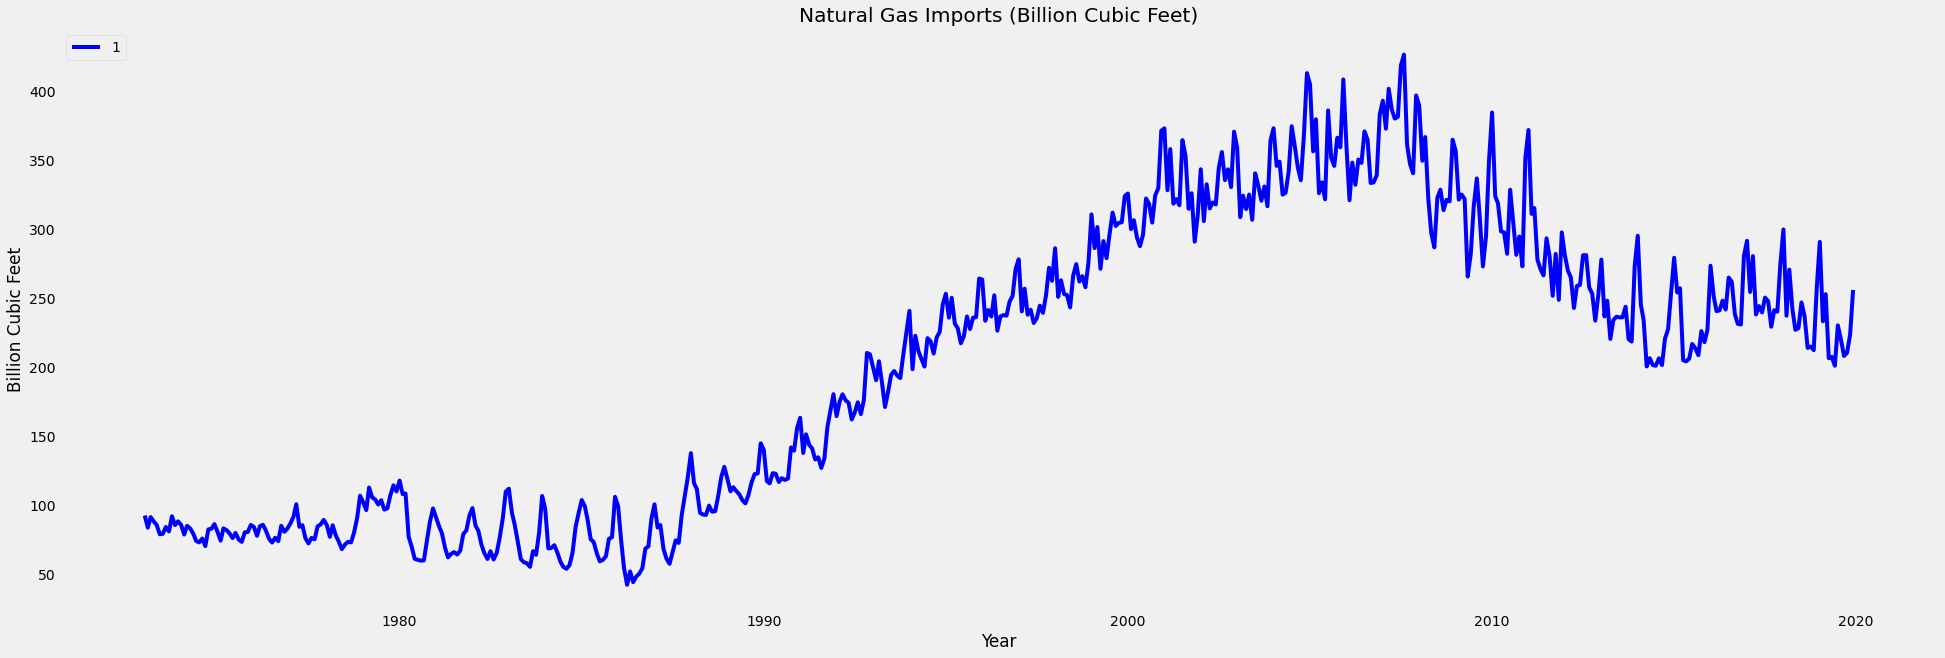

In [426]:
usngpdpro_m = us_ngpd[['year', us_ngpd.columns[7]]].dropna()
usngpdpro_m  = usngpdpro_m[usngpdpro_m['year'] >=1970]
usngpdpro_m = usngpdpro_m[usngpdpro_m['year']<2020]
usngpdpro_mtest = np.array(usngpdpro_m, dtype = 'float64')
usngpdpro_mtest = pd.DataFrame(usngpdpro_mtest)
usngpdpro_mtest.index = usngpdpro_m.index
usngpdpro_m = usngpdpro_mtest
usngpdpro_m = usngpdpro_m[[usngpdpro_m.columns[-1]]]
usngpdpro_mlegend = usngpdpro_m.columns[-1]
run_sequence_plot(usngpdpro_m.index, np.array(usngpdpro_m), usngpdpro_mlegend, title = us_ngpd.columns[7], xlabel = 'Year', ylabel ='Billion Cubic Feet')

Test Statistic          -1.2
p-value                  0.7
Lags Used               13.0
Observations Used      550.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
non stationary, we cannot reject the null that it is non-stationary with > 90% confidence


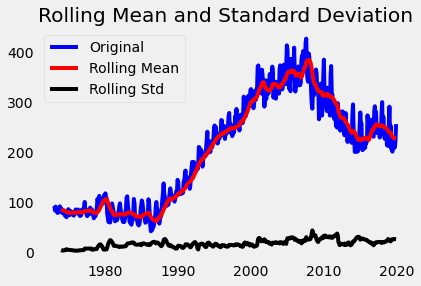

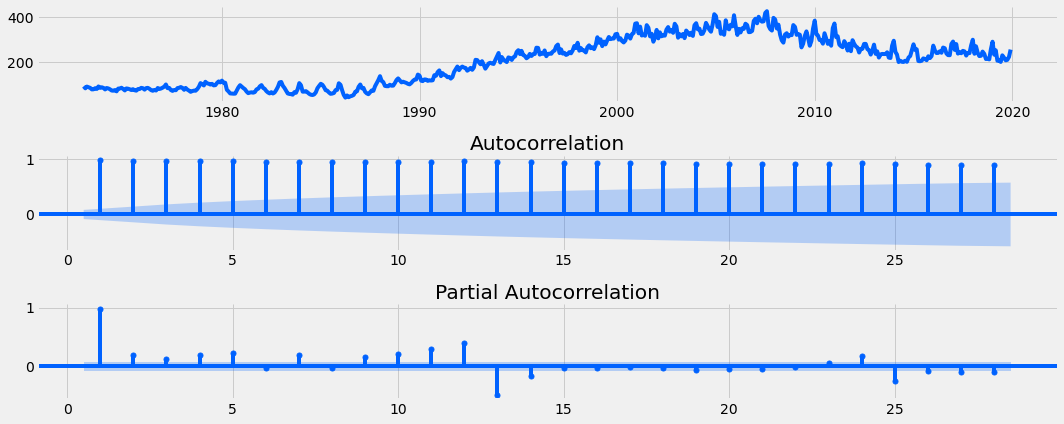

In [427]:
dftest(usngpdpro_m)
plots(usngpdpro_m)

There appears to be 12 month seasonality present, due to the autocorrelation with 13th and 25th lags. We can see this by looking at the last 10 years. 

<AxesSubplot:xlabel='Month'>

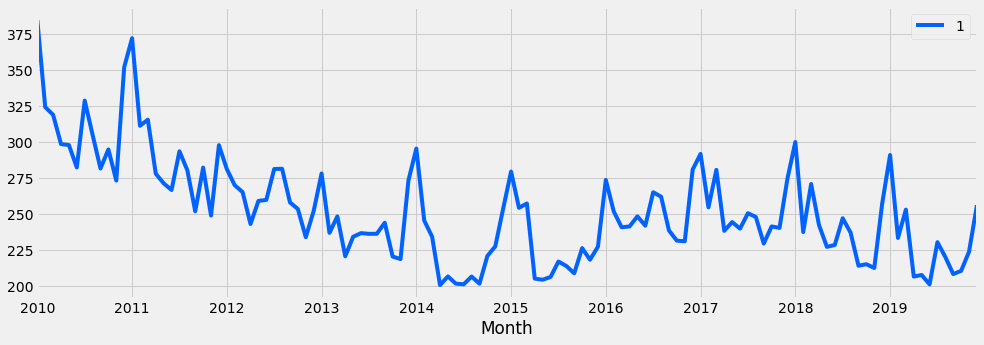

In [428]:
usngpdpro_m[-120:].plot(figsize = (15, 5))

In [429]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=usngpdpro_m, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
usngpdpro_m_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()

<AxesSubplot:xlabel='Month'>

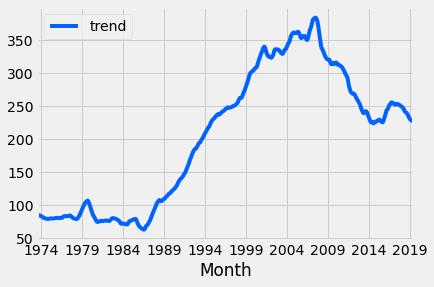

In [430]:
usngpdpro_m_ = pd.DataFrame(usngpdpro_m_)#[6:-6])
usngpdpro_mtrend = pd.DataFrame(estimated_trend[6:-6])
usngpdpro_mseasonal = pd.DataFrame(estimated_seasonal[6:-6])
usngpdpro_mresidual = pd.DataFrame(estimated_residual[6:-6])
usngpdpro_mtrend.plot()

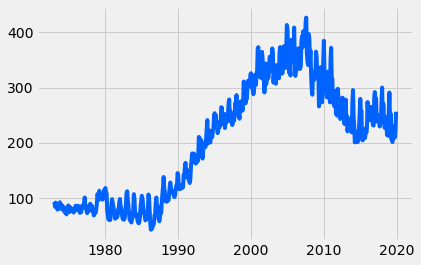

In [431]:
plt.plot(usngpdpro_m)

Test Statistic          -9.3
p-value                  0.0
Lags Used               19.0
Observations Used      532.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


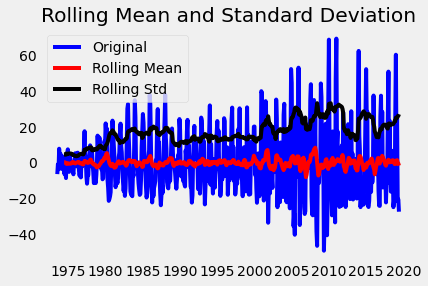

In [432]:
dftest(usngpdpro_m_)

MSE: 487.1076703278822 R-Squared: 0.10672639771264825


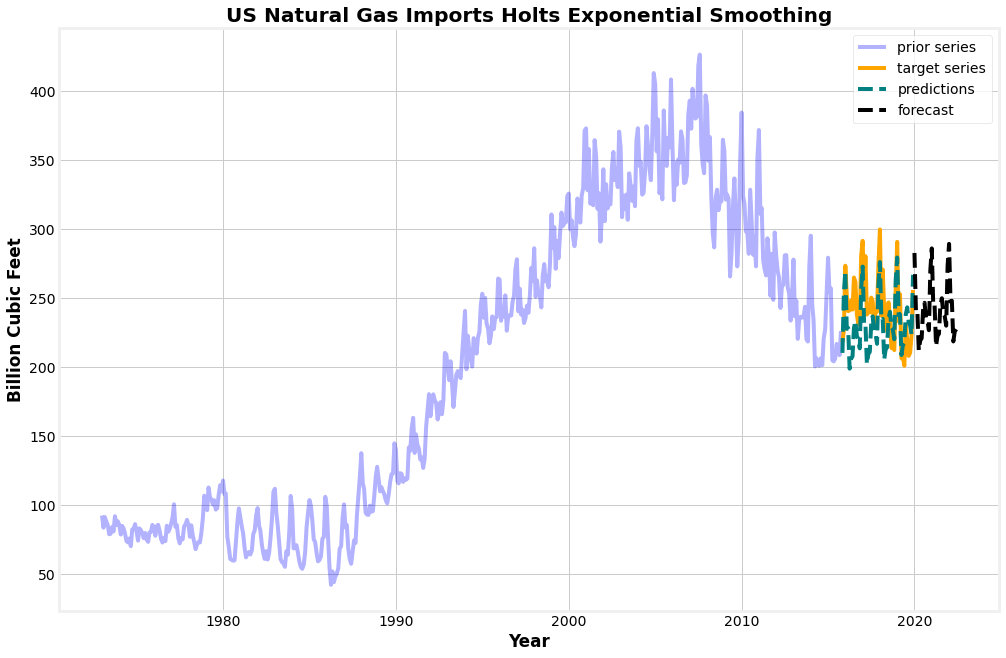

In [433]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(usngpdpro_m[:-50],
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(usngpdpro[-50:]) + 30)
triple_mse = mse(usngpdpro_m[-50:], triple_preds[:-30])
triple_r2 = r2(usngpdpro_m[-50:], triple_preds[:-30])
print('MSE:', triple_mse, 'R-Squared:', triple_r2)
#print('R-Squared', triple_r2)

fig, ax = plt.subplots(figsize=(15, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
#ax.plot(usngpdpro, color = 'black', alpha = 0.3, label = 'prior series')
ax.plot(usngpdpro_m[:-50], color = 'blue', alpha = 0.3, label = 'prior series')
ax.plot(usngpdpro_m[-50:], color = 'orange', label = 'target series')
ax.plot(triple_preds[:-30], color = 'teal', linestyle = 'dashed', label = 'predictions')
ax.plot(triple_preds[-30:], color = 'black', linestyle = 'dashed', label = 'forecast')
ax.legend(loc = 'best', facecolor = 'white')
ax.set_title('US Natural Gas Imports Holts Exponential Smoothing', fontweight = 'bold')
ax.set_ylabel('Billion Cubic Feet', fontweight = 'bold')
ax.set_xlabel('Year', fontweight = 'bold')
fig.set_facecolor('white')
ax.set_facecolor('white')

In [ ]:
usngpdpro_m_model = pm.auto_arima(usngpdpro_m, start_p=0, start_q=0,
                           max_p=2, max_q=2, start_d=0, max_d=1, m=12,
                           start_P=0, start_Q=0, max_P = 1, max_Q = 1, seasonal=True,
                            D=1, max_D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(usngpdpro_m_model.aic())

In [ ]:
usngpdpro_marima = sm.tsa.statespace.SARIMAX(usngpdpro_m,     ##hhgas
                                order=(0,1,1), 
                                seasonal_order=(0,1,1,12), ##None
                                trend='c').fit()
usngpdpro_marima.summary()

In [ ]:
plots(usngpdproarima.resid[usngpdproarima.loglikelihood_burn:])

In [ ]:
dftest(usngpdproarima.resid)

In [438]:
imports = usngpdpro_m
sc = MinMaxScaler(feature_range = (0,1))
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=imports, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual= ss_decomposition.resid
df_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()
df_ = pd.DataFrame(df_)#[6:-6])
df_trend = pd.DataFrame(estimated_trend[6:-6])
df_seasonal = pd.DataFrame(estimated_seasonal[6:-6])
df_residual = pd.DataFrame(estimated_residual[6:-6])
df = df_
input_months= 12 #sample size
test_months = 48#test portion of forecast series in months
n_steps = 72
sample_gap = 1
series_name = df[df.columns[0]].name
series_years = 12 #forecast series length
trend_years = 2.5
trend_input_months = 6
trend_test_months = 12
trend_n_steps = (n_steps -(test_months-input_months)) + trend_test_months - trend_input_months
prior = df[:-test_months]
    #prior_origin = np.array(df_origin[:-test_months])
title = 'US Natural Gas Imports'
ylabel = 'Billion Cubic Feet'

In [439]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y = \
data.get_train_test_data()

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/10
63/63 [==============================] - 40s 636ms/step - loss: 0.1657 - val_loss: 0.1507
Epoch 2/10
63/63 [==============================] - 1s 14ms/step - loss: 0.1156 - val_loss: 0.1051
Epoch 3/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0730 - val_loss: 0.0712
Epoch 4/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0463 - val_loss: 0.0615
Epoch 5/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0468 - val_loss: 0.0728
Epoch 6/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0542 - val_loss: 0.0698
Epoch 7/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0470 - val_loss: 0.0622
Epoch 8/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0410 - val_loss: 0.0610
Epoch 9/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0413 - val_loss: 0.0629
Epoch 10/10
63/63 [=========================

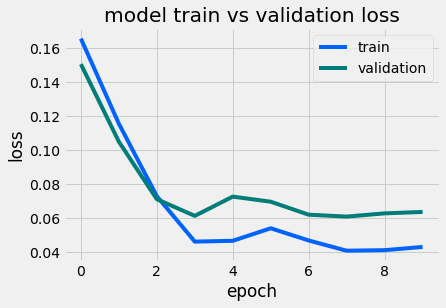

no of samples 12.0
Train on 9 samples, validate on 3 samples
Epoch 1/10
9/9 [==============================] - 38s 4s/step - loss: 0.8243 - val_loss: 0.3841
Epoch 2/10
9/9 [==============================] - 0s 20ms/step - loss: 0.7906 - val_loss: 0.3630
Epoch 3/10
9/9 [==============================] - 0s 24ms/step - loss: 0.7575 - val_loss: 0.3425
Epoch 4/10
9/9 [==============================] - 0s 25ms/step - loss: 0.7251 - val_loss: 0.3224
Epoch 5/10
9/9 [==============================] - 0s 15ms/step - loss: 0.6932 - val_loss: 0.3028
Epoch 6/10
9/9 [==============================] - 0s 22ms/step - loss: 0.6619 - val_loss: 0.2836
Epoch 7/10
9/9 [==============================] - 0s 24ms/step - loss: 0.6309 - val_loss: 0.2649
Epoch 8/10
9/9 [==============================] - 0s 22ms/step - loss: 0.6004 - val_loss: 0.2465
Epoch 9/10
9/9 [==============================] - 0s 20ms/step - loss: 0.5701 - val_loss: 0.2285
Epoch 10/10
9/9 [==============================] - 0s 22ms/step - l

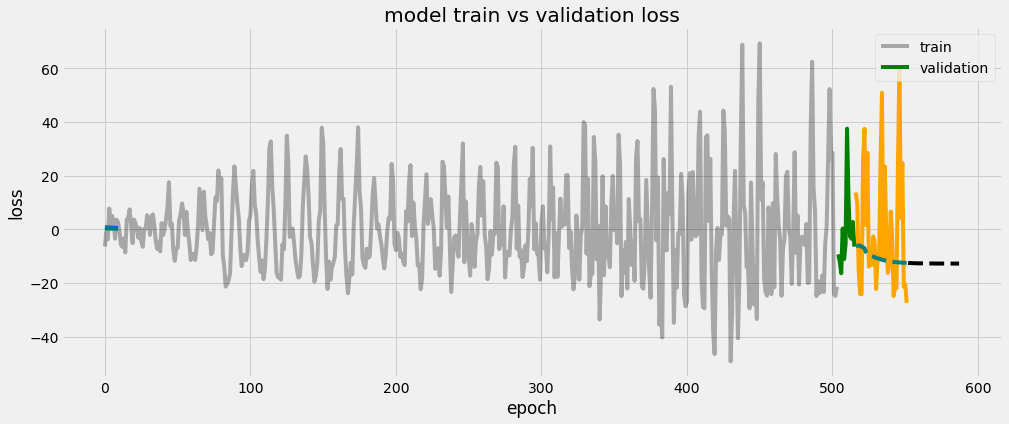

(613.1856561182083, -0.015589498209193975)


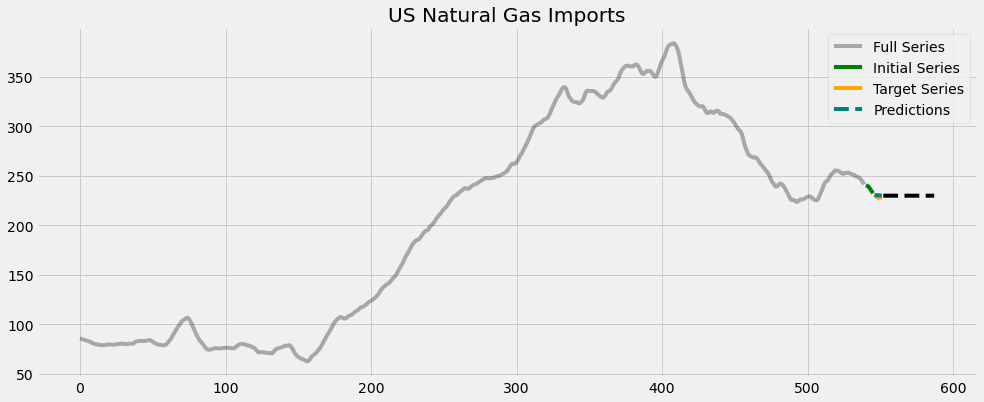

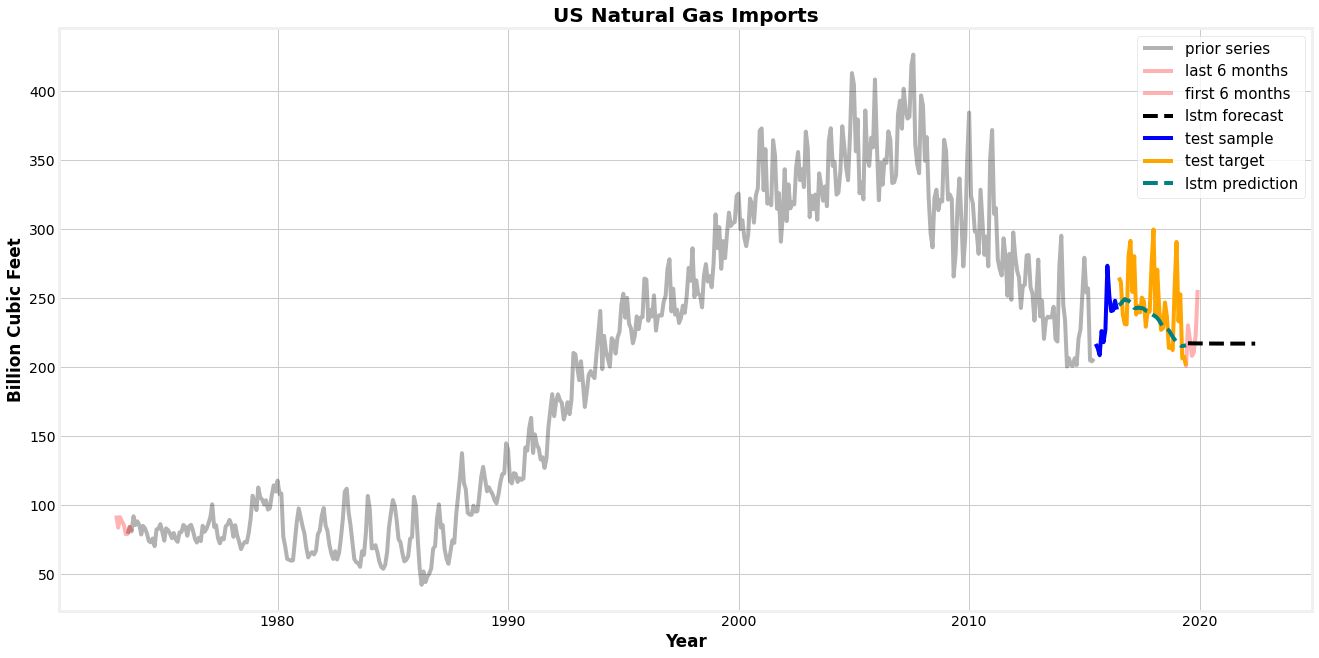

In [436]:
forecasting(imports, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 10, 10)

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/10
63/63 [==============================] - 40s 640ms/step - loss: 0.1803 - val_loss: 0.1657
Epoch 2/10
63/63 [==============================] - 1s 13ms/step - loss: 0.1293 - val_loss: 0.1181
Epoch 3/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0841 - val_loss: 0.0795
Epoch 4/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0514 - val_loss: 0.0606
Epoch 5/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0433 - val_loss: 0.0690
Epoch 6/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0535 - val_loss: 0.0723
Epoch 7/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0502 - val_loss: 0.0640
Epoch 8/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0421 - val_loss: 0.0605
Epoch 9/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0403 - val_loss: 0.0620
Epoch 10/10
63/63 [=========================

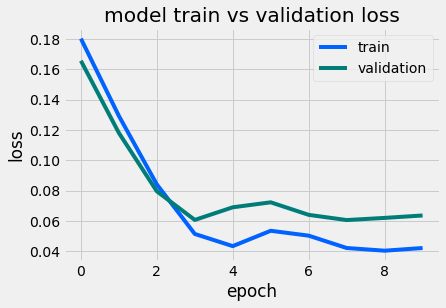

no of samples 12.0
Train on 9 samples, validate on 3 samples
Epoch 1/10
9/9 [==============================] - 41s 5s/step - loss: 0.3236 - val_loss: 0.0173
Epoch 2/10
9/9 [==============================] - 0s 26ms/step - loss: 0.3074 - val_loss: 0.0146
Epoch 3/10
9/9 [==============================] - 0s 15ms/step - loss: 0.2918 - val_loss: 0.0123
Epoch 4/10
9/9 [==============================] - 0s 23ms/step - loss: 0.2766 - val_loss: 0.0103
Epoch 5/10
9/9 [==============================] - 0s 21ms/step - loss: 0.2619 - val_loss: 0.0086
Epoch 6/10
9/9 [==============================] - 0s 15ms/step - loss: 0.2476 - val_loss: 0.0073
Epoch 7/10
9/9 [==============================] - 0s 15ms/step - loss: 0.2341 - val_loss: 0.0062
Epoch 8/10
9/9 [==============================] - 0s 22ms/step - loss: 0.2205 - val_loss: 0.0054
Epoch 9/10
9/9 [==============================] - 0s 18ms/step - loss: 0.2072 - val_loss: 0.0049
Epoch 10/10
9/9 [==============================] - 0s 20ms/step - l

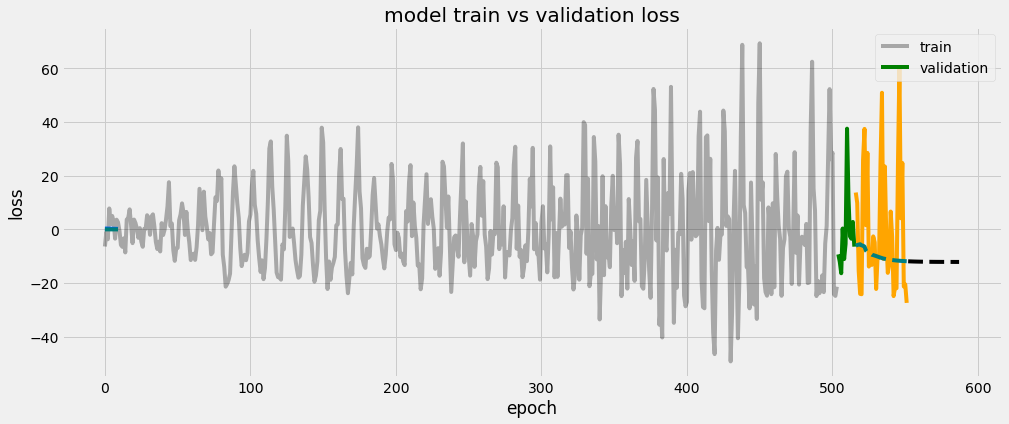

(601.351844881538, 0.00401026622729761)


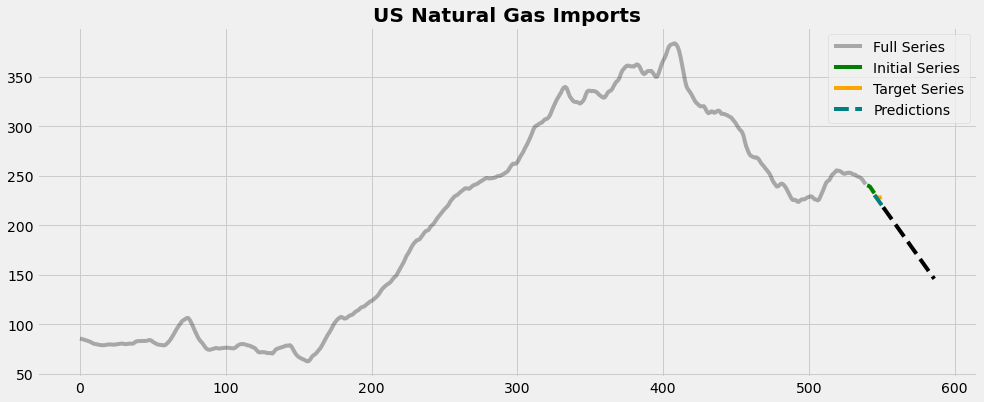

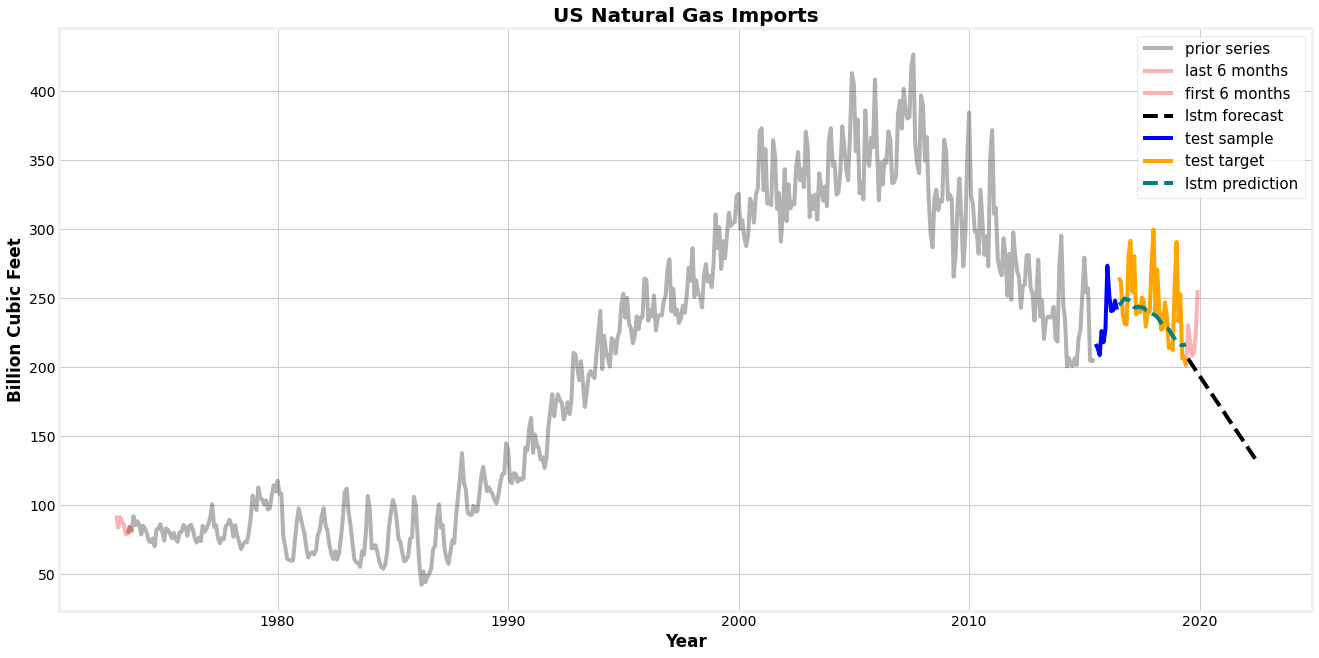

In [440]:
forecasting_trend(imports, df_trend, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months,  trend_n_steps, n_steps, 10, 10)

## Natural Gas Exports

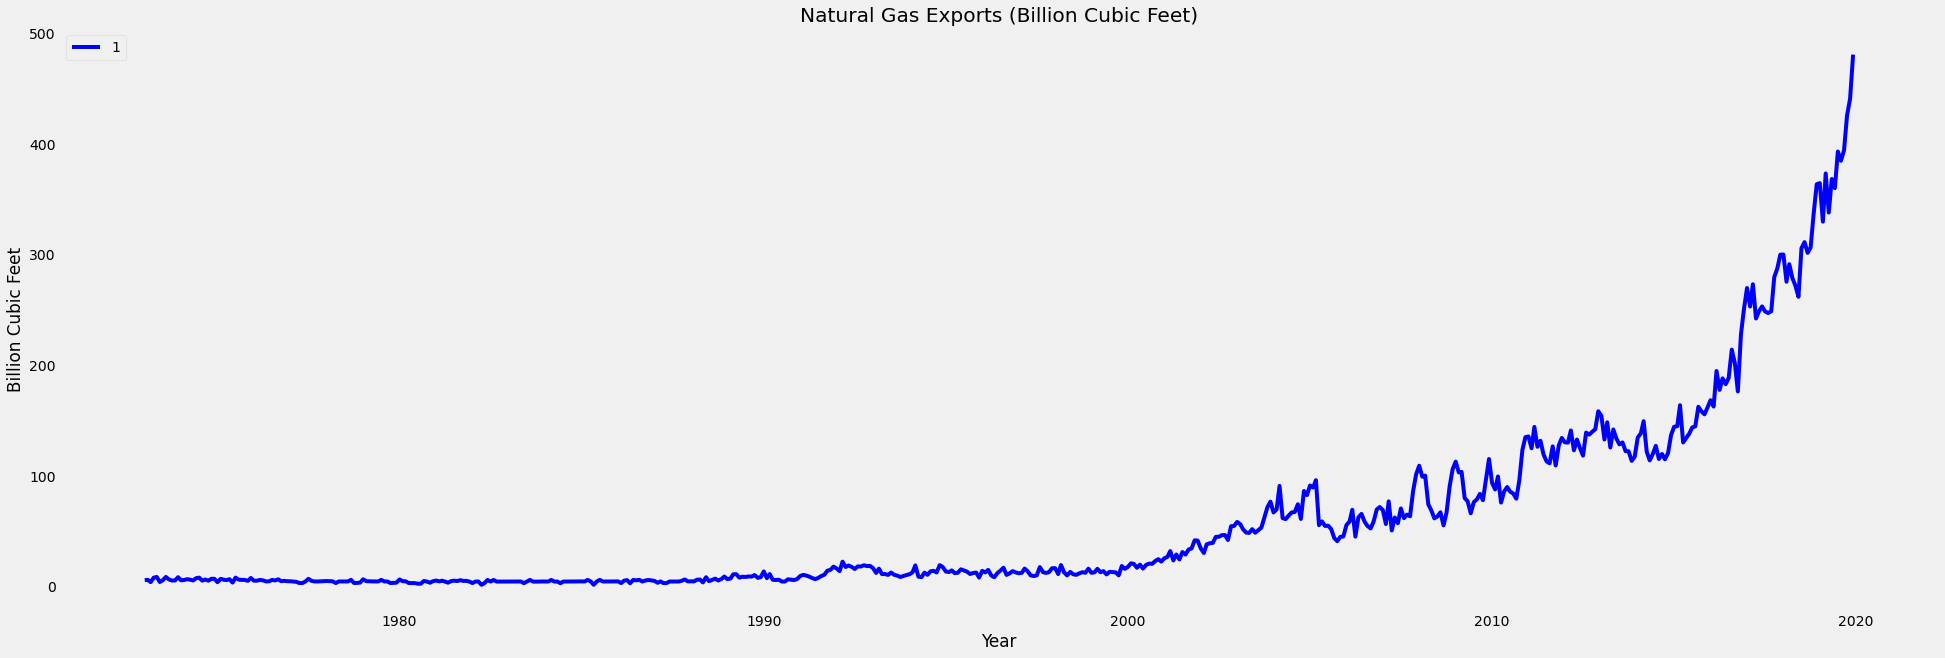

In [558]:
usngpdpro_m = us_ngpd[['year', us_ngpd.columns[8]]].dropna()
usngpdpro_m  = usngpdpro_m[usngpdpro_m['year'] >=1970]
usngpdpro_m = usngpdpro_m[usngpdpro_m['year']<2020]
usngpdpro_mtest = np.array(usngpdpro_m, dtype = 'float64')
usngpdpro_mtest = pd.DataFrame(usngpdpro_mtest)
usngpdpro_mtest.index = usngpdpro_m.index
usngpdpro_m = usngpdpro_mtest
usngpdpro_m = usngpdpro_m[[usngpdpro_m.columns[-1]]]
usngpdpro_mlegend = usngpdpro_m.columns[-1]
run_sequence_plot(usngpdpro_m.index, np.array(usngpdpro_m), usngpdpro_mlegend, title = us_ngpd.columns[8], xlabel = 'Year', ylabel ='Billion Cubic Feet')

Test Statistic           4.7
p-value                  1.0
Lags Used               14.0
Observations Used      549.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
non stationary, we cannot reject the null that it is non-stationary with > 90% confidence


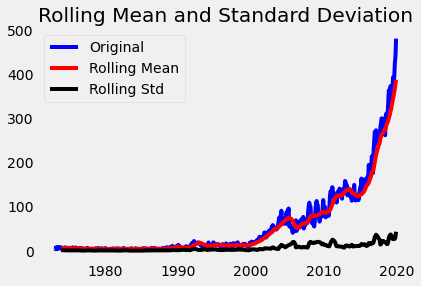

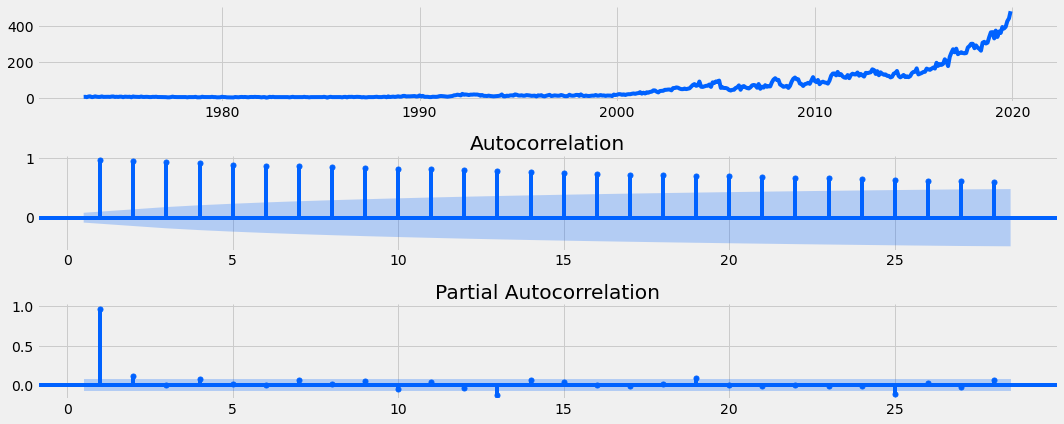

In [559]:
dftest(usngpdpro_m)
plots(usngpdpro_m)

There doesn't appear to be any 12-month seasonality, just high autocorrelation with lag-1 as the series is exponential

<AxesSubplot:xlabel='Month'>

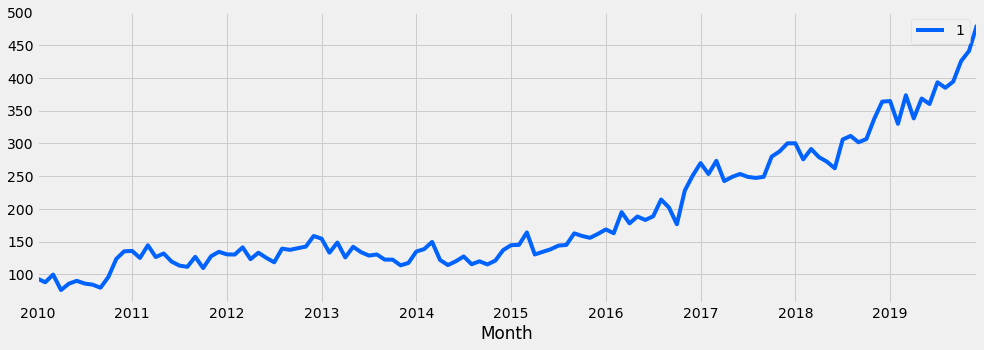

In [560]:
usngpdpro_m[-120:].plot(figsize = (15, 5))

In [561]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=usngpdpro_m, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
usngpdpro_m_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()

Test Statistic         -10.1
p-value                  0.0
Lags Used               12.0
Observations Used      539.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


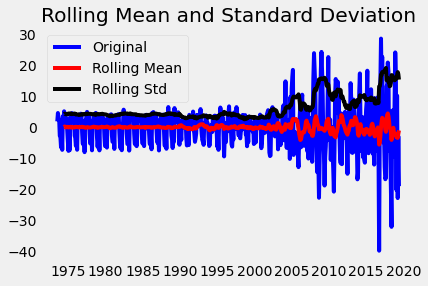

In [564]:
usngpdpro_m_ = pd.DataFrame(usngpdpro_m_)#[6:-6])
usngpdpro_mtrend = pd.DataFrame(estimated_trend[6:-6])
usngpdpro_mseasonal = pd.DataFrame(estimated_seasonal[6:-6])
usngpdpro_mresidual = pd.DataFrame(estimated_residual[6:-6])
dftest(usngpdpro_mresidual)

This series has a heteroskedastic residual. We transform the series by taking the log.

<AxesSubplot:xlabel='Month'>

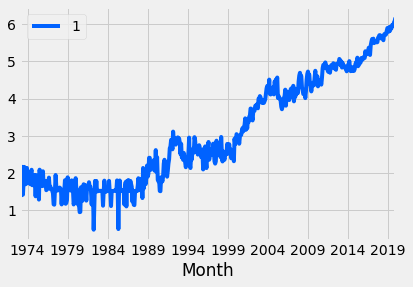

In [482]:
original = usngpdpro_m
usngpdpro_m = np.log(usngpdpro_m)
usngpdpro_m.plot()

In [483]:
ss_decomposition = seasonal_decompose(x=usngpdpro_m, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
usngpdpro_m_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()

<AxesSubplot:xlabel='Month'>

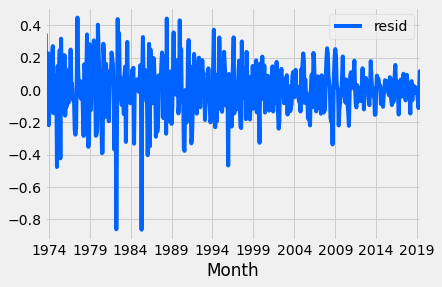

In [484]:
usngpdpro_m_ = pd.DataFrame(usngpdpro_m_)#[6:-6])
usngpdpro_mtrend = pd.DataFrame(estimated_trend[6:-6])
usngpdpro_mseasonal = pd.DataFrame(estimated_seasonal[6:-6])
usngpdpro_mresidual = pd.DataFrame(estimated_residual[6:-6])
usngpdpro_mresidual.plot()

Test Statistic          -9.1
p-value                  0.0
Lags Used               14.0
Observations Used      537.0
Critical Value (1%)     -3.4
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


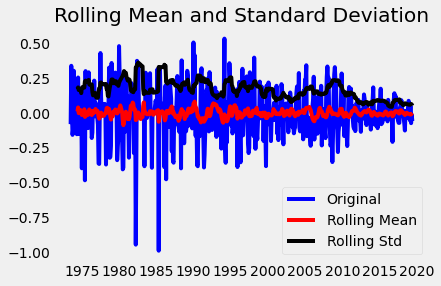

In [485]:
dftest(usngpdpro_m_)

MSE: 27408.818220763333 R-Squared: -339694.3725306834


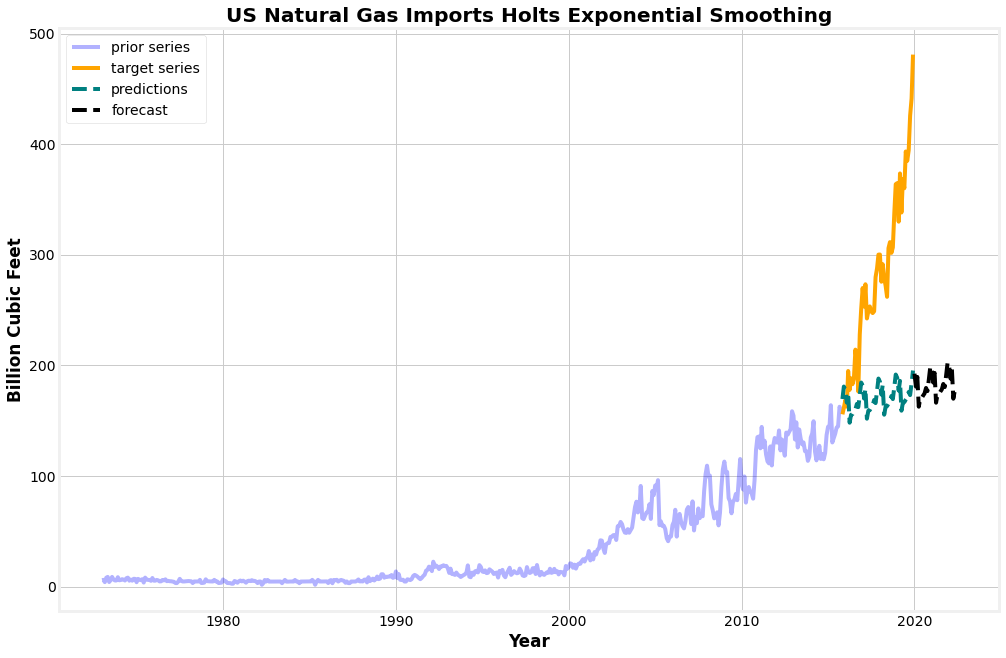

In [487]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(original[:-50],
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(usngpdpro[-50:]) + 30)
triple_mse = mse(usngpdpro_m[-50:], triple_preds[:-30])
triple_r2 = r2(usngpdpro_m[-50:], triple_preds[:-30])
print('MSE:', triple_mse, 'R-Squared:', triple_r2)
#print('R-Squared', triple_r2)

fig, ax = plt.subplots(figsize=(15, 10))
        #fig2, ax2 = plt.subplots(figsize=(15, 10))
#ax.plot(usngpdpro, color = 'black', alpha = 0.3, label = 'prior series')
ax.plot(original[:-50], color = 'blue', alpha = 0.3, label = 'prior series')
ax.plot(original[-50:], color = 'orange', label = 'target series')
ax.plot(triple_preds[:-30], color = 'teal', linestyle = 'dashed', label = 'predictions')
ax.plot(triple_preds[-30:], color = 'black', linestyle = 'dashed', label = 'forecast')
ax.legend(loc = 'best', facecolor = 'white')
ax.set_title('US Natural Gas Imports Holts Exponential Smoothing', fontweight = 'bold')
ax.set_ylabel('Billion Cubic Feet', fontweight = 'bold')
ax.set_xlabel('Year', fontweight = 'bold')
fig.set_facecolor('white')
ax.set_facecolor('white')

In [ ]:
usngpdpro_m_model = pm.auto_arima(usngpdpro_m, start_p=0, start_q=0,
                           max_p=2, max_q=2, start_d=0, max_d=1, m=12,
                           start_P=0, start_Q=0, max_P = 1, max_Q = 1, seasonal=True,
                            D=1, max_D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(usngpdpro_m_model.aic())

In [ ]:
usngpdpro_marima = sm.tsa.statespace.SARIMAX(usngpdpro_m,     ##hhgas
                                order=(0,1,1), 
                                seasonal_order=(0,1,1,12), ##None
                                trend='c').fit()
usngpdpro_marima.summary()

<AxesSubplot:xlabel='Month'>

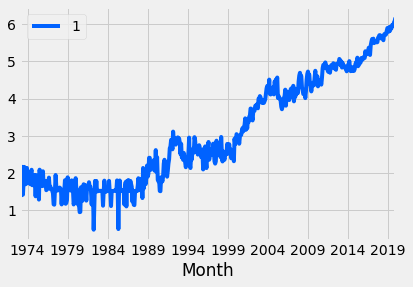

In [533]:
#plots(usngpdproarima.resid[usngpdproarima.loglikelihood_burn:])


In [ ]:
dftest(usngpdproarima.resid)

In [549]:
exports = usngpdpro_m
sc = MinMaxScaler(feature_range = (0,1))
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=exports, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual= ss_decomposition.resid
df_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()
df_ = pd.DataFrame(df_)#[6:-6])
df_trend = pd.DataFrame(estimated_trend[6:-6])
df_seasonal = pd.DataFrame(estimated_seasonal[6:-6])
df_residual = pd.DataFrame(estimated_residual[6:-6])
df = df_
input_months= 12 #sample size
test_months = 48#test portion of forecast series in months
n_steps = 72
sample_gap = 1
series_name = df[df.columns[0]].name
series_years = 12 #forecast series length
trend_years = 4
trend_input_months = 12
trend_test_months = 24
trend_n_steps = (n_steps -(test_months-input_months)) + trend_test_months - trend_input_months
prior = df[:-test_months]
#prior_origin = np.array(df_origin[:-test_months])
title = 'US Natural Gas Exports'
ylabel = 'Billion Cubic Feet'

In [550]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y = \
data.get_train_test_data()

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/10
63/63 [==============================] - 46s 735ms/step - loss: 0.2522 - val_loss: 0.1716
Epoch 2/10
63/63 [==============================] - 1s 14ms/step - loss: 0.1770 - val_loss: 0.1048
Epoch 3/10
63/63 [==============================] - 1s 14ms/step - loss: 0.1125 - val_loss: 0.0511
Epoch 4/10
63/63 [==============================] - 1s 12ms/step - loss: 0.0642 - val_loss: 0.0209
Epoch 5/10
63/63 [==============================] - 1s 12ms/step - loss: 0.0460 - val_loss: 0.0274
Epoch 6/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0591 - val_loss: 0.0374
Epoch 7/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0614 - val_loss: 0.0272
Epoch 8/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0503 - val_loss: 0.0195
Epoch 9/10
63/63 [==============================] - 1s 17ms/step - loss: 0.0452 - val_loss: 0.0198
Epoch 10/10
63/63 [=========================

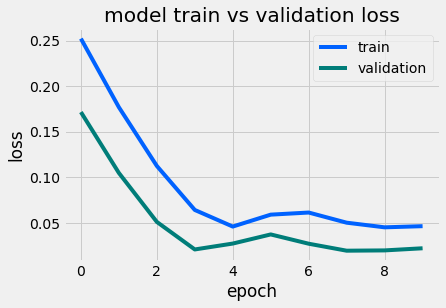

no of samples 12.0
Train on 9 samples, validate on 3 samples
Epoch 1/50
9/9 [==============================] - 46s 5s/step - loss: 0.1704 - val_loss: 0.2732
Epoch 2/50
9/9 [==============================] - 0s 38ms/step - loss: 0.1533 - val_loss: 0.2438
Epoch 3/50
9/9 [==============================] - 0s 34ms/step - loss: 0.1369 - val_loss: 0.2156
Epoch 4/50
9/9 [==============================] - 0s 35ms/step - loss: 0.1211 - val_loss: 0.1884
Epoch 5/50
9/9 [==============================] - 1s 60ms/step - loss: 0.1058 - val_loss: 0.1620
Epoch 6/50
9/9 [==============================] - 0s 53ms/step - loss: 0.0910 - val_loss: 0.1372
Epoch 7/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0771 - val_loss: 0.1127
Epoch 8/50
9/9 [==============================] - 1s 73ms/step - loss: 0.0633 - val_loss: 0.0892
Epoch 9/50
9/9 [==============================] - 0s 40ms/step - loss: 0.0502 - val_loss: 0.0671
Epoch 10/50
9/9 [==============================] - 0s 37ms/step - l

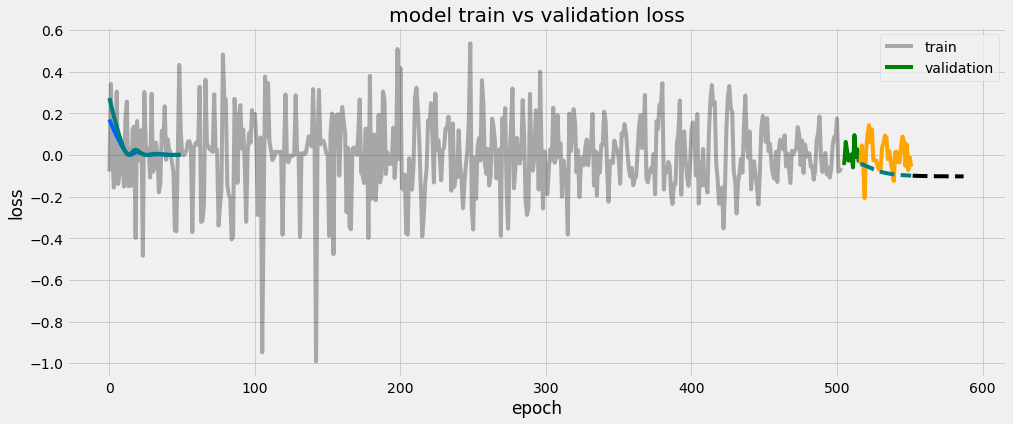

(909.9364598971044, 0.6382718770635786)


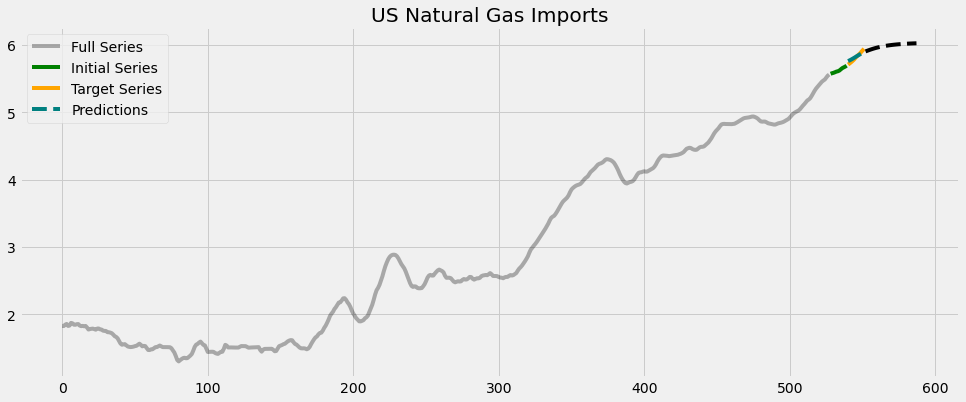

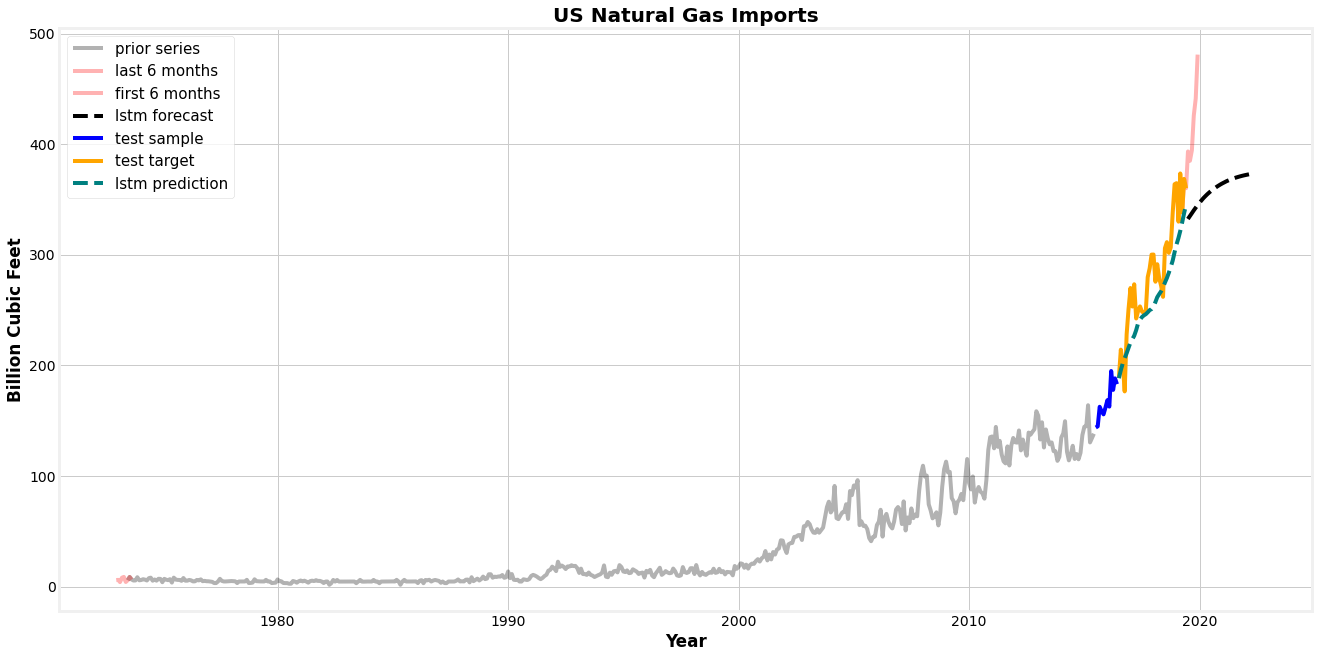

In [522]:
forecasting_exp(exports, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 10, 50)

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/10
63/63 [==============================] - 54s 854ms/step - loss: 0.2567 - val_loss: 0.1847
Epoch 2/10
63/63 [==============================] - 1s 12ms/step - loss: 0.1941 - val_loss: 0.1274
Epoch 3/10
63/63 [==============================] - 1s 13ms/step - loss: 0.1363 - val_loss: 0.0740
Epoch 4/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0846 - val_loss: 0.0322
Epoch 5/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0501 - val_loss: 0.0198
Epoch 6/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0508 - val_loss: 0.0366
Epoch 7/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0638 - val_loss: 0.0328
Epoch 8/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0548 - val_loss: 0.0213
Epoch 9/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0457 - val_loss: 0.0191
Epoch 10/10
63/63 [=========================

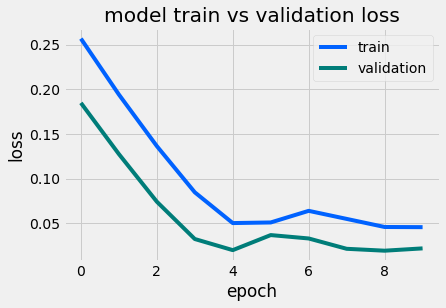

no of samples 12.0
Train on 9 samples, validate on 3 samples
Epoch 1/50
9/9 [==============================] - 50s 6s/step - loss: 0.5127 - val_loss: 0.3651
Epoch 2/50
9/9 [==============================] - 0s 52ms/step - loss: 0.4772 - val_loss: 0.3351
Epoch 3/50
9/9 [==============================] - 0s 40ms/step - loss: 0.4437 - val_loss: 0.3065
Epoch 4/50
9/9 [==============================] - 0s 38ms/step - loss: 0.4117 - val_loss: 0.2791
Epoch 5/50
9/9 [==============================] - 0s 36ms/step - loss: 0.3809 - val_loss: 0.2525
Epoch 6/50
9/9 [==============================] - 0s 29ms/step - loss: 0.3511 - val_loss: 0.2264
Epoch 7/50
9/9 [==============================] - 0s 31ms/step - loss: 0.3218 - val_loss: 0.2006
Epoch 8/50
9/9 [==============================] - 0s 35ms/step - loss: 0.2928 - val_loss: 0.1750
Epoch 9/50
9/9 [==============================] - 0s 34ms/step - loss: 0.2642 - val_loss: 0.1498
Epoch 10/50
9/9 [==============================] - 0s 35ms/step - l

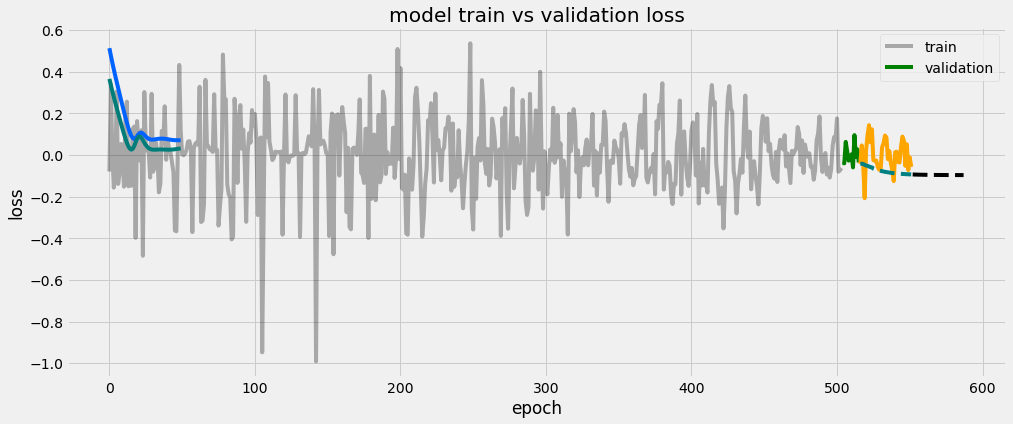

(849.2971951375972, 0.6623778760914465)


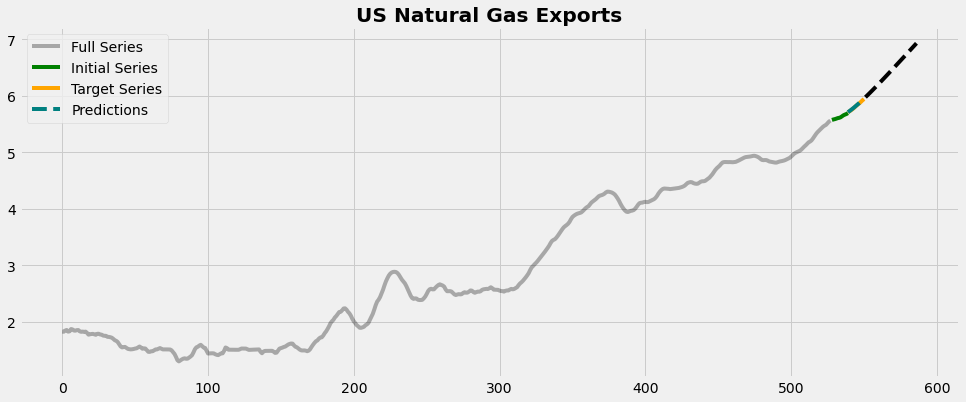

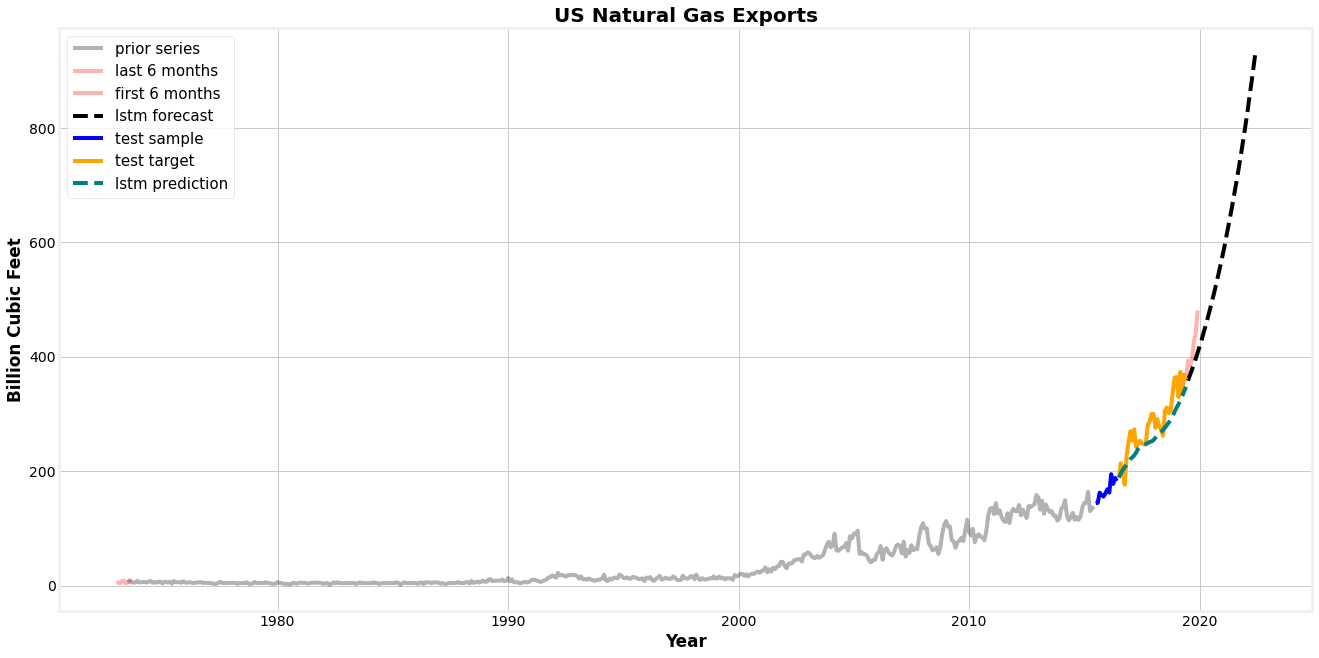

In [551]:
forecasting_trend_exp(exports, df_trend, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months,  trend_n_steps, n_steps, 10, 50)

## Non-Seasonal, non-stationary series:  Henry Hub Gas Prices

In [38]:
hhgasprice_2 = pd.read_excel('RNGWHHDd.xls', sheet_name = 1)
hhgasprice_2.drop(range(1), inplace = True)
hhgasprice_2.rename(columns = hhgasprice_2.iloc[0], inplace = True)
hhgasprice_2.drop(1, inplace = True)
hhgasprice_2['Date'] = pd.to_datetime(hhgasprice_2['Date'])
hhgasprice_2.insert(0, 'year', hhgasprice_2['Date'].dt.year)
hhgasprice_2.insert(1, 'Month', hhgasprice_2['Date'].dt.month)
hhgasprice_2.insert(3, 'Day', hhgasprice_2['Date'].dt.day)
hhgasprice_2['Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'] = np.array(hhgasprice_2['Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'], dtype = 'float64')
hhgasprice_2.set_index('Date', inplace = True)
hhgasprice_2.head()

year  Month  Day  \
Date                           
1997-01-07  1997      1    7   
1997-01-08  1997      1    8   
1997-01-09  1997      1    9   
1997-01-10  1997      1   10   
1997-01-13  1997      1   13   

            Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  
Date                                                                    
1997-01-07                                                3.8           
1997-01-08                                                3.8           
1997-01-09                                                3.6           
1997-01-10                                                3.9           
1997-01-13                                                4.0

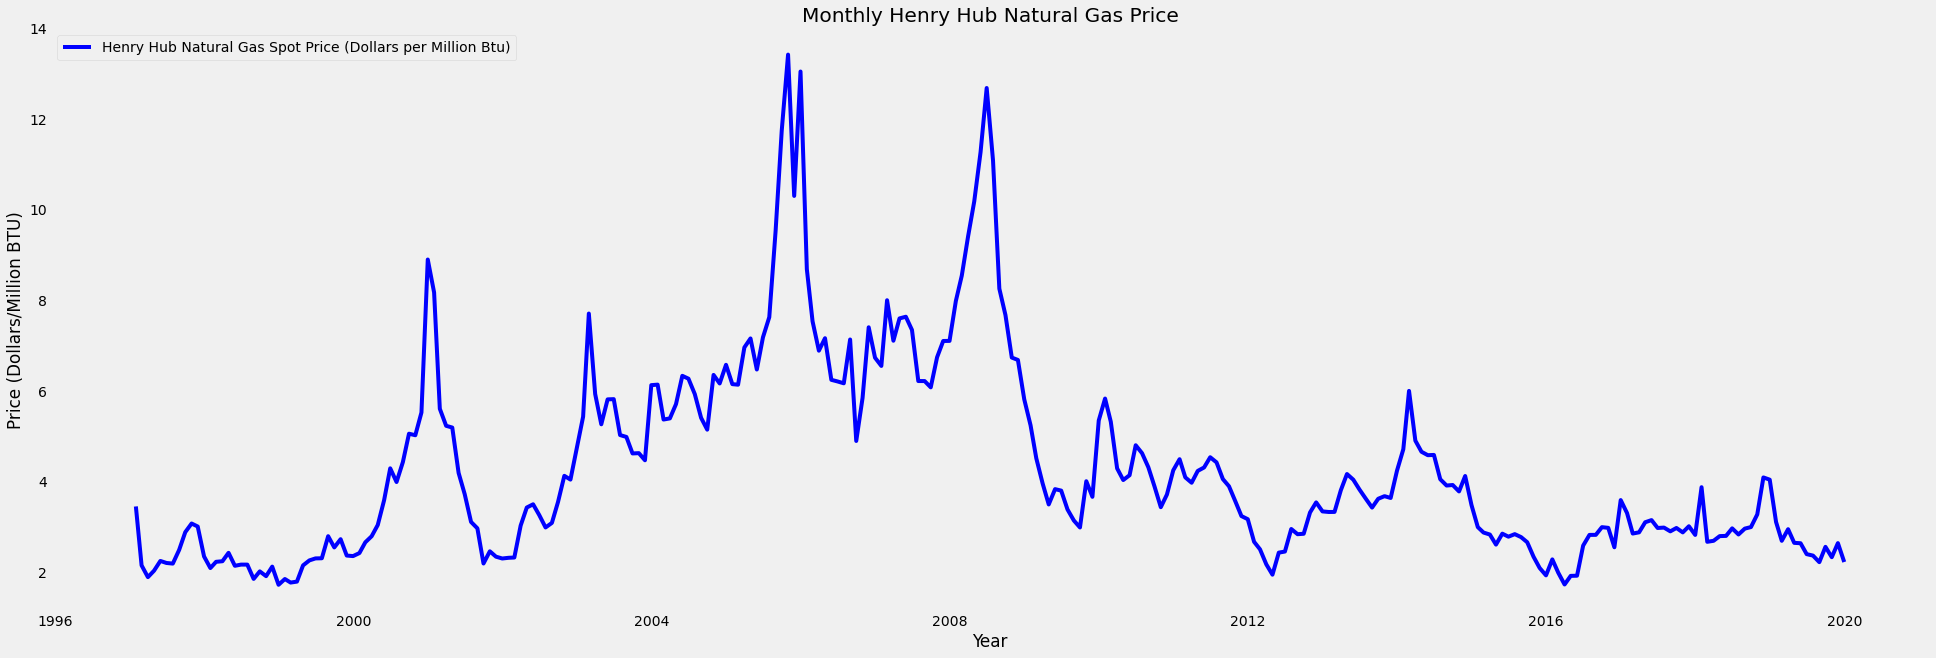

In [39]:
hhgas = hhgasprice_2[['year', hhgasprice_2.columns[-1]]].dropna().resample('M').mean()
hhgas = hhgas[hhgas['year'] > 1980]
hhgas = hhgas[hhgas['year'] < 2020]
hhgas = hhgas[[hhgas.columns[-1]]]
hhgaslegend = hhgas.columns[-1]
run_sequence_plot(hhgas.index, hhgas, hhgaslegend, title = 'Monthly Henry Hub Natural Gas Price', xlabel = 'Year', ylabel ='Price (Dollars/Million BTU)')

There doesn't appear to be any 12-month seasonality, just high autocorrelation with lag-1 as the series is exponential

Test Statistic          -2.1
p-value                  0.3
Lags Used                9.0
Observations Used      266.0
Critical Value (1%)     -3.5
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
non stationary, we cannot reject the null that it is non-stationary with > 90% confidence


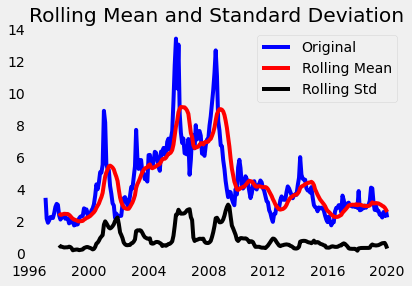

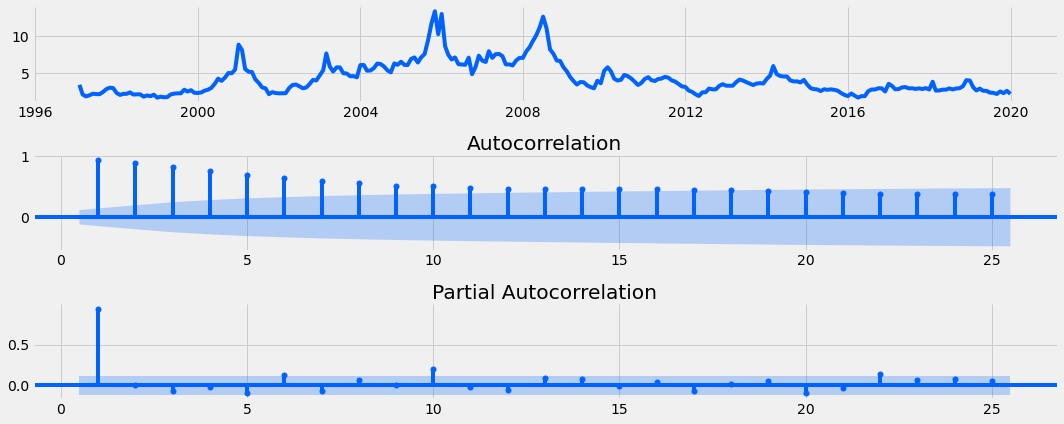

In [586]:
dftest(hhgas)
plots(hhgas)

<AxesSubplot:xlabel='Date'>

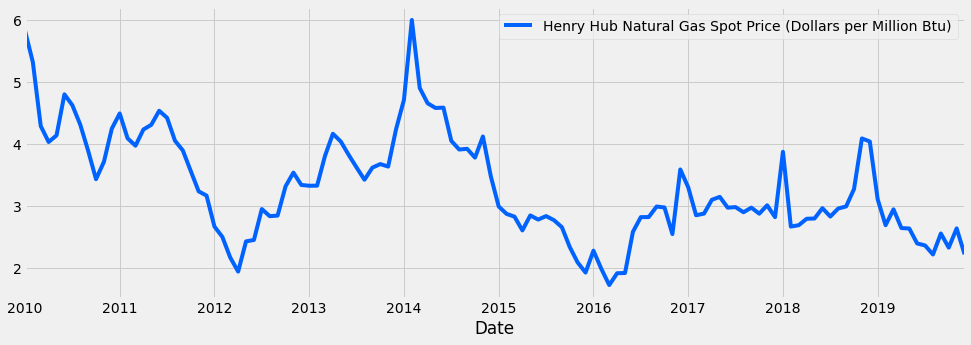

In [588]:
hhgas[-120:].plot(figsize = (15, 5))

No apparent seasonality

In [589]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=hhgas, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
hhgas_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()

Test Statistic          -7.9
p-value                  0.0
Lags Used               11.0
Observations Used      252.0
Critical Value (1%)     -3.5
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


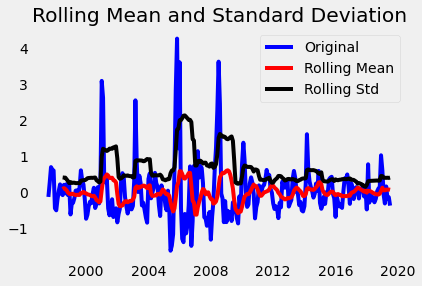

In [590]:
hhgas_ = pd.DataFrame(hhgas_)#[6:-6])
hhgas_trend = pd.DataFrame(estimated_trend[6:-6])
hhgas_seasonal = pd.DataFrame(estimated_seasonal[6:-6])
hhgas_residual = pd.DataFrame(estimated_residual[6:-6])
dftest(hhgas_residual)

<AxesSubplot:xlabel='Date'>

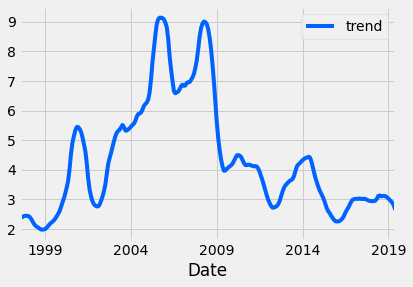

In [591]:
hhgas_trend.plot()

In [580]:
hhgasarima = sm.tsa.statespace.SARIMAX(hhgas,     ##hhgas
                                order=(1,1,1), 
                                seasonal_order=(1,1,1,9), ##None
                                trend='c').fit()
hhgasarima.summary()

KeyboardInterrupt: 

In [ ]:
plots(hhgasarima.resid[hhgasarima.loglikelihood_burn:])

In [ ]:
hhgas_model = pm.auto_arima(hhgas, start_p=0, start_q=0,
                           max_p=2, max_q=2, start_d=0, max_d=1, m=9, max_m=12,
                           start_P=0, start_Q=0, max_P = 1, max_Q = 1, seasonal=True,
                            D=1, max_D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(hhgas_model.aic())

In [ ]:
series = hhgas
horizon = 5
start = 50
step_size = 5
orders = [(1,0,0), (1,1,0), (0,1,0), (0,1,1)]
seasonal_orders = [(0,0,0,0), (0,1,0, 12)]
trends = [None, 'c']
grid_search_ARIMA(series,horizon,start,step_size,orders = orders,seasonal_orders = seasonal_orders,trends=trends)

In [ ]:
hhgasforecast = hhgasarima.get_forecast(steps = 72, dynamic = True)
hhgasforecast = hhgasforecast.summary_frame()
hhgasforecast.rename(columns = {'mean':'forecast'}, inplace = True)
train_hhgas = hhgas[:-50]
test_hhgas = hhgas[-50:]
predict_hhgas = pd.DataFrame(hhgasarima.predict(dynamic = False)[-50:])

In [611]:
df = hhgas
sc = MinMaxScaler(feature_range = (0,1))
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition_multi = seasonal_decompose(x=df, 
                                            model='additive', 
                                            period=12)
estimated_trend_multi = ss_decomposition_multi.trend
estimated_seasonal_multi = ss_decomposition_multi.seasonal
estimated_residual_multi = ss_decomposition_multi.resid
print(len(df) == len(estimated_trend_multi) == len(estimated_seasonal_multi) == len(estimated_residual_multi))
df_ = estimated_seasonal_multi[6:-6] + estimated_residual_multi[6:-6] #residual and trend, first and last six values are null
#estimated_trend_multi.plot()
df_ = pd.DataFrame(df_)#[6:-6])
df_trend = pd.DataFrame(estimated_trend_multi[6:-6])
df_seasonal = pd.DataFrame(estimated_seasonal_multi[6:-6])
df_residual = pd.DataFrame(estimated_residual_multi[6:-6])
df = df_
input_months= 12 #sample size
test_months = 48 #test portion of forecast series in months
n_steps = 72
sample_gap = 1
series_name = df[df.columns[0]].name
series_years = 12 #forecast series length
trend_years = 2.5
trend_input_months = 6
trend_test_months = 12
trend_n_steps = (n_steps -(test_months-input_months)) + trend_test_months - trend_input_months
prior = df[:-test_months]
    #prior_origin = np.array(df_origin[:-test_months])
title = 'Henry Hub Gas Price'
ylabel = 'Dollars/Million BTU'

True


In [612]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y = \
data.get_train_test_data()

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/50
63/63 [==============================] - 53s 838ms/step - loss: 0.0462 - val_loss: 0.0379
Epoch 2/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0308 - val_loss: 0.0220
Epoch 3/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0197 - val_loss: 0.0118
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0159 - val_loss: 0.0103
Epoch 5/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0185 - val_loss: 0.0110
Epoch 6/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0187 - val_loss: 0.0100
Epoch 7/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0166 - val_loss: 0.0101
Epoch 8/50
63/63 [==============================] - 1s 13ms/step - loss: 0.0155 - val_loss: 0.0112
Epoch 9/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0155 - val_loss: 0.0121
Epoch 10/50
63/63 [=========================

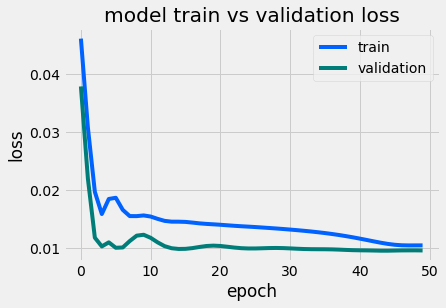

no of samples 12.0
Train on 9 samples, validate on 3 samples
Epoch 1/70
9/9 [==============================] - 52s 6s/step - loss: 0.4353 - val_loss: 0.5992
Epoch 2/70
9/9 [==============================] - 0s 20ms/step - loss: 0.4179 - val_loss: 0.5805
Epoch 3/70
9/9 [==============================] - 0s 20ms/step - loss: 0.4005 - val_loss: 0.5616
Epoch 4/70
9/9 [==============================] - 0s 22ms/step - loss: 0.3831 - val_loss: 0.5438
Epoch 5/70
9/9 [==============================] - 0s 26ms/step - loss: 0.3668 - val_loss: 0.5248
Epoch 6/70
9/9 [==============================] - 0s 18ms/step - loss: 0.3494 - val_loss: 0.5056
Epoch 7/70
9/9 [==============================] - 0s 24ms/step - loss: 0.3320 - val_loss: 0.4864
Epoch 8/70
9/9 [==============================] - 0s 20ms/step - loss: 0.3146 - val_loss: 0.4670
Epoch 9/70
9/9 [==============================] - 0s 16ms/step - loss: 0.2973 - val_loss: 0.4476
Epoch 10/70
9/9 [==============================] - 0s 22ms/step - l

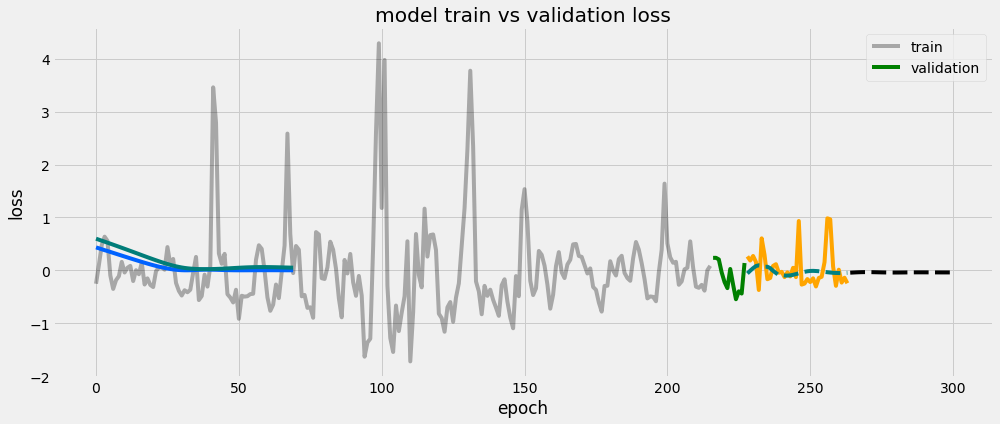

(0.12218571391655014, 0.11894216019893822)

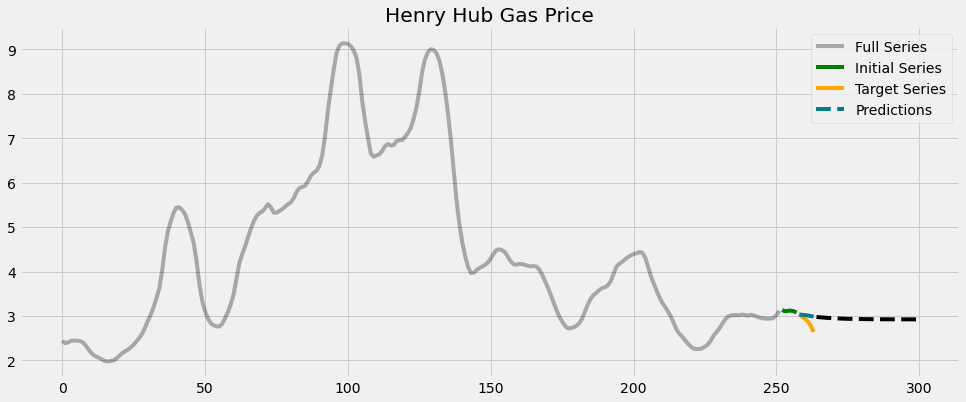

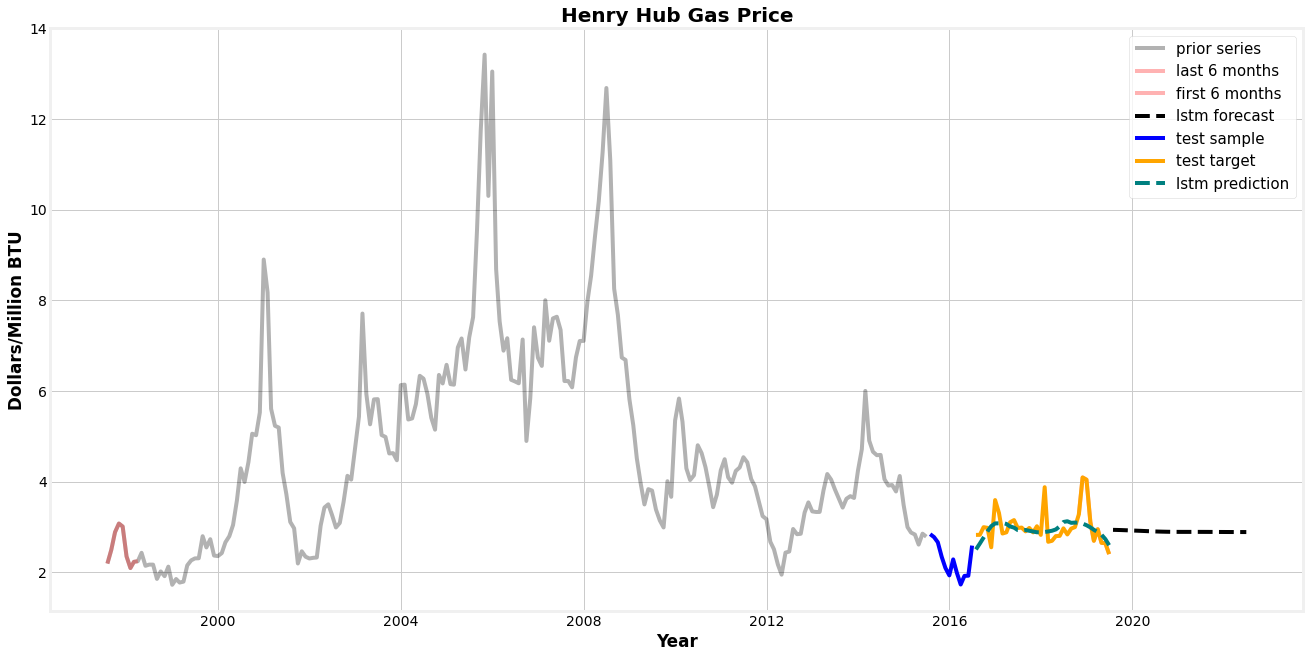

In [609]:
forecasting_full(hhgas[6:-6], title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 50, 70)

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/50
63/63 [==============================] - 53s 843ms/step - loss: 0.0559 - val_loss: 0.0496
Epoch 2/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0404 - val_loss: 0.0333
Epoch 3/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0273 - val_loss: 0.0194
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0179 - val_loss: 0.0109
Epoch 5/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0152 - val_loss: 0.0101
Epoch 6/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0178 - val_loss: 0.0109
Epoch 7/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0180 - val_loss: 0.0099
Epoch 8/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0159 - val_loss: 0.0098
Epoch 9/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0148 - val_loss: 0.0108
Epoch 10/50
63/63 [=========================

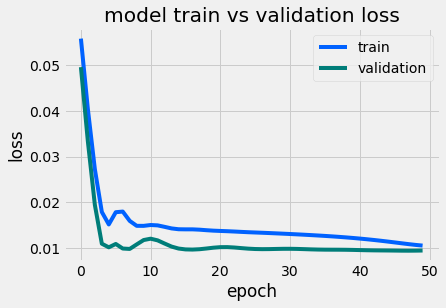

no of samples 12.0
Train on 9 samples, validate on 3 samples
Epoch 1/30
9/9 [==============================] - 53s 6s/step - loss: 0.2947 - val_loss: 0.6878
Epoch 2/30
9/9 [==============================] - 0s 20ms/step - loss: 0.2828 - val_loss: 0.6696
Epoch 3/30
9/9 [==============================] - 0s 20ms/step - loss: 0.2711 - val_loss: 0.6516
Epoch 4/30
9/9 [==============================] - 0s 22ms/step - loss: 0.2596 - val_loss: 0.6349
Epoch 5/30
9/9 [==============================] - 0s 20ms/step - loss: 0.2490 - val_loss: 0.6179
Epoch 6/30
9/9 [==============================] - 0s 20ms/step - loss: 0.2383 - val_loss: 0.6002
Epoch 7/30
9/9 [==============================] - 0s 31ms/step - loss: 0.2273 - val_loss: 0.5826
Epoch 8/30
9/9 [==============================] - 0s 24ms/step - loss: 0.2165 - val_loss: 0.5649
Epoch 9/30
9/9 [==============================] - 0s 22ms/step - loss: 0.2057 - val_loss: 0.5474
Epoch 10/30
9/9 [==============================] - 0s 22ms/step - l

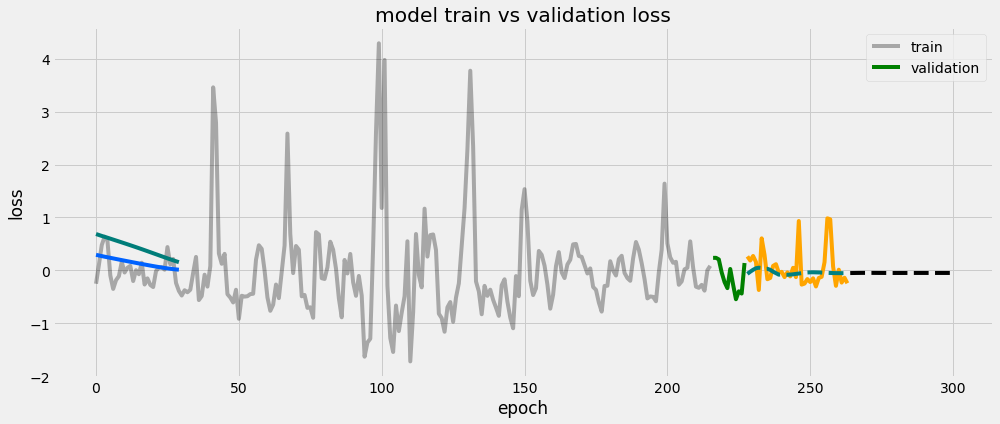

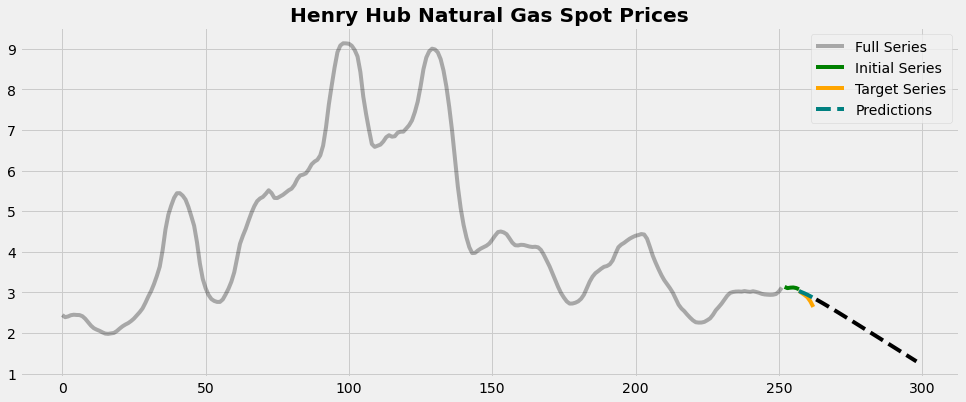

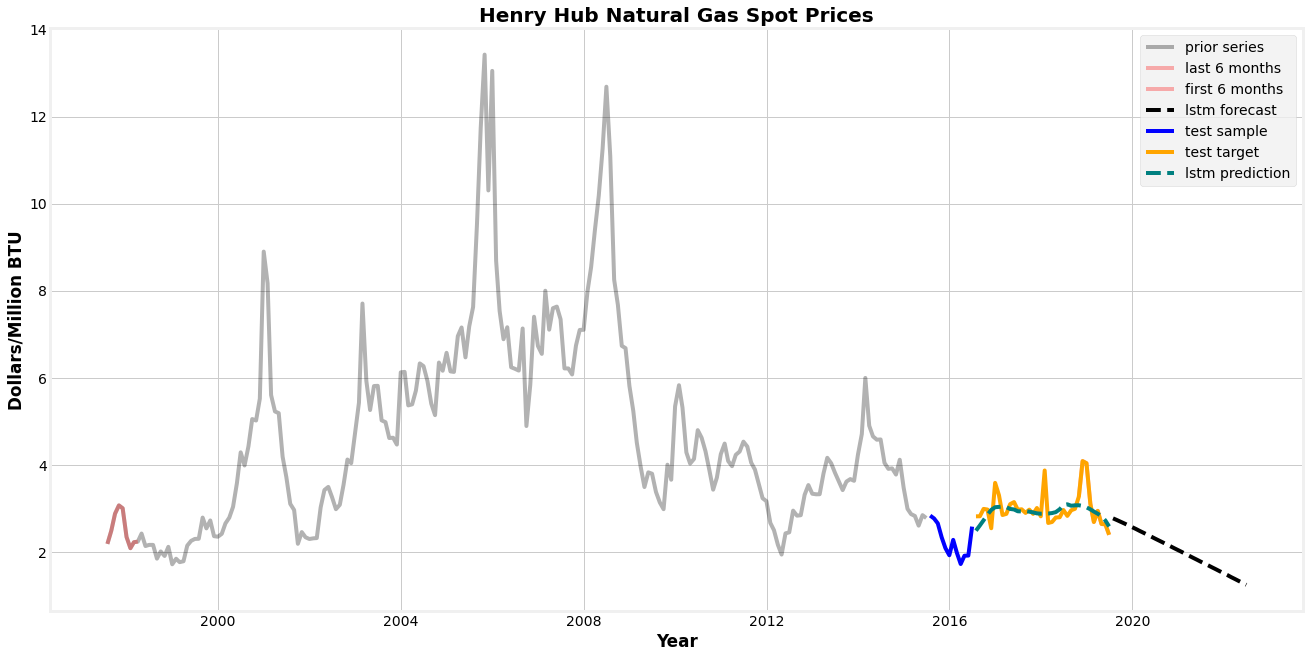

In [613]:
forecasting_trend_full(hhgas[6:-6], df_trend, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 50, 30)

## Using Differencing 

In [40]:
sc = MinMaxScaler(feature_range = (0,1))
df_origin = np.array(hhgas)
df = hhgas.diff().dropna()
input_months=6 #sample size
test_months = 18 #test portion of forecast series in months
sample_gap = 1
series_name = hhgas[hhgas.columns[0]].name
series_years = 10  #forecast series length
prior = df[:-test_months]
prior_origin = np.array(df_origin[:-test_months])
title = 'Henry Hub Natural Gas Spot Prices'

no of samples 96.0
Train on 72 samples, validate on 24 samples
Epoch 1/50
72/72 [==============================] - 4s 61ms/step - loss: 0.2319 - val_loss: 0.2384
Epoch 2/50
72/72 [==============================] - 1s 8ms/step - loss: 0.2045 - val_loss: 0.2099
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1781 - val_loss: 0.1822
Epoch 4/50
72/72 [==============================] - 1s 9ms/step - loss: 0.1524 - val_loss: 0.1549
Epoch 5/50
72/72 [==============================] - 1s 9ms/step - loss: 0.1270 - val_loss: 0.1279
Epoch 6/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1020 - val_loss: 0.1014
Epoch 7/50
72/72 [==============================] - 1s 11ms/step - loss: 0.0778 - val_loss: 0.0764
Epoch 8/50
72/72 [==============================] - 1s 9ms/step - loss: 0.0556 - val_loss: 0.0546
Epoch 9/50
72/72 [==============================] - 1s 11ms/step - loss: 0.0371 - val_loss: 0.0383
Epoch 10/50
72/72 [==============================] -

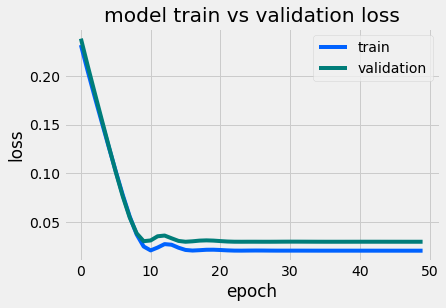

In [42]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y= \
data.get_train_test_data()
n_steps = 60
No = n_steps
Ni = test_X_init.shape[0]
R_ = (Ni/No)**(1/3)
h1 = int(np.round(No*(R_**2)))
h2 = int(np.round(No*R_))
fit = FIT(train_X, train_y, 0, 0, h1, h2, 50)
print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
model = fit.LSTM()

Actual Predicted  Error Percent Error
0     3.1       3.1    0.0           0.0
1     2.7       3.2    0.5          18.0
2     2.9       3.2    0.3          10.1
3     2.6       3.3    0.7          25.7
4     2.6       3.4    0.8          28.5
5     2.4       3.4    1.0          41.3
6     2.4       3.4    1.0          43.6
7     2.2       3.4    1.2          53.3
8     2.6       3.4    0.8          33.1
9     2.3       3.4    1.1          46.1
10    2.6       3.4    0.8          28.6
11    2.2       3.4    1.2          52.1

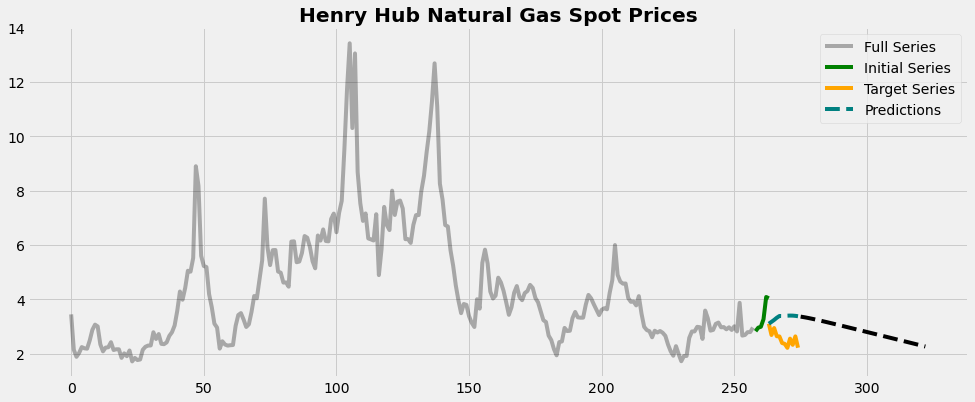

In [43]:
predict = PREDICT_DIFF(test_X_init, test_X_init,  n_steps, test_y, model, prior, prior_origin, test_months, 'Henry Hub Natural Gas Spot Prices', True)
predict = predict.predict_and_plot()
predicted_rnn = pd.DataFrame(predict[3])
predicted_rnn.index = hhgas.index[-len(predicted_rnn):]
true_rnn = pd.DataFrame(df_origin[-(test_months - input_months):])
hhscores_rnn = Scores(true_rnn, predicted_rnn)
hhscores_rnn.scores()
hhscores_rnn.df()

## Brent Crude

In [44]:
brentprice = pd.read_excel('DCOILBRENTEU_2.xls', sheet_name = 2)
brentprice['observation_date'] = pd.to_datetime(brentprice['observation_date'])
brentprice.insert(0, 'year', brentprice['observation_date'].dt.year)
brentprice.insert(1, 'month', brentprice['observation_date'].dt.month)
brentprice.set_index('observation_date', inplace = True)
brentprice.head()

year  month  DCOILBRENTEU_20160316  DCOILBRENTEU_20160323  \
observation_date                                                              
1987-05-20        1987      5                   18.6                   18.6   
1987-05-21        1987      5                   18.4                   18.4   
1987-05-22        1987      5                   18.6                   18.6   
1987-05-25        1987      5                   18.6                   18.6   
1987-05-26        1987      5                   18.6                   18.6   

                  DCOILBRENTEU_20160330  DCOILBRENTEU_20160406  \
observation_date                                                 
1987-05-20                         18.6                   18.6   
1987-05-21                         18.4                   18.4   
1987-05-22                         18.6                   18.6   
1987-05-25                         18.6                   18.6   
1987-05-26                         18.6                   18.6   

                  DCOILBRENTEU_20160413  DCOILBRENTEU_20160420  \
observation_date                                                 
1987-05-20                         18.6                   18.6   
1987-05-21                         18.4                   18.4   
1987-05-22                         18.6                   18.6   
1987-05-25                         18.6                   18.6   
1987-05-26                         18.6                   18.6   

                  DCOILBRENTEU_20160427  DCOILBRENTEU_20160504  ...  \
observation_date                                                ...   
1987-05-20                         18.6                   18.6  ...   
1987-05-21                         18.4                   18.4  ...   
1987-05-22                         18.6                   18.6  ...   
1987-05-25                         18.6                   18.6  ...   
1987-05-26                         18.6                   18.6  ...   

                  DCOILBRENTEU_20201015  DCOILBRENTEU_20201021  \
observation_date                                                 
1987-05-20                         18.6                   18.6   
1987-05-21                         18.4                   18.4   
1987-05-22                         18.6                   18.6   
1987-05-25                         18.6                   18.6   
1987-05-26                         18.6                   18.6   

                  DCOILBRENTEU_20201028  DCOILBRENTEU_20201104  \
observation_date                                                 
1987-05-20                         18.6                   18.6   
1987-05-21                         18.4                   18.4   
1987-05-22                         18.6                   18.6   
1987-05-25                         18.6                   18.6   
1987-05-26                         18.6                   18.6   

                  DCOILBRENTEU_20201112  DCOILBRENTEU_20201118  \
observation_date                                                 
1987-05-20                         18.6                   18.6   
1987-05-21                         18.4                   18.4   
1987-05-22                         18.6                   18.6   
1987-05-25                         18.6                   18.6   
1987-05-26                         18.6                   18.6   

                  DCOILBRENTEU_20201125  DCOILBRENTEU_20201202  \
observation_date                                                 
1987-05-20                         18.6                   18.6   
1987-05-21                         18.4                   18.4   
1987-05-22                         18.6                   18.6   
1987-05-25                         18.6                   18.6   
1987-05-26                         18.6                   18.6   

                  DCOILBRENTEU_20201209  DCOILBRENTEU_20201216  
observation_date                                                
1987-05-20                         18.6                   

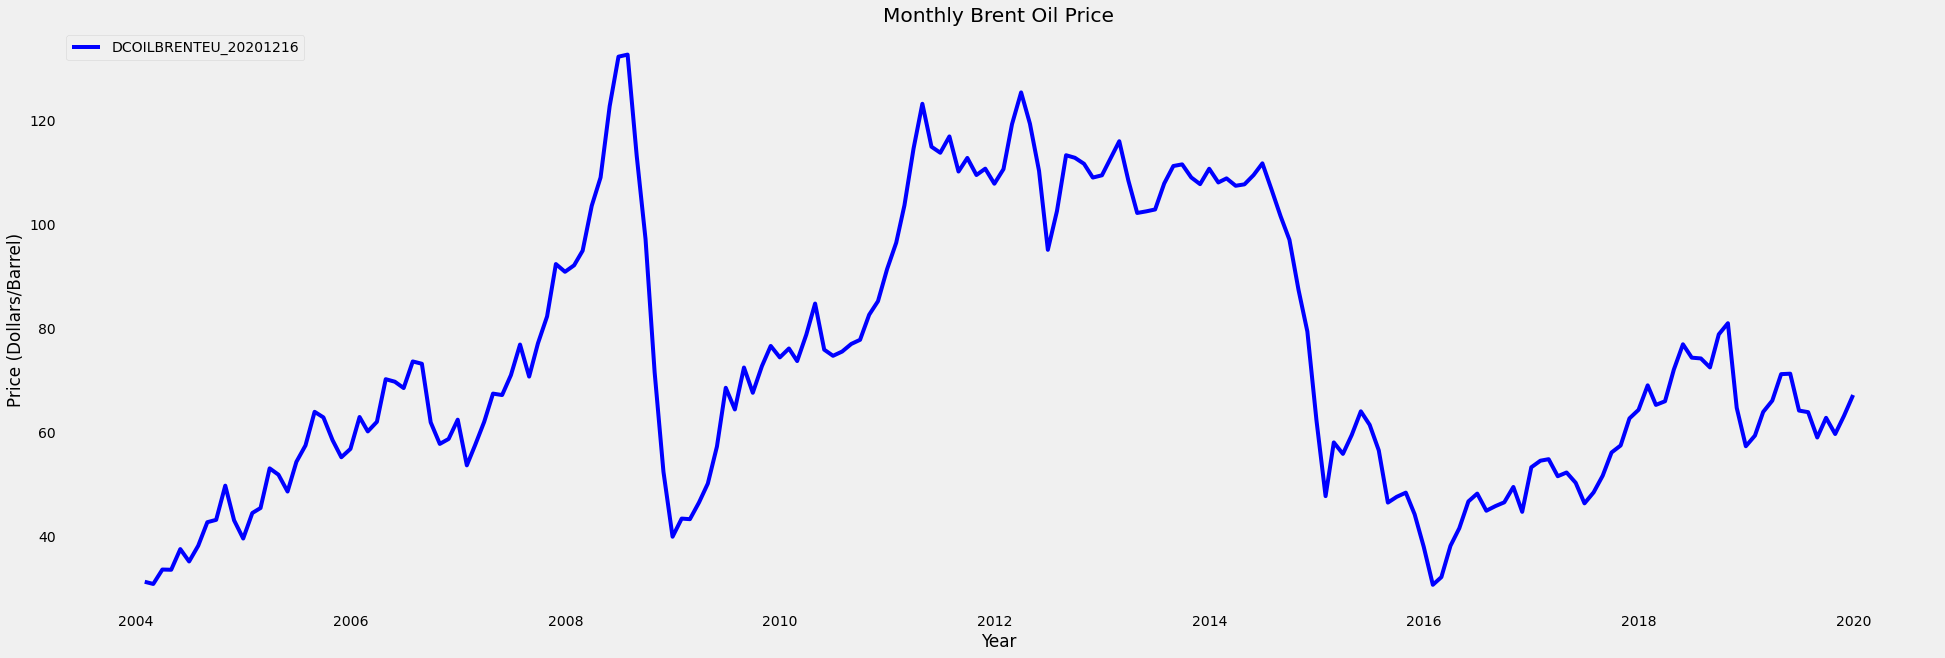

In [45]:
brentoil = brentprice[brentprice[brentprice.columns[-1]]>0][['year', brentprice.columns[-1]]].resample('M').mean()
brentoil = brentoil[brentoil['year'] > 2003]
brentoil = brentoil[brentoil['year'] < 2020]
brentoil = brentoil[[brentoil.columns[-1]]]
oillegend = brentprice.columns[-1]
run_sequence_plot(brentoil.index, brentoil, legend = oillegend, title = 'Monthly Brent Oil Price', xlabel = 'Year', ylabel ='Price (Dollars/Barrel)')

Test Statistic          -2.8
p-value                  0.1
Lags Used                1.0
Observations Used      190.0
Critical Value (1%)     -3.5
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
nearly stationary, but we cannot reject the null, that it is non-stationary with 95% confidence


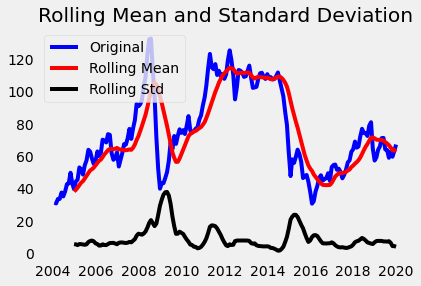

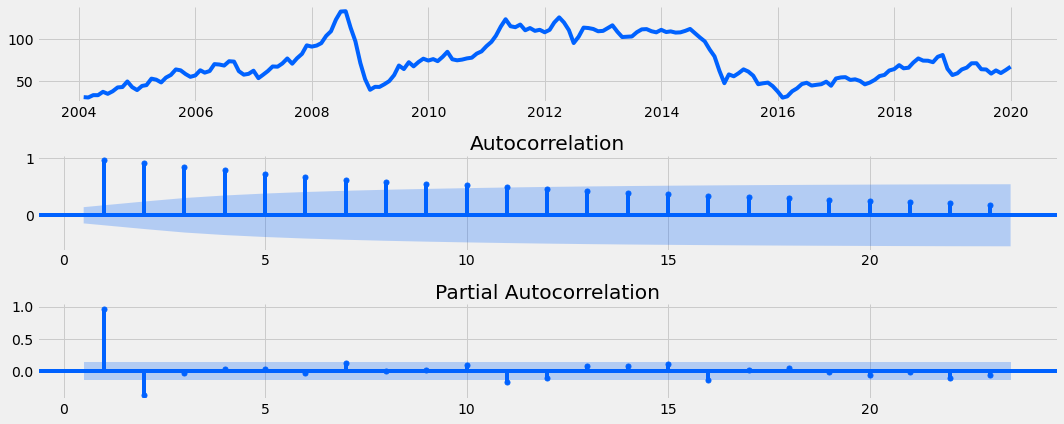

In [46]:
dftest(brentoil)
plots(brentoil)

<AxesSubplot:xlabel='observation_date'>

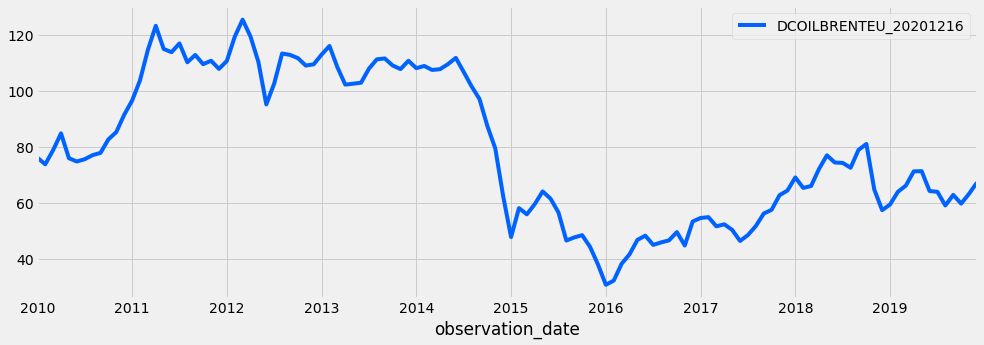

In [47]:
brentoil[-120:].plot(figsize = (15, 5))

No apparent seasonality

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=brentoil, 
                                            model='additive', 
                                            period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
brentoil_ = estimated_seasonal[6:-6] + estimated_residual[6:-6]  #residual and trend, first and last six values are null
#estimated_trend_multi.plot()

Test Statistic          -7.1
p-value                  0.0
Lags Used                4.0
Observations Used      175.0
Critical Value (1%)     -3.5
Critical Value (5%)     -2.9
Critical Value (10%)    -2.6
dtype: float64
very likely stationary, we can reject the null, that it is non-stationary with 99% confidence


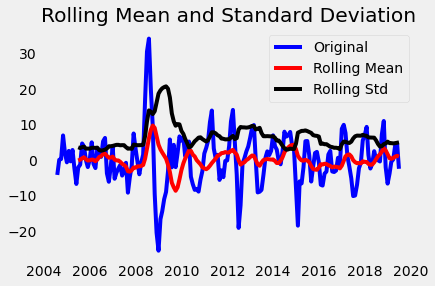

In [51]:
brentoil_ = pd.DataFrame(brentoil_)#[6:-6])
brentoil_trend = pd.DataFrame(estimated_trend[6:-6])
brentoil_seasonal = pd.DataFrame(estimated_seasonal[6:-6])
brentoil_residual = pd.DataFrame(estimated_residual[6:-6])
dftest(brentoil_residual)

<AxesSubplot:xlabel='observation_date'>

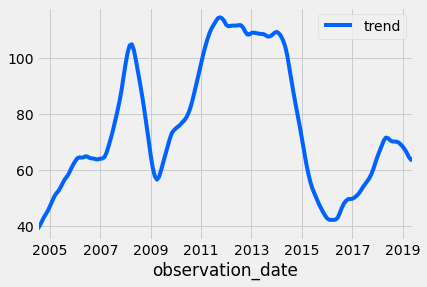

In [52]:
brentoil_trend.plot()

In [580]:
brentoilarima = sm.tsa.statespace.SARIMAX(brentoil,     ##hhgas
                                order=(1,1,1), 
                                seasonal_order=(1,1,1,9), ##None
                                trend='c').fit()
brentoilarima.summary()

KeyboardInterrupt: 

In [ ]:
plots(brentoilsarima.resid[hhgasarima.loglikelihood_burn:])

In [ ]:
brentoil_model = pm.auto_arima(brentoil, start_p=0, start_q=0,
                           max_p=2, max_q=2, start_d=0, max_d=1, m=9, max_m=12,
                           start_P=0, start_Q=0, max_P = 1, max_Q = 1, seasonal=True,
                            D=1, max_D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(brentoil_model.aic())

In [ ]:
series = brentoil
horizon = 5
start = 50
step_size = 5
orders = [(1,0,0), (1,1,0), (0,1,0), (0,1,1)]
seasonal_orders = [(0,0,0,0), (0,1,0, 12)]
trends = [None, 'c']
grid_search_ARIMA(series,horizon,start,step_size,orders = orders,seasonal_orders = seasonal_orders,trends=trends)

In [ ]:
hhgasforecast = hhgasarima.get_forecast(steps = 72, dynamic = True)
hhgasforecast = hhgasforecast.summary_frame()
hhgasforecast.rename(columns = {'mean':'forecast'}, inplace = True)
train_hhgas = hhgas[:-50]
test_hhgas = hhgas[-50:]
predict_hhgas = pd.DataFrame(hhgasarima.predict(dynamic = False)[-50:])

In [62]:
df = brentoil
sc = MinMaxScaler(feature_range = (0,1))
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition_multi = seasonal_decompose(x=df, 
                                            model='additive', 
                                            period=12)
estimated_trend_multi = ss_decomposition_multi.trend
estimated_seasonal_multi = ss_decomposition_multi.seasonal
estimated_residual_multi = ss_decomposition_multi.resid
print(len(df) == len(estimated_trend_multi) == len(estimated_seasonal_multi) == len(estimated_residual_multi))
df_ = estimated_seasonal_multi[6:-6] + estimated_residual_multi[6:-6] #residual and trend, first and last six values are null
#estimated_trend_multi.plot()
df_ = pd.DataFrame(df_)#[6:-6])
df_trend = pd.DataFrame(estimated_trend_multi[6:-6])
df_seasonal = pd.DataFrame(estimated_seasonal_multi[6:-6])
df_residual = pd.DataFrame(estimated_residual_multi[6:-6])
df = df_
input_months= 12 #sample size
test_months = 48 #test portion of forecast series in months
n_steps = 72
sample_gap = 1
series_name = df[df.columns[0]].name
series_years = 12 #forecast series length
trend_years = 1.5
trend_input_months = 3
trend_test_months = 9
trend_n_steps = (n_steps -(test_months-input_months)) + trend_test_months - trend_input_months
prior = df[:-test_months]
    #prior_origin = np.array(df_origin[:-test_months])
title = 'Brent Oil Price'
ylabel = 'Dollars/Million BTU'

True


In [63]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y = \
data.get_train_test_data()

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/50
63/63 [==============================] - 7s 104ms/step - loss: 0.2128 - val_loss: 0.1819
Epoch 2/50
63/63 [==============================] - 1s 14ms/step - loss: 0.1589 - val_loss: 0.1281
Epoch 3/50
63/63 [==============================] - 1s 14ms/step - loss: 0.1098 - val_loss: 0.0788
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0664 - val_loss: 0.0382
Epoch 5/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0350 - val_loss: 0.0172
Epoch 6/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0276 - val_loss: 0.0245
Epoch 7/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0394 - val_loss: 0.0277
Epoch 8/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0381 - val_loss: 0.0197
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0297 - val_loss: 0.0166
Epoch 10/50
63/63 [==========================

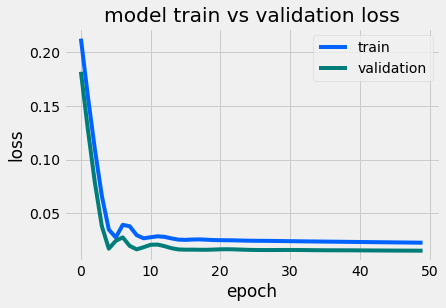

no of samples 6.0
Train on 4 samples, validate on 2 samples
Epoch 1/70
4/4 [==============================] - 6s 1s/step - loss: 0.8984 - val_loss: 0.7053
Epoch 2/70
4/4 [==============================] - 0s 26ms/step - loss: 0.8883 - val_loss: 0.6955
Epoch 3/70
4/4 [==============================] - 0s 39ms/step - loss: 0.8784 - val_loss: 0.6859
Epoch 4/70
4/4 [==============================] - 0s 31ms/step - loss: 0.8685 - val_loss: 0.6769
Epoch 5/70
4/4 [==============================] - 0s 25ms/step - loss: 0.8593 - val_loss: 0.6674
Epoch 6/70
4/4 [==============================] - 0s 19ms/step - loss: 0.8496 - val_loss: 0.6579
Epoch 7/70
4/4 [==============================] - 0s 21ms/step - loss: 0.8399 - val_loss: 0.6485
Epoch 8/70
4/4 [==============================] - 0s 29ms/step - loss: 0.8302 - val_loss: 0.6392
Epoch 9/70
4/4 [==============================] - 0s 30ms/step - loss: 0.8206 - val_loss: 0.6299
Epoch 10/70
4/4 [==============================] - 0s 29ms/step - los

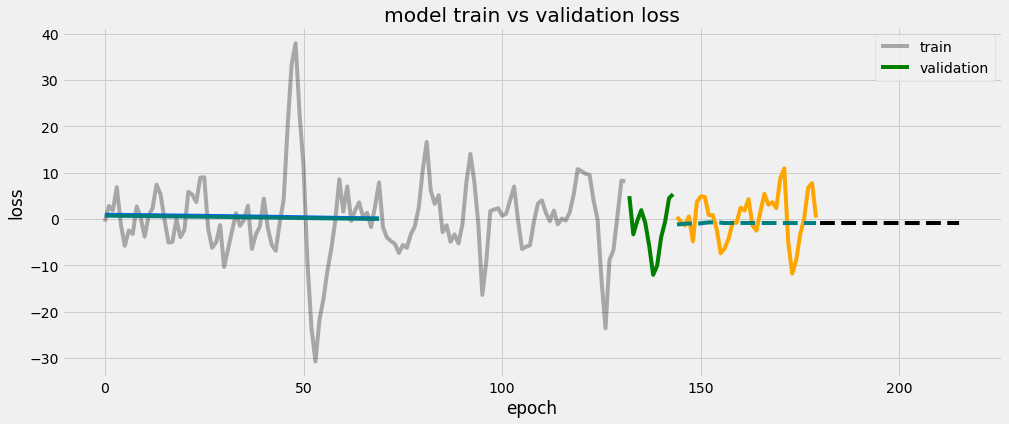

(25.335974165587867, 0.7717225879071293)

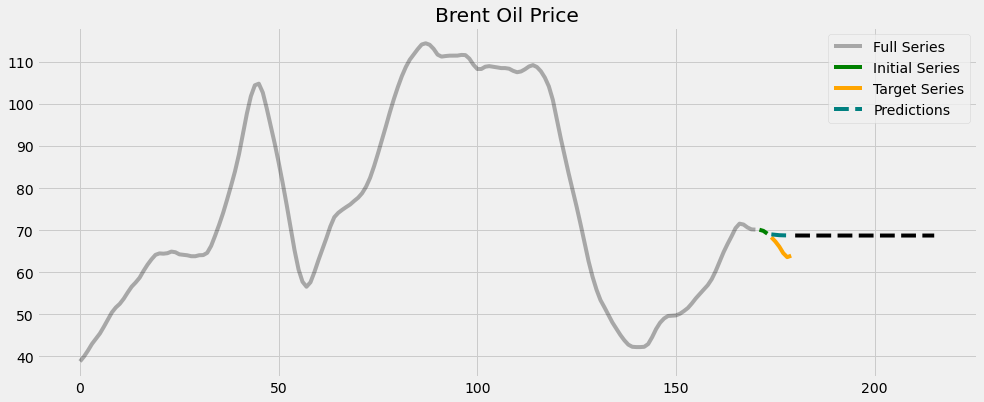

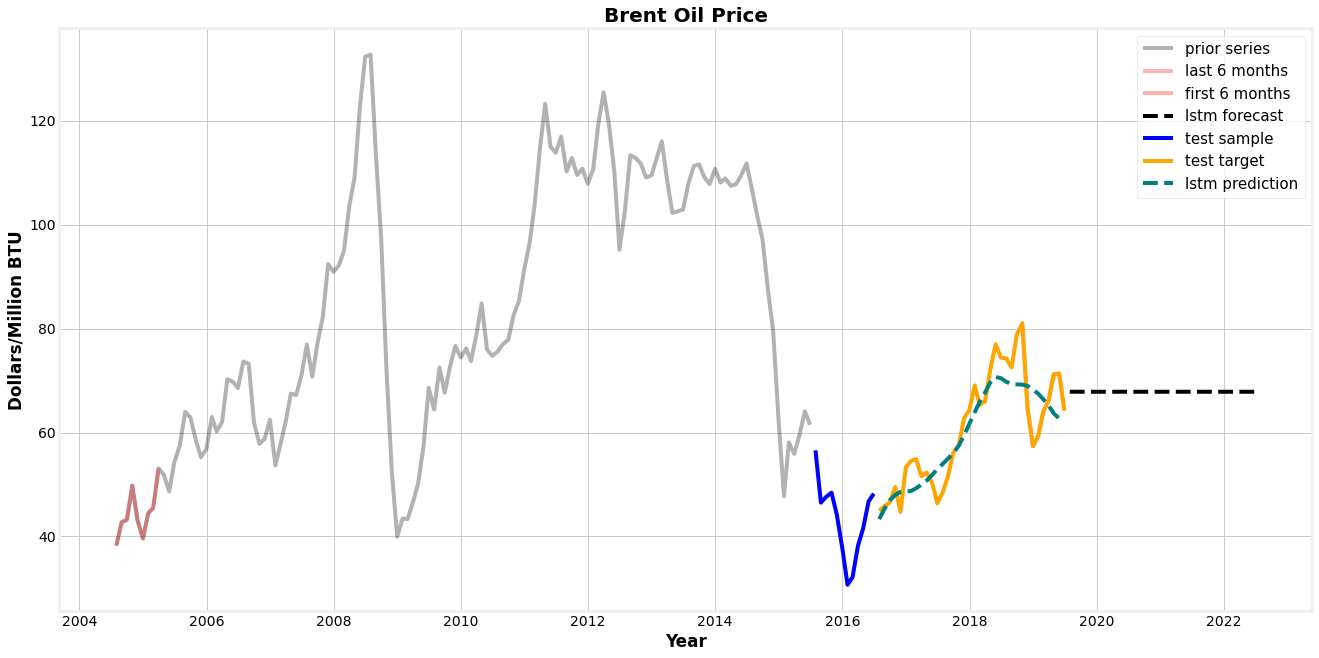

In [61]:
forecasting_full(brentoil[6:-6], title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 50, 70)

no of samples 84.0
Train on 63 samples, validate on 21 samples
Epoch 1/50
63/63 [==============================] - 7s 113ms/step - loss: 0.2206 - val_loss: 0.1933
Epoch 2/50
63/63 [==============================] - 1s 13ms/step - loss: 0.1713 - val_loss: 0.1455
Epoch 3/50
63/63 [==============================] - 1s 15ms/step - loss: 0.1276 - val_loss: 0.1009
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0868 - val_loss: 0.0595
Epoch 5/50
63/63 [==============================] - 1s 13ms/step - loss: 0.0510 - val_loss: 0.0269
Epoch 6/50
63/63 [==============================] - 1s 13ms/step - loss: 0.0284 - val_loss: 0.0169
Epoch 7/50
63/63 [==============================] - 1s 13ms/step - loss: 0.0308 - val_loss: 0.0273
Epoch 8/50
63/63 [==============================] - 1s 18ms/step - loss: 0.0398 - val_loss: 0.0241
Epoch 9/50
63/63 [==============================] - 1s 18ms/step - loss: 0.0335 - val_loss: 0.0172
Epoch 10/50
63/63 [==========================

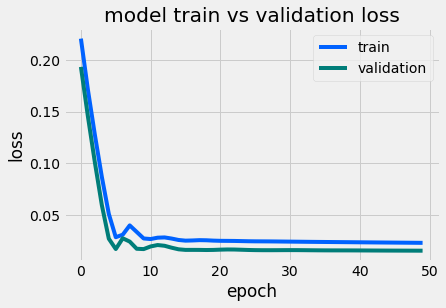

no of samples 6.0
Train on 4 samples, validate on 2 samples
Epoch 1/30
4/4 [==============================] - 7s 2s/step - loss: 0.3515 - val_loss: 0.1118
Epoch 2/30
4/4 [==============================] - 0s 35ms/step - loss: 0.3440 - val_loss: 0.1083
Epoch 3/30
4/4 [==============================] - 0s 29ms/step - loss: 0.3366 - val_loss: 0.1048
Epoch 4/30
4/4 [==============================] - 0s 41ms/step - loss: 0.3294 - val_loss: 0.1014
Epoch 5/30
4/4 [==============================] - 0s 31ms/step - loss: 0.3222 - val_loss: 0.0981
Epoch 6/30
4/4 [==============================] - 0s 27ms/step - loss: 0.3151 - val_loss: 0.0949
Epoch 7/30
4/4 [==============================] - 0s 29ms/step - loss: 0.3083 - val_loss: 0.0917
Epoch 8/30
4/4 [==============================] - 0s 35ms/step - loss: 0.3014 - val_loss: 0.0885
Epoch 9/30
4/4 [==============================] - 0s 35ms/step - loss: 0.2946 - val_loss: 0.0854
Epoch 10/30
4/4 [==============================] - 0s 34ms/step - los

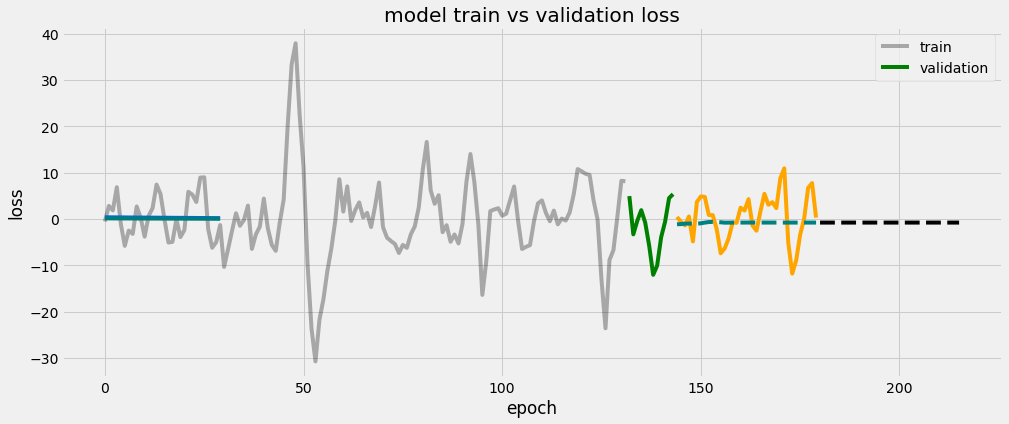

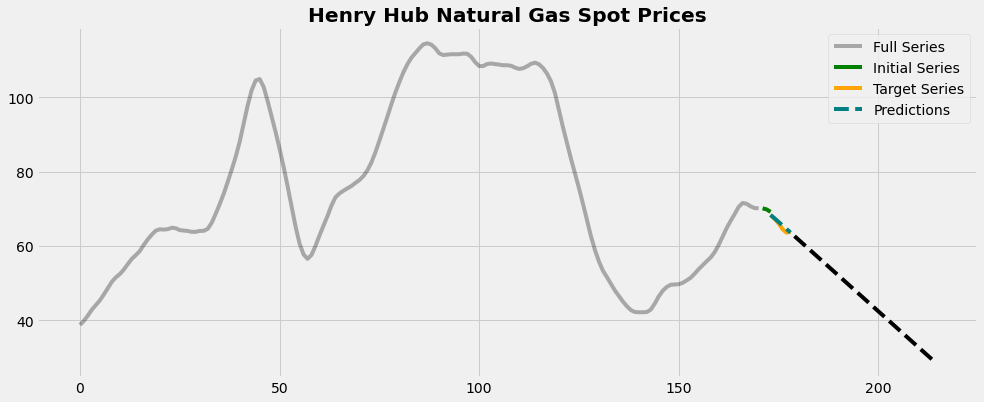

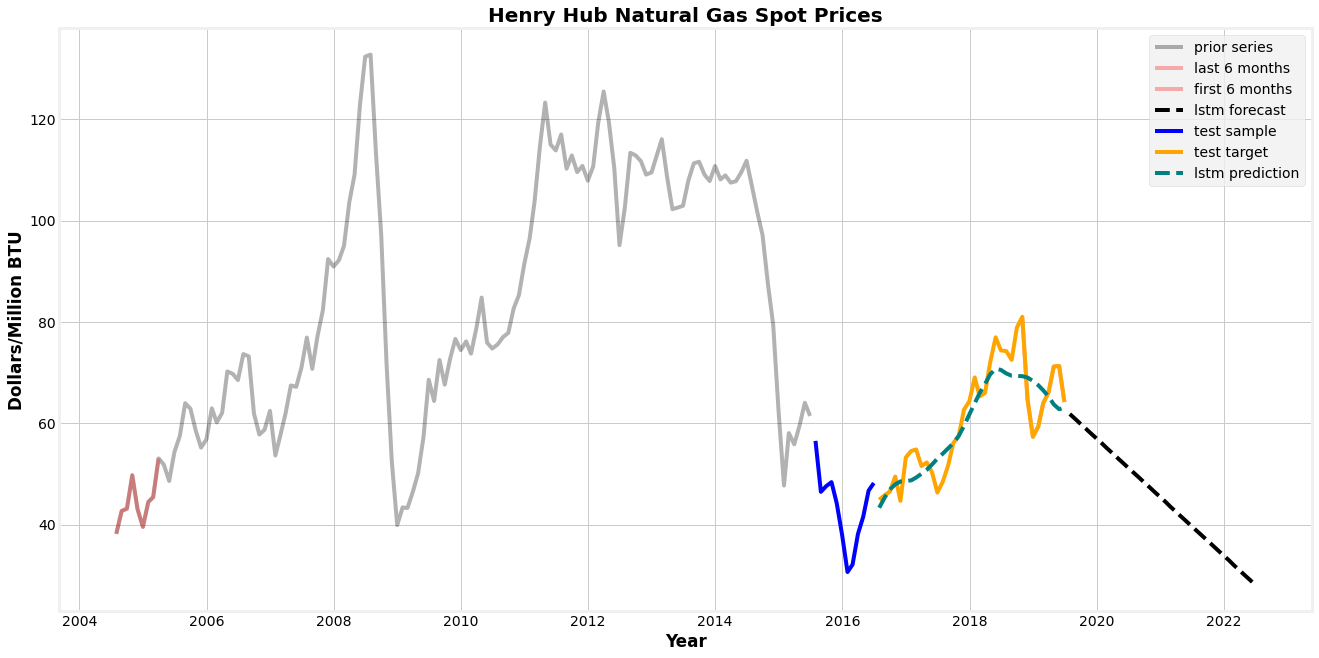

In [64]:
forecasting_trend_full(brentoil[6:-6], df_trend, title, ylabel, input_months, test_months, series_years, trend_years, trend_input_months, trend_test_months, trend_n_steps, n_steps, 50, 30)

## Using Differencing 

In [70]:
sc = MinMaxScaler(feature_range = (0,1))
df_origin = np.array(brentoil)
df = brentoil.diff().dropna()
input_months= 12#sample size
test_months = 36 #test portion of forecast series in months
sample_gap = 1
series_name = brentoil[brentoil.columns[0]].name
series_years = 10  #forecast series length
prior = df[:-test_months]
prior_origin = np.array(df_origin[:-test_months])
title = 'Brent Crude Prices'

In [ ]:
data = GETDATA(df, series_name, series_years, input_months, 
                 test_months, sample_gap)
train_X, test_X_init, train_y, test_y= \
data.get_train_test_data()
n_steps = 60
No = n_steps
Ni = test_X_init.shape[0]
R_ = (Ni/No)**(1/3)
h1 = int(np.round(No*(R_**2)))
h2 = int(np.round(No*R_))
fit = FIT(train_X, train_y, 0, 0, h1, h2, 50)
print('no of samples',(12*series_years -test_months-input_months)/sample_gap)
model = fit.LSTM()

Actual Predicted  Error Percent Error
0    69.1      69.1    0.0           0.0
1    65.3      69.0    3.7           5.7
2    66.0      69.0    3.0           4.6
3    72.1      69.2   -2.9           4.0
4    77.0      69.3   -7.6           9.9
5    74.4      69.5   -4.9           6.5
6    74.3      69.8   -4.4           5.9
7    72.5      70.0   -2.5           3.4
8    78.9      70.1   -8.8          11.2
9    81.0      69.9  -11.1          13.7
10   64.7      69.7    5.0           7.7
11   57.4      69.3   11.9          20.8
12   59.4      68.8    9.3          15.7
13   64.0      68.2    4.3           6.6
14   66.1      67.6    1.5           2.3
15   71.2      67.0   -4.2           5.9
16   71.3      66.4   -4.9           6.9
17   64.2      65.7    1.5           2.3
18   63.9      65.0    1.1           1.7
19   59.0      64.2    5.2           8.8
20   62.8      63.4    0.6           0.9
21   59.7      62.5    2.8           4.7
22   63.2      61.6   -1.6           2.5
23   67.2      60.7   -6.5           9.7

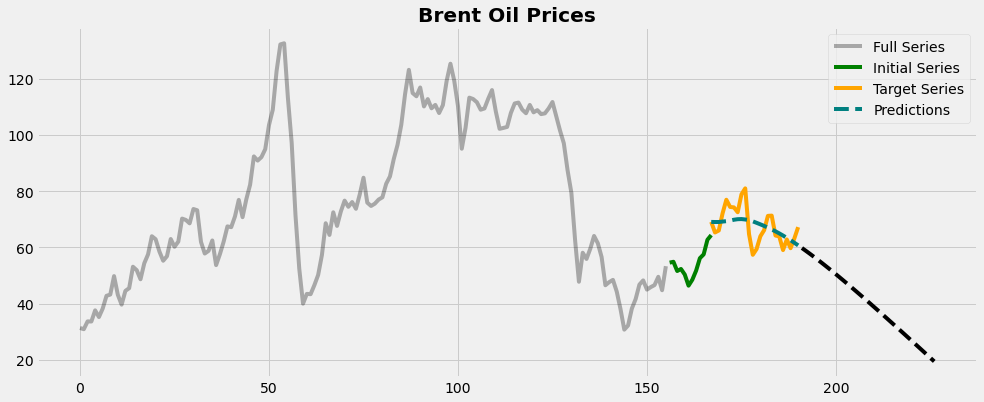

In [72]:
predict = PREDICT_DIFF(test_X_init, test_X_init,  n_steps, test_y, model, prior, prior_origin, test_months, 'Brent Oil Prices', True)
predict = predict.predict_and_plot()
predicted_rnn = pd.DataFrame(predict[3])
predicted_rnn.index = brentoil.index[-len(predicted_rnn):]
true_rnn = pd.DataFrame(df_origin[-(test_months - input_months):])
hhscores_rnn = Scores(true_rnn, predicted_rnn)
hhscores_rnn.scores()
hhscores_rnn.df()